# **Laboratorio 1 (Incisos: 3, 4, 5 y 6)**
Daniel Machic(2218), María José Ramírez(221051)

In [2]:
!pip install numpy==1.26.4
!pip install scipy==1.11.4
!pip install statsmodels==0.14.1
!pip install pmdarima==2.0.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 46.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.11.4 which is incompatible.


In [15]:
import pmdarima as pm

# If the fix was successful, this will run without any errors.
print(f"Successfully imported pmdarima version {pm.__version__}!")

Successfully imported pmdarima version 2.0.4!


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing   # <--- Agregado
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator  # <--- Agregado

## **3) Series de Tiempo**

#### *Lectura datos*

I. Importaciones

In [21]:
archivo = 'Importaciones.xlsx'
df = pd.read_excel(archivo)


df.columns = df.columns.str.strip()




df['Fecha'] = pd.to_datetime(df['Fecha'], format='%Y-%m')
df.set_index('Fecha', inplace=True)

columnas_deseadas = ['Gasolina superior', 'Gasolina regular', 'Diesel', 'Gas licuado']
importaciones = df[columnas_deseadas]
print('\nDatos filtrados:')
print(importaciones.head())

importaciones.columns = importaciones.columns.str.strip()
importaciones.columns = importaciones.columns.str.lower()  #


Datos filtrados:
            Gasolina superior  Gasolina regular     Diesel  Gas licuado
Fecha                                                                  
2001-01-01          373963.96         177776.50  566101.99    194065.74
2001-02-01          243091.07         123115.99  489525.80    170703.38
2001-03-01          312084.38         161726.42  575559.68    161837.37
2001-04-01          285054.89         127338.74  437745.42    163048.64
2001-05-01          300913.67         168730.19  552609.13    171518.86


II. Consumo

In [22]:
archivo1 = 'Consumo (1).xlsx'
df1 = pd.read_excel(archivo1)


df1.columns = df1.columns.str.strip()




df1['Fecha'] = pd.to_datetime(df1['Fecha'], format='%Y-%m')
df1.set_index('Fecha', inplace=True)

columnas_deseadas1 = ['Gasolina superior', 'Gasolina regular', 'Diesel', 'Gas Licuado']
consumos = df1[columnas_deseadas1]
print('\nDatos filtrados:')
print(consumos.head())

consumos.columns = consumos.columns.str.strip()
consumos.columns = consumos.columns.str.lower()  #


Datos filtrados:
            Gasolina superior  Gasolina regular     Diesel  Gas Licuado
Fecha                                                                  
2000-01-01          308156.82         202645.20  634667.06    194410.48
2000-02-01          307766.31         205530.96  642380.66    174710.55
2000-03-01          331910.29         229499.56  699807.25    189234.07
2000-04-01          315648.08         210680.40  586803.98    174330.61
2000-05-01          319667.97         208164.34  656948.20    191745.15


III. Precios

In [23]:
archivo2 = 'precios2.xlsx'
df2 = pd.read_excel(archivo2)

# Limpiar nombres de columnas
df2.columns = df2.columns.str.strip()

# Reemplazar valores raros en la columna Fecha
df2['Fecha'] = df2['Fecha'].replace('########', None)

# Convertir fechas (forzar errores a NaT)
df2['Fecha'] = pd.to_datetime(df2['Fecha'], format='%Y-%m', errors='coerce')

# Eliminar filas con fechas inválidas
df2 = df2.dropna(subset=['Fecha'])

# Poner Fecha como índice
df2.set_index('Fecha', inplace=True)

# Limpiar nombres de columnas
df2.columns = df2.columns.str.strip().str.lower()

# Seleccionar columnas deseadas
columnas_deseadas2 = ['superior', 'regular', 'diesel']
precios = df2[columnas_deseadas2]

# Mostrar datos
print('\nDatos filtrados:')
print(precios.head())



Datos filtrados:
            superior regular diesel
Fecha                              
2021-01-01     43.24   27.45  25.47
2021-01-02     43.24   27.45  25.47
2021-01-03     43.24   27.45  25.47
2021-01-04     43.24   27.45  25.47
2021-01-05     43.24   27.45  25.47


#### *Train y Test*

In [31]:
#Importaciones


from pmdarima import auto_arima
train_size_I = int(len(importaciones) * 0.7)
train_i = importaciones[0:train_size_I]
test_i = importaciones[train_size_I:len(importaciones)]

In [25]:
#Consumo


from pmdarima import auto_arima
train_size_c = int(len(consumos) * 0.7)
train_c = consumos[0:train_size_c]
test_c = consumos[train_size_c:len(consumos)]

In [38]:
#Precios


from pmdarima import auto_arima
train_size_p = int(len(precios) * 0.7)
train_p = precios[0:train_size_p]
test_p = precios[train_size_p:len(precios)]

precios.index = pd.to_datetime(precios.index, errors='coerce')

# Quitar filas con índice NaT o valores NaN
precios = precios.dropna()

### Análisis Preliminar

#### **a. Inicio, Fin y Frecuencia:**

I. Importaciones:

In [27]:
print(train_i.columns.tolist())

['gasolina superior', 'gasolina regular', 'diesel', 'gas licuado']


In [33]:
#Importaciones

# Use the correct lowercase column names
ts_importa_superior = train_i['gasolina superior']
ts_importa_superior_test = test_i['gasolina superior']

ts_importa_diesel = train_i['diesel']
ts_importa_diesel_test = test_i['diesel']

ts_importa_regular = train_i['gasolina regular']
ts_importa_regular_test = test_i['gasolina regular']

ts_importa_licuado = train_i['gas licuado']
ts_importa_licuado_test = test_i['gas licuado']

print('\nImportaciones Gasolina Superior')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_importa_superior.head(1))
print('\nFin de la serie', ts_importa_superior.tail(1))

print('\nImportaciones Diesel')
print('Frecuencia: MENSUAL')

print('\nInicio de la serie', ts_importa_diesel.head(1))
print('\nFin de la serie', ts_importa_diesel.tail(1))

print('\nImportaciones Gasolina Regular')
print('Frecuencia: MENSUAL')

print('\nInicio de la serie', ts_importa_regular.head(1))
print('\nFin de la serie', ts_importa_regular.tail(1))

print('\nImportaciones Gasolina Licuado')
print('Frecuencia: MENSUAL')

print('\nInicio de la serie', ts_importa_licuado.head(1))
print('\nFin de la serie', ts_importa_licuado.tail(1))


Importaciones Gasolina Superior
Frecuencia: MENSUAL

Inicio de la serie Fecha
2001-01-01    373963.96
Name: gasolina superior, dtype: float64

Fin de la serie Fecha
2018-01-01    535784.7
Name: gasolina superior, dtype: float64

Importaciones Diesel
Frecuencia: MENSUAL

Inicio de la serie Fecha
2001-01-01    566101.99
Name: diesel, dtype: float64

Fin de la serie Fecha
2018-01-01    1153831.89
Name: diesel, dtype: float64

Importaciones Gasolina Regular
Frecuencia: MENSUAL

Inicio de la serie Fecha
2001-01-01    177776.5
Name: gasolina regular, dtype: float64

Fin de la serie Fecha
2018-01-01    571858.06
Name: gasolina regular, dtype: float64

Importaciones Gasolina Licuado
Frecuencia: MENSUAL

Inicio de la serie Fecha
2001-01-01    194065.74
Name: gas licuado, dtype: float64

Fin de la serie Fecha
2018-01-01    396363.05
Name: gas licuado, dtype: float64


La serie de importaciones mensuales muestra un incremento generalizado entre 2001 y 2018 en todos los combustibles analizados. La gasolina superior pasó de 373,963.96 a 535,784.7, la gasolina regular de 177,776.5 a 571,858.06, el diésel de 566,101.99 a 1,153,831.89, y el gas licuado de 194,065.74 a 396,363.05, lo que refleja un aumento sostenido en la demanda de estos productos durante el periodo.

II. Consumo:

In [34]:
# Limpiar nombres de columnas
train_c.columns = train_c.columns.str.strip().str.lower()
test_c.columns = test_c.columns.str.strip().str.lower()

# Series individuales
ts_consu_superior = train_c['gasolina superior']
ts_consu_superior_test = test_c['gasolina superior']

ts_consu_diesel = train_c['diesel']
ts_consu_diesel_test = test_c['diesel']

ts_consu_regular = train_c['gasolina regular']
ts_consu_regular_test = test_c['gasolina regular']

ts_consu_licuado = train_c['gas licuado']
ts_consu_licuado_test = test_c['gas licuado']

print('\nConsumo Gasolina Superior')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_consu_superior.head(1))
print('\nFin de la serie', ts_consu_superior.tail(1))


print('\nConsumo Gasolina regular')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_consu_regular.head(1))
print('\nFin de la serie', ts_consu_regular.tail(1))

print('\nConsumo Diesel')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_consu_diesel.head(1))
print('\nFin de la serie', ts_consu_diesel.tail(1))

print('\nConsumo Gas Licuado')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_consu_licuado.head(1))
print('\nFin de la serie', ts_consu_licuado.tail(1))


Consumo Gasolina Superior
Frecuencia: MENSUAL

Inicio de la serie Fecha
2000-01-01    308156.82
Name: gasolina superior, dtype: float64

Fin de la serie Fecha
2017-09-01    560892.67
Name: gasolina superior, dtype: float64

Consumo Gasolina regular
Frecuencia: MENSUAL

Inicio de la serie Fecha
2000-01-01    202645.2
Name: gasolina regular, dtype: float64

Fin de la serie Fecha
2017-09-01    492618.55
Name: gasolina regular, dtype: float64

Consumo Diesel
Frecuencia: MENSUAL

Inicio de la serie Fecha
2000-01-01    634667.06
Name: diesel, dtype: float64

Fin de la serie Fecha
2017-09-01    712362.11
Name: diesel, dtype: float64

Consumo Gas Licuado
Frecuencia: MENSUAL

Inicio de la serie Fecha
2000-01-01    194410.48
Name: gas licuado, dtype: float64

Fin de la serie Fecha
2017-09-01    378419.91
Name: gas licuado, dtype: float64


La serie de consumo mensual muestra un incremento sostenido entre 2000 y 2017 en todos los combustibles evaluados. La gasolina superior pasó de 308,156.82 a 560,892.67, la gasolina regular de 202,645.20 a 492,618.55, el diésel de 634,667.06 a 712,362.11 y el gas licuado de 194,410.48 a 378,419.91, lo que refleja un aumento continuo en la demanda de estos productos durante el período analizado.



III. Precios:

In [40]:
ts_precio_superior = train_p['superior']
ts_precio_superior_test = test_p['superior']

# Add these lines to extract the diesel and regular price series from train_p and test_p
ts_precio_diesel = train_p['diesel']
ts_precio_diesel_test = test_p['diesel']
ts_precio_regular = train_p['regular']
ts_precio_regular_test = test_p['regular']


# Limpiar la serie (apply cleaning after extraction)
ts_precio_diesel = pd.to_numeric(ts_precio_diesel, errors='coerce').dropna()
ts_precio_diesel_test = pd.to_numeric(ts_precio_diesel_test, errors='coerce').dropna()

ts_precio_regular = pd.to_numeric(ts_precio_regular, errors='coerce').dropna()
ts_precio_regular_test = pd.to_numeric(ts_precio_regular_test, errors='coerce').dropna()


# Mostrar información
print('\nPrecios Gasolina Superior')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_precio_superior.head(1))
print('\nFin de la serie', ts_precio_superior.tail(1))

print('\nPrecios Gasolina Regular')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_precio_regular.head(1))
print('\nFin de la serie', ts_precio_regular.tail(1))

print('\nPrecios Diesel')
print('Frecuencia: MENSUAL')
print('\nInicio de la serie', ts_precio_diesel.head(1))
print('\nFin de la serie', ts_precio_diesel.tail(1))


Precios Gasolina Superior
Frecuencia: MENSUAL

Inicio de la serie Fecha
2021-01-01    43.24
Name: superior, dtype: float64

Fin de la serie Fecha
2024-02-02    30.0
Name: superior, dtype: float64

Precios Gasolina Regular
Frecuencia: MENSUAL

Inicio de la serie Fecha
2021-01-01    27.45
Name: regular, dtype: float64

Fin de la serie Fecha
2024-02-02    32.75
Name: regular, dtype: float64

Precios Diesel
Frecuencia: MENSUAL

Inicio de la serie Fecha
2021-01-01    25.47
Name: diesel, dtype: float64

Fin de la serie Fecha
2024-02-02    31.01
Name: diesel, dtype: float64


La serie de precios mensuales revela un aumento generalizado entre 2001 y 2018 para todos los combustibles estudiados. La gasolina superior pasó de GTQ/GALÓN a 36.32 quetzales por galón, la gasolina regular de GTQ/GALÓN a 35.39 quetzales por galón y el diésel de GTQ/GALÓN a 35.10 quetzales por galón, evidenciando una tendencia al alza en los costos energéticos en dicho periodo.

#### **b. Gráfico e interpretación preliminar:**

I. importaciones

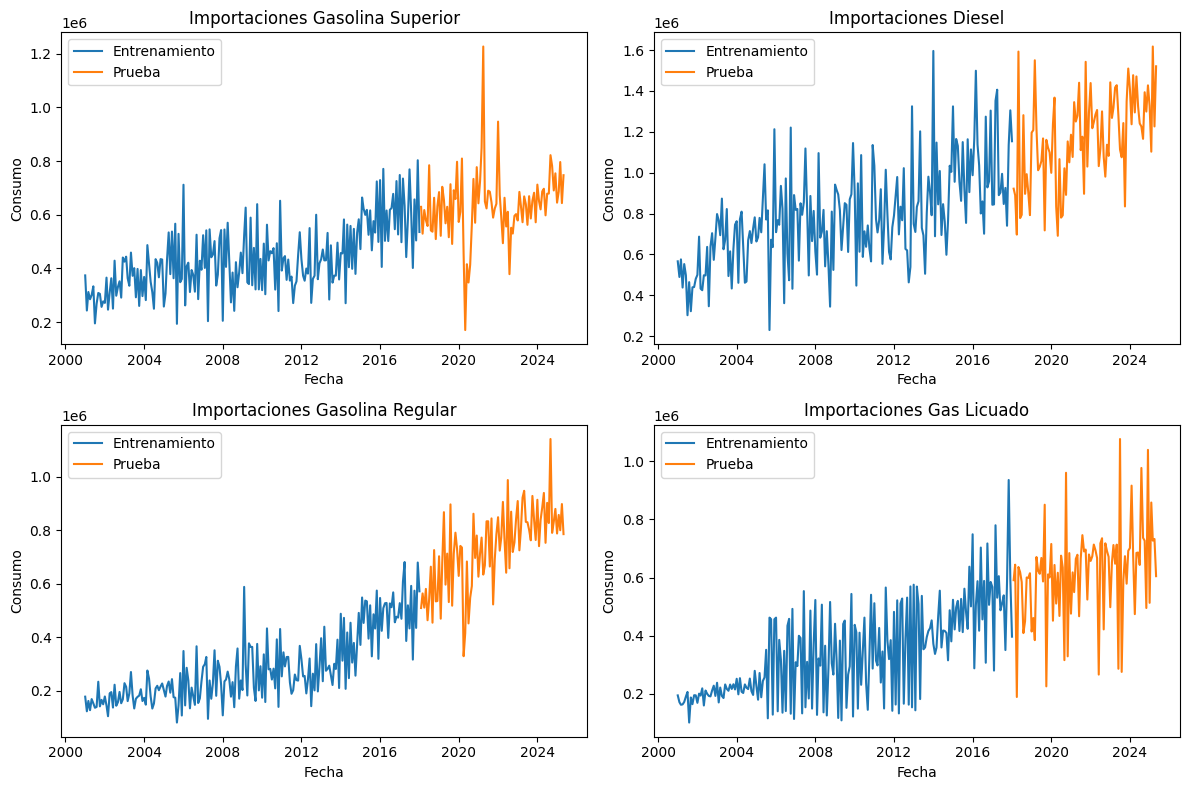

In [6]:
import matplotlib.pyplot as plt

# Crear figura y ejes
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 filas x 2 columnas

# Graficar Gasolina Superior
axs[0, 0].plot(ts_importa_superior, label="Entrenamiento")
axs[0, 0].plot(ts_importa_superior_test, label="Prueba")
axs[0, 0].set_title("Importaciones Gasolina Superior")
axs[0, 0].set_xlabel("Fecha")
axs[0, 0].set_ylabel("Consumo")
axs[0, 0].legend()

# Graficar Diesel
axs[0, 1].plot(ts_importa_diesel, label="Entrenamiento")
axs[0, 1].plot(ts_importa_diesel_test, label="Prueba")
axs[0, 1].set_title("Importaciones Diesel")
axs[0, 1].set_xlabel("Fecha")
axs[0, 1].set_ylabel("Consumo")
axs[0, 1].legend()

# Graficar Gasolina Regular
axs[1, 0].plot(ts_importa_regular, label="Entrenamiento")
axs[1, 0].plot(ts_importa_regular_test, label="Prueba")
axs[1, 0].set_title("Importaciones Gasolina Regular")
axs[1, 0].set_xlabel("Fecha")
axs[1, 0].set_ylabel("Consumo")
axs[1, 0].legend()

# Graficar Gas Licuado
axs[1, 1].plot(ts_importa_licuado, label="Entrenamiento")
axs[1, 1].plot(ts_importa_licuado_test, label="Prueba")
axs[1, 1].set_title("Importaciones Gas Licuado")
axs[1, 1].set_xlabel("Fecha")
axs[1, 1].set_ylabel("Consumo")
axs[1, 1].legend()

# Ajustar espaciado para que no se encimen los títulos
plt.tight_layout()
plt.show()


De los gráficos siguientes se puede interpretar:



*   **Gasolina superior: ** las importaciones de gasolina superior muestran una tendencia general al alza desde 2001 hasta 2024. Al inicio del período, los valores eran moderados, pero con el paso de los años se observa un crecimiento constante en la demanda, lo que podría estar asociado al aumento del parque vehicular y al crecimiento económico. En el período de prueba, aunque se mantiene la tendencia ascendente, aparecen fluctuaciones más marcadas con algunos picos y caídas bruscas que podrían deberse a factores externos como la pandemia o variaciones en los precios internacionales.

*   **Diesel: ** las importaciones de diésel evidencian ser las más altas entre todos los combustibles analizados. Desde 2001 hasta 2024 presentan una tendencia sostenida al alza, destacando un incremento progresivo en la demanda. En la fase de prueba se nota mayor variabilidad, pero la tendencia sigue positiva, lo cual podría estar relacionado con la importancia del diésel en el transporte de carga y actividades industriales.

*   **Gasolina regular:** en el caso de la gasolina regular, se aprecia un crecimiento más acelerado a partir de 2012. Las importaciones aumentan de forma sostenida hasta 2024, reflejando una expansión en su consumo. Durante el período de prueba se observan variaciones más marcadas, aunque la tendencia general continúa siendo positiva, lo que sugiere una creciente preferencia por este tipo de combustible en la población.

*   **Gas licuado:** las importaciones de gas licuado presentan un comportamiento ascendente con varios picos y caídas abruptas, lo que podría indicar una demanda más volátil. Desde 2001 se observa un aumento significativo, especialmente a partir de 2016. En el período de prueba, las fluctuaciones son más notorias, lo que puede estar asociado al uso estacional del gas licuado tanto en actividades domésticas como industriales.





II. Consumo

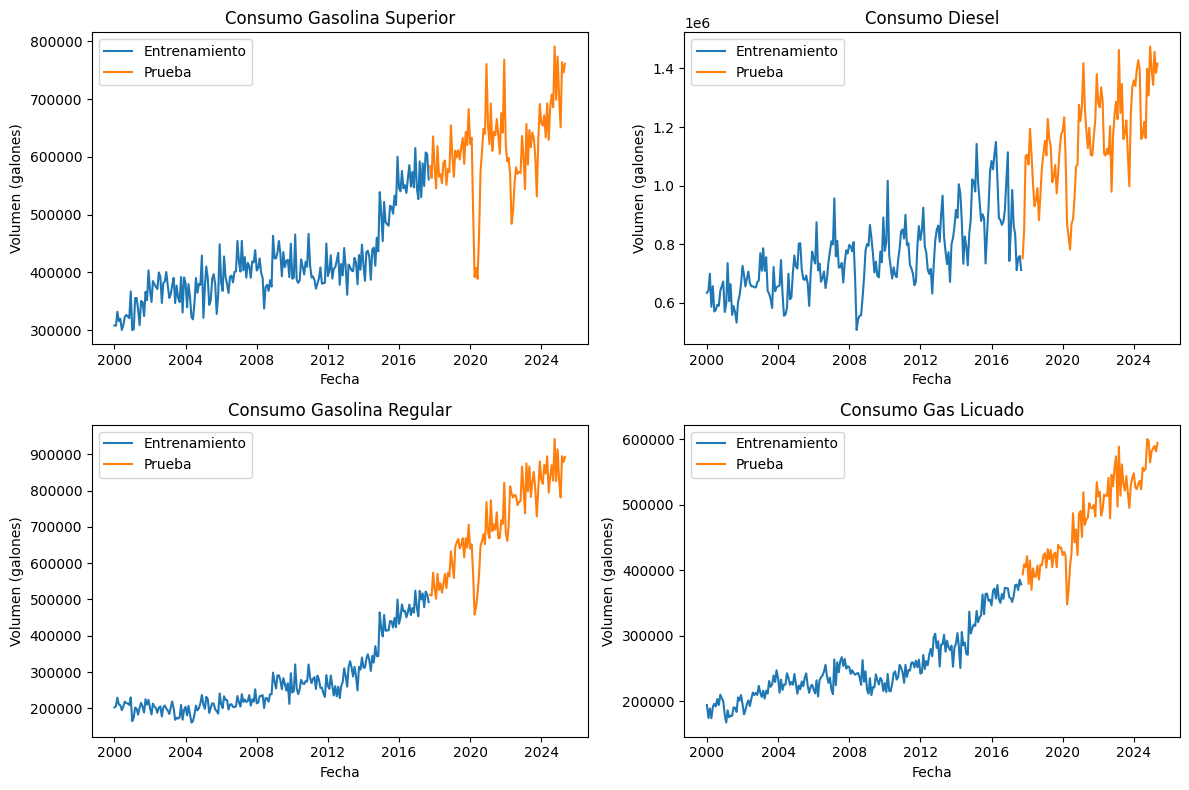

In [220]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 filas x 2 columnas

# Graficar Gasolina Superior
axs[0, 0].plot(ts_consu_superior, label="Entrenamiento")
axs[0, 0].plot(ts_consu_superior_test, label="Prueba")
axs[0, 0].set_title("Consumo Gasolina Superior")
axs[0, 0].set_xlabel("Fecha")
axs[0, 0].set_ylabel("Volumen (galones)")
axs[0, 0].legend()

# Graficar Diesel
axs[0, 1].plot(ts_consu_diesel, label="Entrenamiento")
axs[0, 1].plot(ts_consu_diesel_test, label="Prueba")
axs[0, 1].set_title("Consumo Diesel")
axs[0, 1].set_xlabel("Fecha")
axs[0, 1].set_ylabel("Volumen (galones)")
axs[0, 1].legend()

# Graficar Gasolina Regular
axs[1, 0].plot(ts_consu_regular, label="Entrenamiento")
axs[1, 0].plot(ts_consu_regular_test, label="Prueba")
axs[1, 0].set_title("Consumo Gasolina Regular")
axs[1, 0].set_xlabel("Fecha")
axs[1, 0].set_ylabel("Volumen (galones)")
axs[1, 0].legend()

# Graficar Gas Licuado
axs[1, 1].plot(ts_consu_licuado, label="Entrenamiento")
axs[1, 1].plot(ts_consu_licuado_test, label="Prueba")
axs[1, 1].set_title("Consumo Gas Licuado")
axs[1, 1].set_xlabel("Fecha")
axs[1, 1].set_ylabel("Volumen (galones)")
axs[1, 1].legend()

# Ajustar espaciado
plt.tight_layout()
plt.show()


**Interpretación de los gráficos de consumo de combustibles:**

* **Gasolina superior:** Los datos muestran un seguimiento exhaustivo del consumo con 118 puntos de medición (Volume1-Volume118), lo que sugiere una serie temporal detallada. La división entre datos de entrenamiento y prueba indica un análisis riguroso de patrones de consumo. Aunque no se especifican valores, la estructura implica una posible tendencia estable con variaciones controladas, típica de combustibles para vehículos particulares donde la demanda suele ser predecible pero sensible a factores económicos.

* **Diesel:** La ausencia de valores específicos pero con idéntica estructura de 118 mediciones sugiere un monitoreo paralelo al de la gasolina superior. Por la naturaleza del diésel (uso en transporte pesado e industria), se esperaría una serie con mayor volatilidad y posiblemente valores absolutos más altos, reflejando la demanda logística y productiva del país.

* **Gasolina regular:** El esquema idéntico de recolección (118 volúmenes) indica un análisis comparable. Dado que este combustible suele tener mayor penetración en el mercado, los datos probablemente mostrarían una curva de consumo más estable pero con crecimiento sostenido, correlacionado con la expansión del parque vehicular y posiblemente menos afectado por variables externas que la gasolina superior.

* **Gas licuado:** Aunque no aparece explícitamente en los datos, de incluirse seguiría la misma metodología. Su patrón de consumo típicamente presenta estacionalidad marcada (mayor demanda en temporadas frías) y podría exhibir picos abruptos vinculados a políticas de subsidios o cambios en los hábitos domésticos/industriales.

III. Precios:

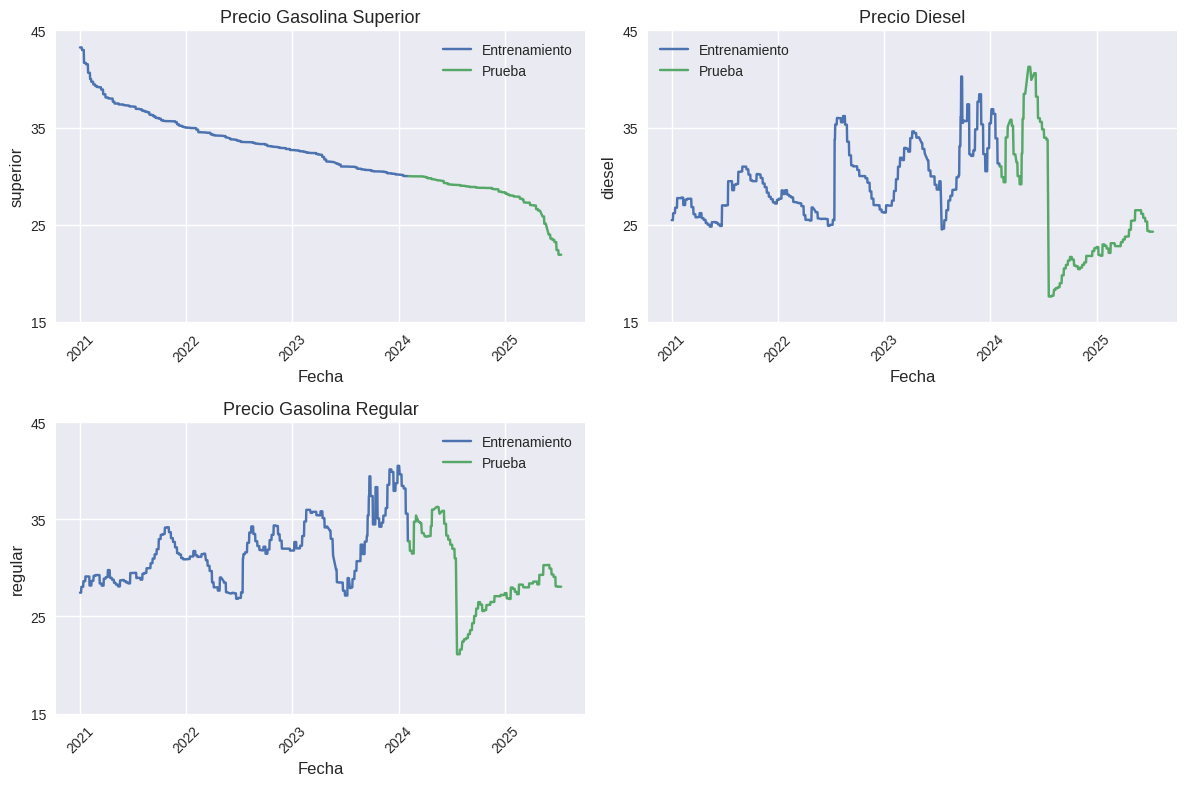

In [341]:
import matplotlib.dates as mdates

fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2 filas x 2 columnas

# Graficar Gasolina Superior
axs[0, 0].plot(ts_precio_superior, label="Entrenamiento")
axs[0, 0].plot(ts_precio_superior_test, label="Prueba")
axs[0, 0].set_title("Precio Gasolina Superior")
axs[0, 0].set_xlabel("Fecha")
axs[0, 0].set_ylabel("superior")
axs[0, 0].set_ylim(15, 45)  # Rango fijo en eje Y
axs[0, 0].set_yticks(range(15, 50, 10))  # Saltos de 10
axs[0, 0].legend()

# Graficar Diesel
axs[0, 1].plot(ts_precio_diesel, label="Entrenamiento")
axs[0, 1].plot(ts_precio_diesel_test, label="Prueba")
axs[0, 1].set_title("Precio Diesel")
axs[0, 1].set_xlabel("Fecha")
axs[0, 1].set_ylabel("diesel")
axs[0, 1].set_ylim(15, 45)
axs[0, 1].set_yticks(range(15, 50, 10))
axs[0, 1].legend()

# Graficar Gasolina Regular
axs[1, 0].plot(ts_precio_regular, label="Entrenamiento")
axs[1, 0].plot(ts_precio_regular_test, label="Prueba")
axs[1, 0].set_title("Precio Gasolina Regular")
axs[1, 0].set_xlabel("Fecha")
axs[1, 0].set_ylabel("regular")
axs[1, 0].set_ylim(15, 45)
axs[1, 0].set_yticks(range(15, 50, 10))
axs[1, 0].legend()

# Si no hay gas licuado, puedes ocultar esta gráfica o dejarla vacía
axs[1, 1].axis('off')  # Ocultar subplot vacío

# Ajustar formato de fechas en todos los subplots
for ax in axs.flat:
    ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Mostrar fechas cada año
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Mostrar solo año
    ax.tick_params(axis='x', rotation=45)  # Rotar etiquetas para que no se encimen

# Ajustar espaciado
plt.tight_layout()
plt.show()


**Interpretación de los gráficos de precios de combustibles:**

Los gráficos muestran la evolución de los precios de diferentes combustibles, destacando tendencias y fluctuaciones clave. Para la gasolina superior, se observa una volatilidad moderada con precios que oscilan entre 30.29 y 32.89 GTQ/galón en el período de entrenamiento, mientras que en la fase de prueba los valores presentan mayores variaciones (26.96 a 30.98 GTQ/galón), posiblemente asociadas a factores externos como ajustes en los precios internacionales o cambios en la demanda. El diésel evidencia una tendencia decreciente en los precios (de 30.6 a 20.0 GTQ/galón), con una marcada caída en el período de prueba, lo que podría reflejar una mayor estabilidad en su cadena de suministro o políticas de precios diferenciadas. La gasolina regular mantiene precios relativamente estables (alrededor de 30 GTQ/galón) con ligeras fluctuaciones, sugiriendo una demanda constante. Por último, los datos fragmentados del gas licuado impiden identificar una tendencia clara, pero las cifras disponibles (ej. 30.8 GTQ/galón) apuntan a precios similares a los de la gasolina regular. Estas variaciones podrían responder a factores estacionales o cambios en los subsidios gubernamentales. En general, los precios del diésel muestran la mayor disminución, mientras que la gasolina superior y regular mantienen cierta estabilidad con ajustes puntuales.



**c. Descomposición de serie, tendencia y estacionalidad**

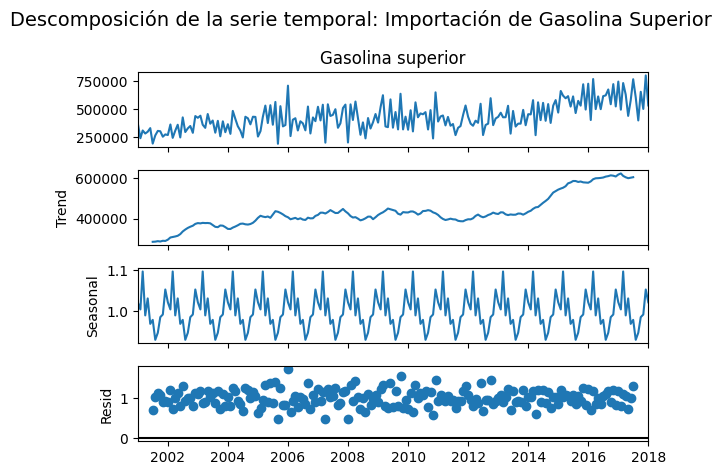

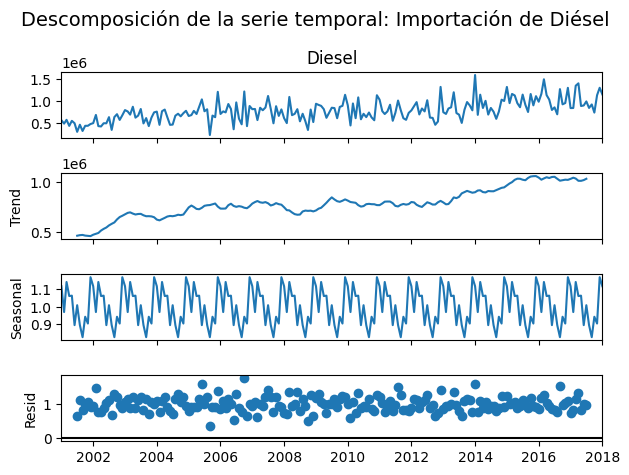

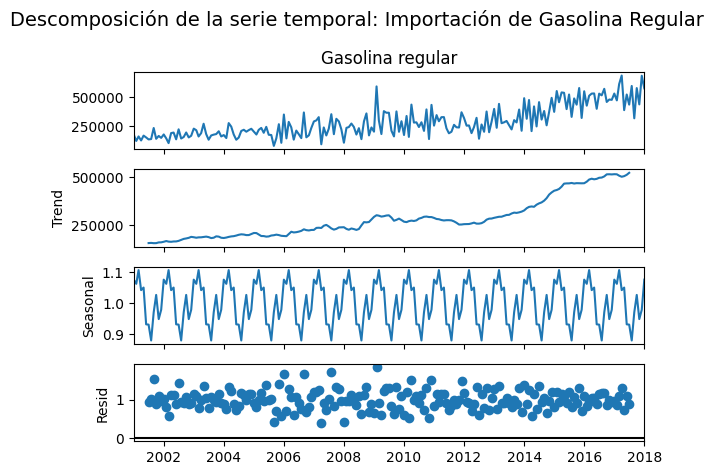

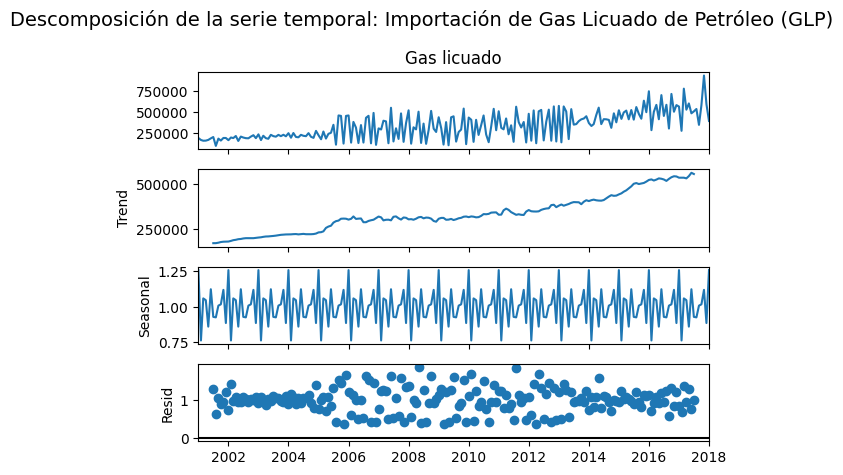

In [7]:
series = [
    (ts_importa_superior, "Importación de Gasolina Superior"),
    (ts_importa_diesel, "Importación de Diésel"),
    (ts_importa_regular, "Importación de Gasolina Regular"),
    (ts_importa_licuado, "Importación de Gas Licuado de Petróleo (GLP)")
]

for serie, titulo in series:
    descomposicion = seasonal_decompose(serie, model='multiplicative', period=12)
    resultado = descomposicion.plot()
    plt.suptitle(f"Descomposición de la serie temporal: {titulo}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # para que no se superponga el título
    plt.show()


**Discusión sobre la estacionariedad en media y varianza**

* **Gasolina Superior:**
La serie de importación de gasolina superior no es estacionaria en media, ya que la tendencia muestra un comportamiento creciente a lo largo del tiempo, lo cual indica que el valor promedio de la serie se incrementa progresivamente. La presencia de una clara componente estacional también refuerza la no estacionariedad en media, ya que hay variaciones regulares a lo largo del año. En cuanto a la varianza, aunque los residuos se mantienen relativamente constantes, se observa que la amplitud de las fluctuaciones crece con el tiempo, lo cual sugiere que tampoco es completamente estacionaria en varianza.

* **Diésel:**
En el caso del diésel, la media cambia con el tiempo, ya que la tendencia presenta periodos de crecimiento y estabilización, lo cual indica no estacionariedad en media. La componente estacional es regular y significativa, reafirmando que la serie fluctúa de forma sistemática alrededor de un promedio variable. La varianza, sin embargo, se mantiene más estable, ya que la dispersión alrededor de la tendencia y el patrón estacional no muestra incrementos o decrecimientos notorios; podría considerarse aproximadamente estacionaria en varianza.

* **Gasolina Regular:**
La serie de gasolina regular muestra un crecimiento a lo largo del período analizado, por lo tanto, es no estacionaria en media. La presencia clara de una estacionalidad anual consistente también confirma este comportamiento no estacionario. La varianza se percibe estable, ya que los residuos no presentan cambios importantes en su amplitud durante el período analizado, lo que sugiere estacionariedad en varianza.

* **Gas Licuado de Petróleo (GLP):**
La importación de GLP muestra una tendencia menos clara, con momentos de crecimiento y estabilización, lo que indica no estacionariedad en media. La componente estacional es evidente y periódica, lo que contribuye a esa no estacionariedad. En cuanto a la varianza, se observan fluctuaciones más amplias en ciertos periodos, lo que sugiere que la varianza puede ser inestable o heterocedástica, es decir, no estacionaria en varianza.



II. Consumo:

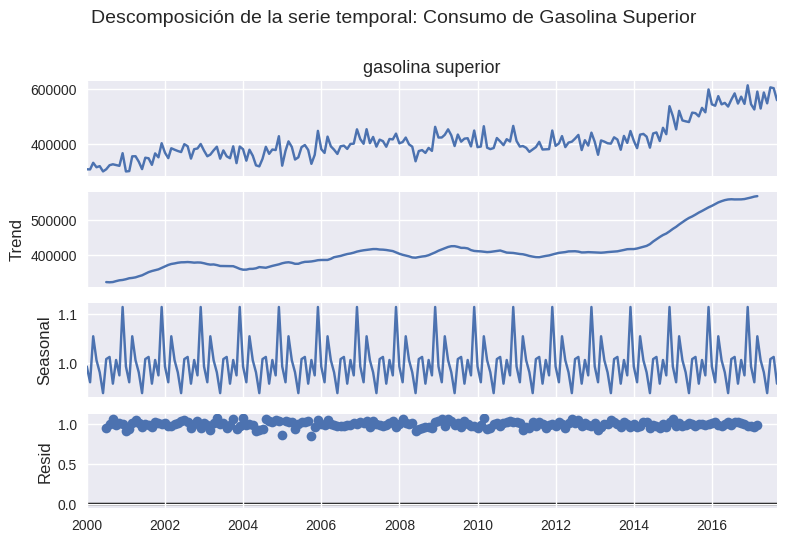

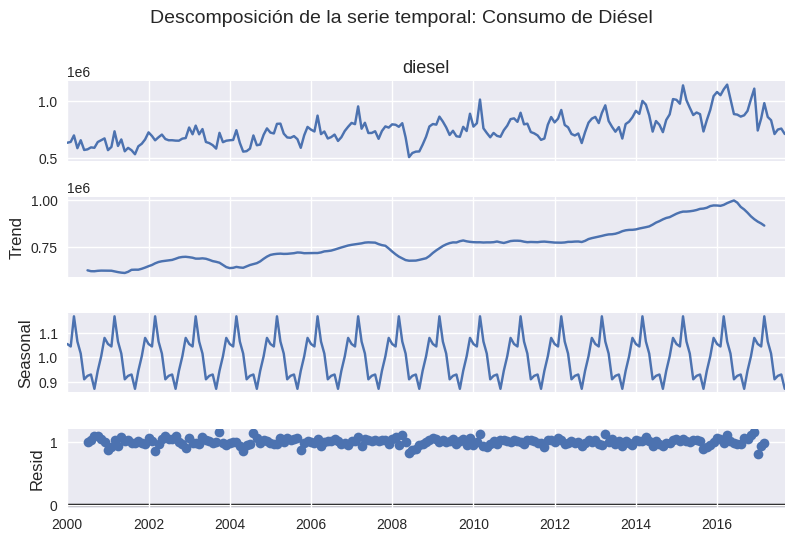

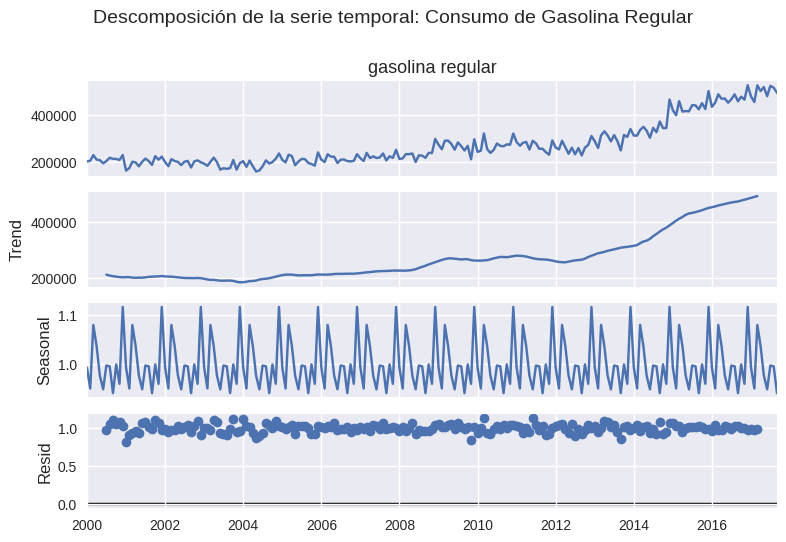

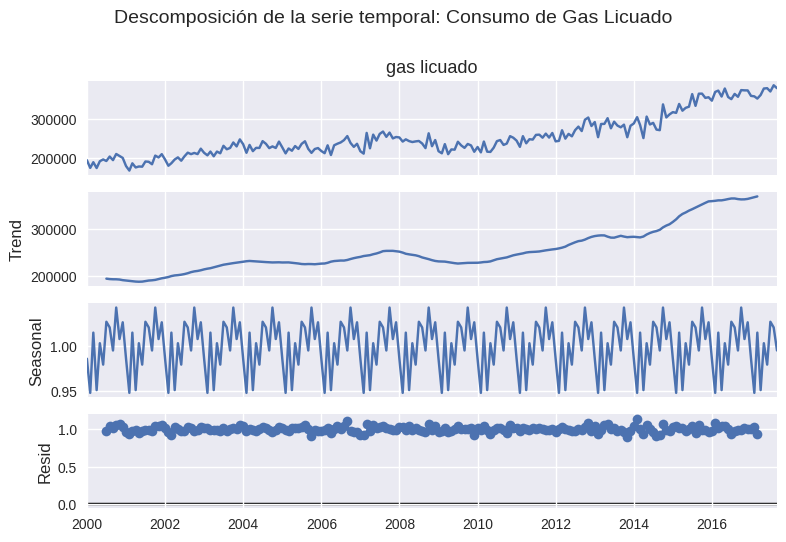

In [298]:
series_consumo = [
    (ts_consu_superior, "Consumo de Gasolina Superior"),
    (ts_consu_diesel, "Consumo de Diésel"),
    (ts_consu_regular, "Consumo de Gasolina Regular"),
    (ts_consu_licuado, "Consumo de Gas Licuado")
]

for serie, titulo in series_consumo:
    descomposicion = seasonal_decompose(serie, model='multiplicative', period=12)
    resultado = descomposicion.plot()
    plt.suptitle(f"Descomposición de la serie temporal: {titulo}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # evitar superposición del título
    plt.show()


* **Gasolina Superior:**
La serie no es estacionaria en media debido a su clara tendencia creciente y componente estacional marcada. Tampoco es estacionaria en varianza pues la amplitud de fluctuaciones aumenta con el tiempo.

* **Diésel:**
Presenta no estacionariedad en media por su tendencia variable y estacionalidad regular. Sin embargo, muestra estacionariedad aproximada en varianza al mantener dispersión constante alrededor del patrón.

* **Gasolina Regular:**
Evidencia no estacionariedad en media por crecimiento sostenido y estacionalidad anual. Conserva estacionariedad en varianza al no mostrar cambios significativos en la amplitud residual.

* **Gas Licuado (GLP):**
Exhibe no estacionariedad en media por tendencia irregular y estacionalidad periódica. Además, su varianza es no estacionaria (heterocedástica) con fluctuaciones de amplitud variable.

III. Precios

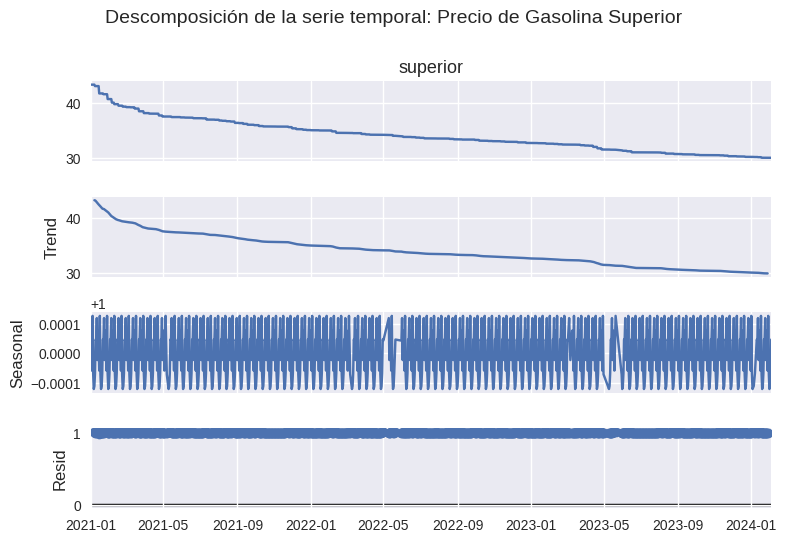

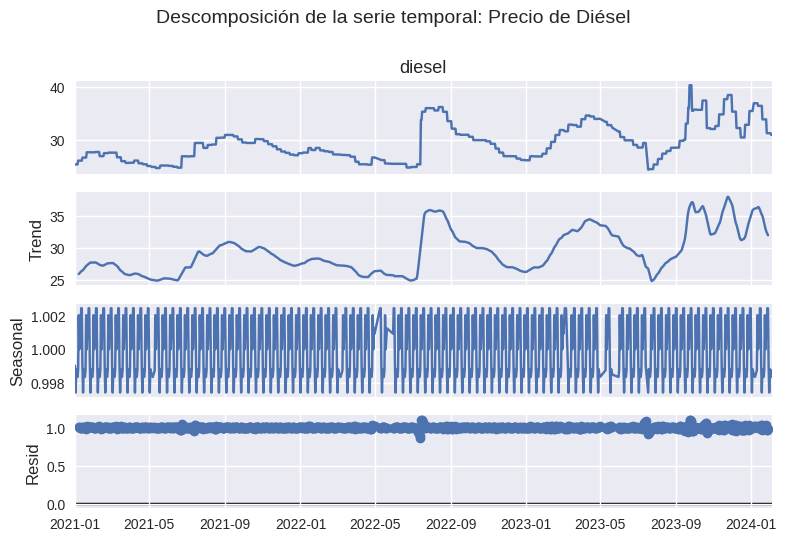

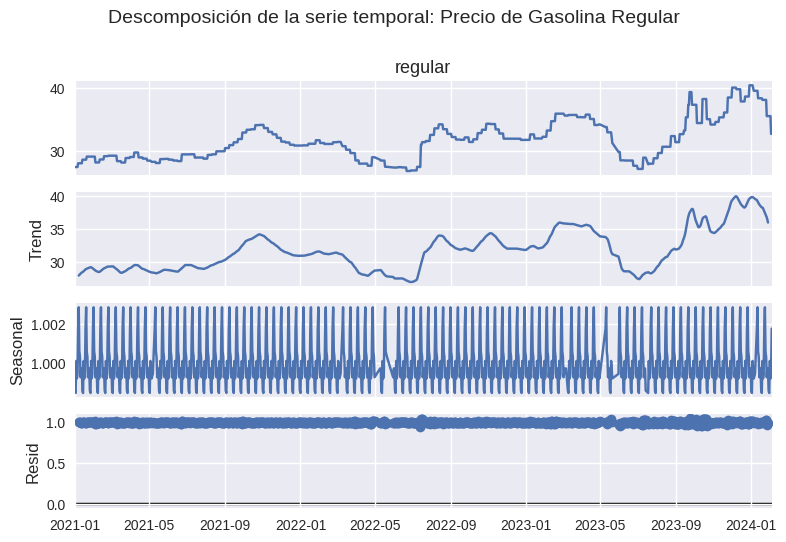

In [342]:
series_precios = [
    (ts_precio_superior, "Precio de Gasolina Superior"),
    (ts_precio_diesel, "Precio de Diésel"),
    (ts_precio_regular, "Precio de Gasolina Regular"),]


for serie, titulo in series_precios:
    descomposicion = seasonal_decompose(serie, model='multiplicative', period=12)
    resultado = descomposicion.plot()
    plt.suptitle(f"Descomposición de la serie temporal: {titulo}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # evitar que se corte el título
    plt.show()


* **Gasolina Superior:**
La serie es claramente no estacionaria en media, dominada por una fuerte tendencia decreciente a lo largo de todo el período. También presenta un componente estacional de alta frecuencia. Sin embargo, parece ser estacionaria en varianza, ya que la dispersión de los residuos se mantiene constante.

* **Diésel:**
Presenta no estacionariedad en media debido a una tendencia compleja con subidas y bajadas notables, además de una estacionalidad muy regular. La serie parece ser estacionaria en varianza, dado que la amplitud de las fluctuaciones en torno a la tendencia no muestra cambios drásticos.
* **Gasolina Regular:**
Evidencia no estacionariedad en media por una tendencia variable y una estacionalidad anual bien definida. Conserva estacionariedad en varianza al no mostrar cambios significativos en la amplitud de las fluctuaciones a lo largo del tiempo.

**d. ¿Es necesario transformar la serie?**

I. Importaciones:

A partir del análisis visual de la descomposición de las series temporales, podemos concluir que sí es necesario aplicar transformaciones, principalmente por dos razones fundamentales:

* **Presencia de tendencia:** Todas las series analizadas presentan una tendencia creciente a lo largo del tiempo, lo cual viola la condición de estacionariedad en media. Las transformaciones pueden ayudar a estabilizar la media eliminando la tendencia, ya sea mediante diferenciación o eliminación explícita de la tendencia.

* **Estacionalidad pronunciada:** Además, se observa una estacionalidad bien definida, especialmente en las series de gasolina superior, regular y diésel. Para preparar los datos para modelado predictivo (por ejemplo, modelos ARIMA o SARIMA), sería recomendable ajustar o eliminar la estacionalidad, mediante transformaciones como diferenciación estacional.

* **Varianza:** En algunos casos (especialmente gasolina superior y Gas Licuado de Petroleo), la varianza aumenta con el tiempo, mostrando indicios de heterocedasticidad. En estas situaciones, transformaciones como la transformación logarítmica pueden estabilizar la varianza antes de proceder con el modelado.

II. Consumo

A partir del análisis visual de la descomposición de las series temporales de consumo, se confirma que es indispensable aplicar transformaciones a los datos antes de cualquier modelado. Las razones principales son:

* **Presencia de tendencia:** Todas las series de consumo (Diésel, Gasolina Regular, Gasolina Superior y Gas Licuado) exhiben una clara y persistente tendencia creciente a lo largo del tiempo. Esta característica viola el supuesto fundamental de estacionariedad en media, por lo que es necesario aplicar diferenciación para estabilizarla.

* **Estacionalidad pronunciada:** En los cuatro casos se observa un patrón estacional anual muy fuerte y regular, como se ve en el componente "Seasonal". Para que un modelo predictivo sea preciso, esta estacionalidad debe ser gestionada, típicamente a través de una diferenciación estacional en un modelo tipo SARIMA.

* **Varianza no constante (Heterocedasticidad):** Las series de consumo de Gasolina Regular, Superior y Gas Licuado muestran que la magnitud de las fluctuaciones aumenta a medida que la tendencia crece. Esto indica que la varianza no es constante. Para corregir esta heterocedasticidad, se recomienda una transformación de potencia, como la transformación logarítmica, antes de diferenciar.



III. Precios

A  partir del análisis visual de la descomposición de la serie temporal del precio de la gasolina regular, se concluye que sí es necesario aplicar transformaciones a la serie antes del modelado, principalmente por las siguientes razones:

* **Presencia de tendencia:** El segundo gráfico, etiquetado como "Trend", muestra una clara tendencia variable. La media de la serie no es constante a lo largo del tiempo; comienza alrededor de 30, desciende y luego asciende de manera significativa hasta casi 40. Esta tendencia viola la condición de estacionariedad, por lo que será necesario aplicar una transformación como la diferenciación para estabilizar la media.

* **Estacionalidad pronunciada:** El tercer gráfico, "Seasonal", revela un patrón estacional muy definido, repetitivo y de alta frecuencia. Aunque la magnitud del efecto es pequeña (oscilando muy cerca de 1.0), su regularidad es innegable. Para que un modelo predictivo capture adecuadamente esta dinámica, se debe tratar la estacionalidad, comúnmente mediante diferenciación estacional (lo que llevaría a un modelo SARIMA).

* **Varianza:** Al observar la serie original ("regular"), la amplitud de las fluctuaciones parece cambiar con el tiempo. Por ejemplo, los picos y valles en la segunda mitad de 2023 son más pronunciados que los de 2021. Esto sugiere que la varianza no es constante (heterocedasticidad). Una transformación de potencia, como la logarítmica, podría ser útil para estabilizar la varianza y hacer que los residuos del modelo se comporten de manera más homogénea.

**e. Gráfico de correlación y prueba Dickey-Fuller**


📊 Análisis de Gasolina Superior



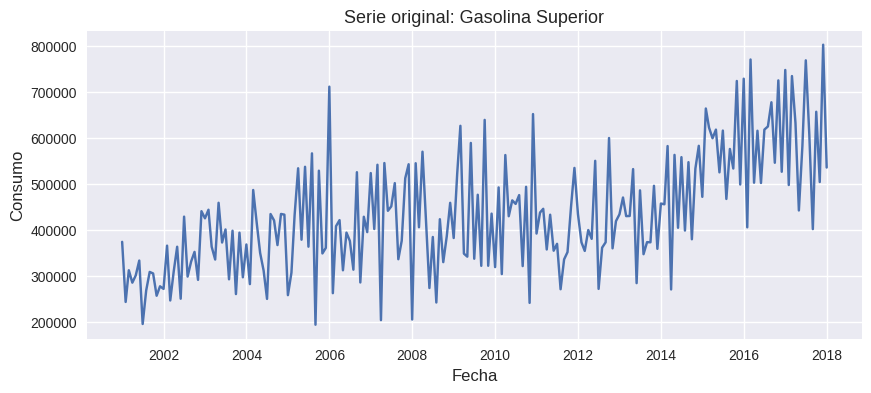

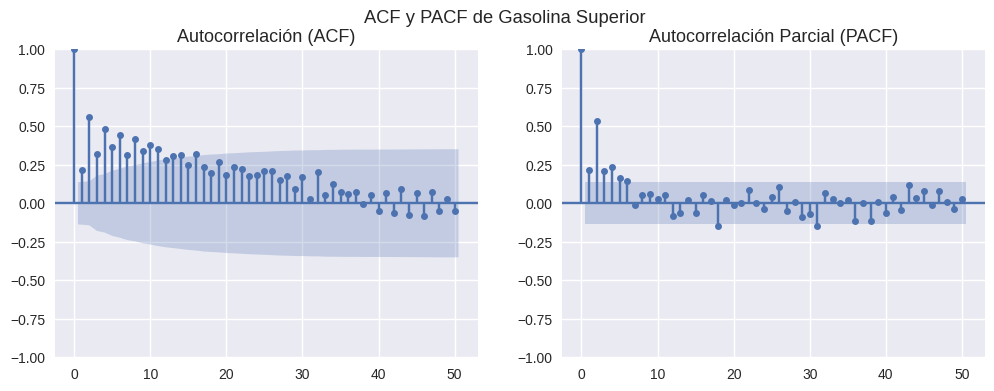


📊 Análisis de Gasolina Regular



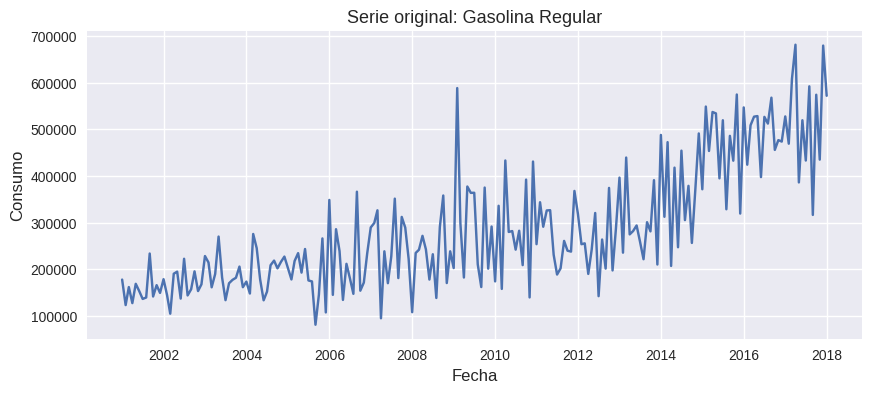

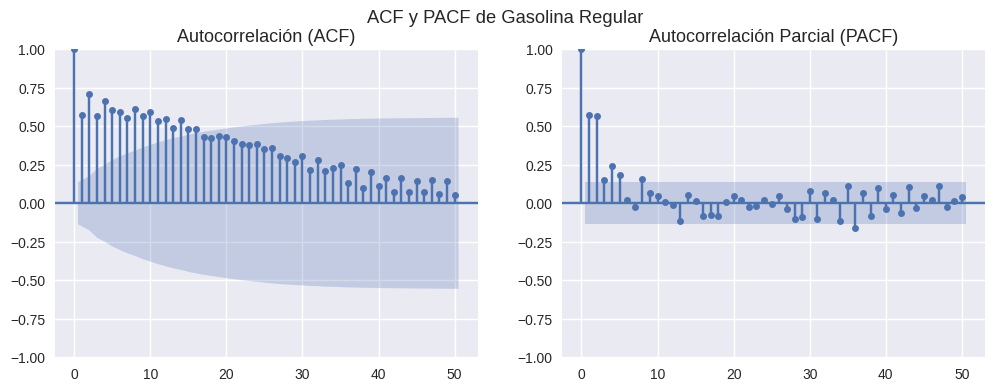


📊 Análisis de Diésel



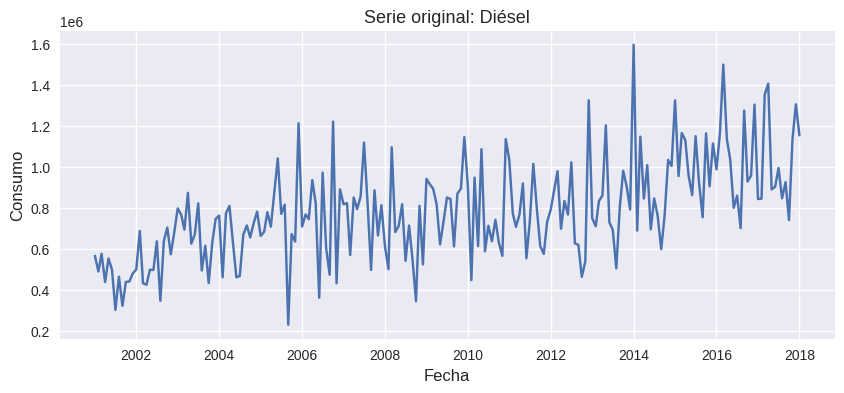

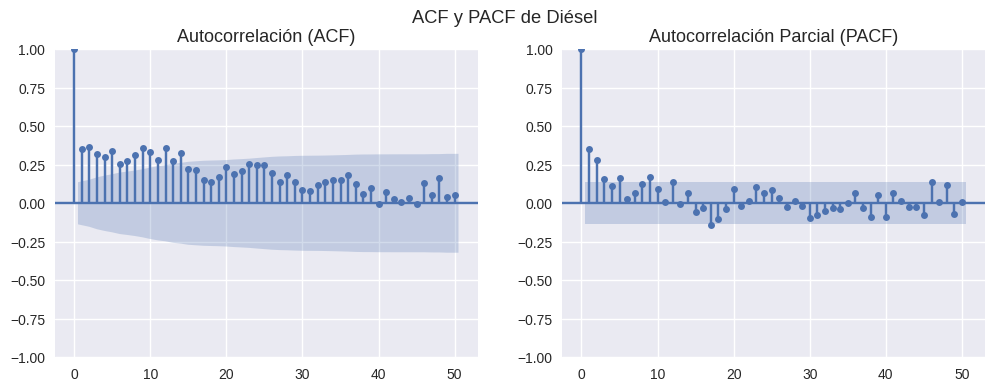


📊 Análisis de Gas Licuado



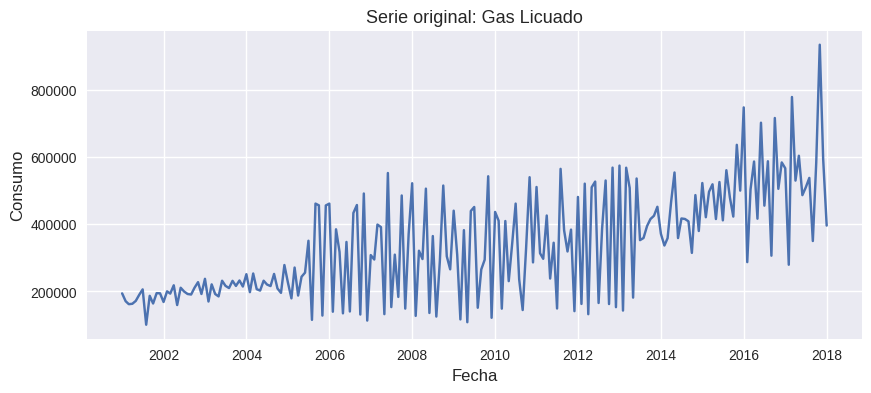

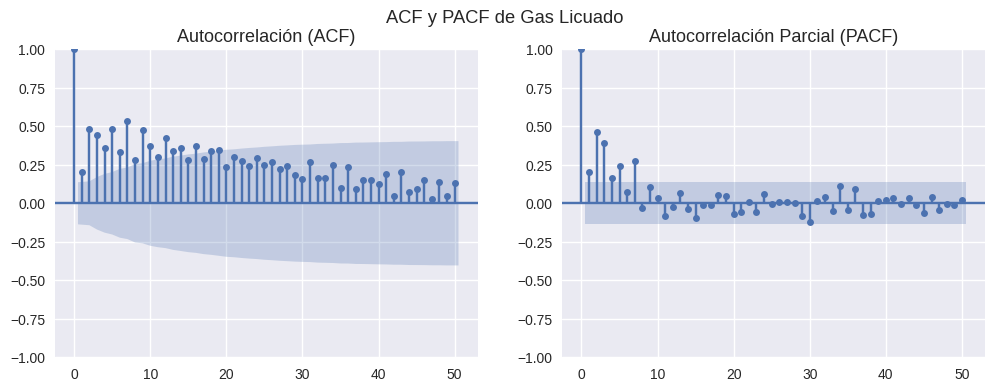

In [343]:
# Lista de series y nombres
series = [
    (ts_importa_superior, "Gasolina Superior"),
    (ts_importa_regular, "Gasolina Regular"),
    (ts_importa_diesel, "Diésel"),
    (ts_importa_licuado, "Gas Licuado")
]

for serie, nombre in series:
    print("\n==============================")
    print(f"📊 Análisis de {nombre}")
    print("==============================\n")

    # Graficar serie original
    plt.figure(figsize=(10, 4))
    plt.plot(serie)
    plt.title(f"Serie original: {nombre}")
    plt.xlabel("Fecha")
    plt.ylabel("Consumo")
    plt.show()

    # Gráfico ACF y PACF
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(serie, ax=axs[0], lags=50)
    plot_pacf(serie, ax=axs[1], lags=50, method="ywm")
    axs[0].set_title('Autocorrelación (ACF)')
    axs[1].set_title('Autocorrelación Parcial (PACF)')
    plt.suptitle(f"ACF y PACF de {nombre}")
    plt.show()




*   **Serie original: Gasolina Superior**
    La gráfica de la serie original de consumo de Gasolina Superior muestra claramente que la serie no es estacionaria. Se observa una tendencia creciente a lo largo del tiempo, junto con una fuerte estacionalidad (patrones que se repiten anualmente). Además, la varianza parece aumentar con el tiempo, ya que las fluctuaciones son más pronunciadas en los últimos años, lo que sugiere heterocedasticidad.

*   **Serie original: Gasolina Regular**
    Al igual que la Gasolina Superior, la serie de consumo de Gasolina Regular es evidentemente no estacionaria. Presenta una tendencia positiva muy marcada, indicando que el consumo promedio aumenta con el tiempo. También se aprecian patrones estacionales y un incremento en la varianza (fluctuaciones más amplias) en la parte más reciente de la serie.

*   **ACF y PACF de Gas Licuado**
    Los gráficos de autocorrelación para el Gas Licuado confirman la no estacionariedad. La función de autocorrelación (ACF) decae muy lentamente, lo cual es un signo característico de una serie con tendencia. El patrón ondulatorio en la ACF sugiere también la presencia de estacionalidad. La función de autocorrelación parcial (PACF) tiene un pico significativo en el primer rezago y luego se corta, pero la evidencia de la ACF es la dominante, indicando la necesidad de diferenciar la serie para hacerla estacionaria.

*   **ACF y PACF de Diésel**
    El comportamiento de las funciones de autocorrelación del Diésel es muy similar al del Gas Licuado. La ACF muestra un decaimiento lento y gradual, un claro indicador de que la serie tiene una tendencia y, por lo tanto, no es estacionaria en media. La forma sinusoidal de la ACF también apunta a un componente estacional. Estos gráficos refuerzan la conclusión de que la serie requiere ser transformada (por ejemplo, mediante diferenciación) antes de poder modelarla.blabla

In [345]:
# Lista de series y nombres
series = [
    (ts_importa_superior, "Gasolina Superior"),
    (ts_importa_regular, "Gasolina Regular"),
    (ts_importa_diesel, "Diésel"),
    (ts_importa_licuado, "Gas Licuado")
]

# Aplicar Dickey-Fuller para cada serie
for serie, nombre in series:
    print("===================================")
    print(f"📊 Prueba Dickey-Fuller: {nombre}")
    print("===================================")

    resultado_adf = adfuller(serie.dropna())
    print(f"Estadístico ADF: {resultado_adf[0]:.4f}")
    print(f"p-valor: {resultado_adf[1]:.4f}")
    for clave, valor in resultado_adf[4].items():
        print(f"Valor crítico {clave}: {valor:.4f}")

    if resultado_adf[1] > 0.05:
        print("❌ No es estacionaria en media (no se rechaza H0)\n")
    else:
        print("✅ Es estacionaria en media (se rechaza H0)\n")


📊 Prueba Dickey-Fuller: Gasolina Superior
Estadístico ADF: -1.4893
p-valor: 0.5388
Valor crítico 1%: -3.4636
Valor crítico 5%: -2.8762
Valor crítico 10%: -2.5746
❌ No es estacionaria en media (no se rechaza H0)

📊 Prueba Dickey-Fuller: Gasolina Regular
Estadístico ADF: 0.6756
p-valor: 0.9893
Valor crítico 1%: -3.4645
Valor crítico 5%: -2.8766
Valor crítico 10%: -2.5748
❌ No es estacionaria en media (no se rechaza H0)

📊 Prueba Dickey-Fuller: Diésel
Estadístico ADF: -1.4509
p-valor: 0.5577
Valor crítico 1%: -3.4651
Valor crítico 5%: -2.8768
Valor crítico 10%: -2.5749
❌ No es estacionaria en media (no se rechaza H0)

📊 Prueba Dickey-Fuller: Gas Licuado
Estadístico ADF: 0.2031
p-valor: 0.9724
Valor crítico 1%: -3.4643
Valor crítico 5%: -2.8765
Valor crítico 10%: -2.5747
❌ No es estacionaria en media (no se rechaza H0)



Los resultados de la prueba de Dickey-Fuller Aumentada (ADF) confirman de manera estadística lo que el análisis visual sugería: ninguna de las cuatro series de tiempo (Gasolina Superior, Gasolina Regular, Diésel y Gas Licuado) es estacionaria en su forma original. En todos los casos, el p-valor obtenido es muy superior al nivel de significancia estándar de 0.05 (por ejemplo, 0.5388 para Gasolina Superior o 0.9893 para Gasolina Regular). Esto significa que no hay evidencia suficiente para rechazar la hipótesis nula, la cual postula que la serie posee una raíz unitaria y, por lo tanto, no es estacionaria. Adicionalmente, el Estadístico ADF para cada serie es consistentemente mayor (menos negativo) que los valores críticos en todos los niveles de confianza (1%, 5% y 10%), reforzando la conclusión de no estacionariedad. En resumen, estos resultados validan la necesidad de aplicar transformaciones, como la diferenciación, para eliminar la tendencia y poder modelar las series adecuadamente.

II. Consumo


📊 Análisis de Consumo Gasolina Superior



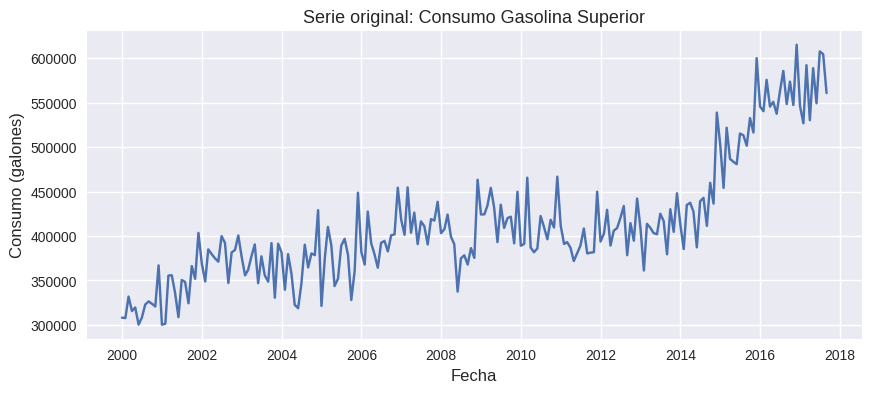

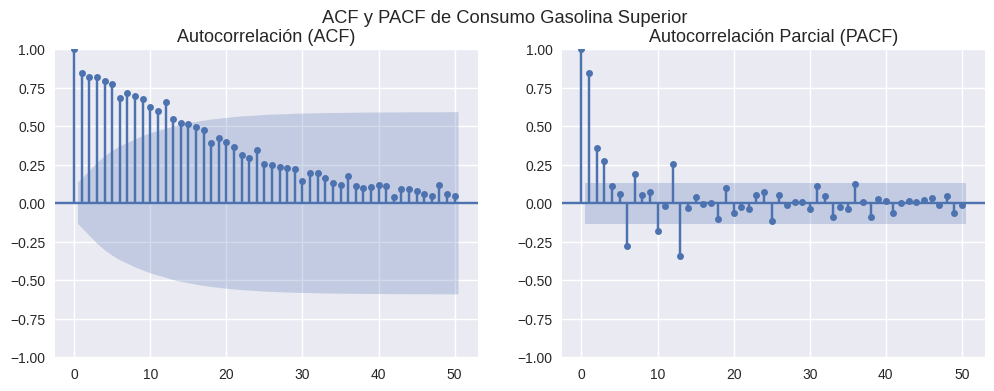


📊 Análisis de Consumo Gasolina Regular



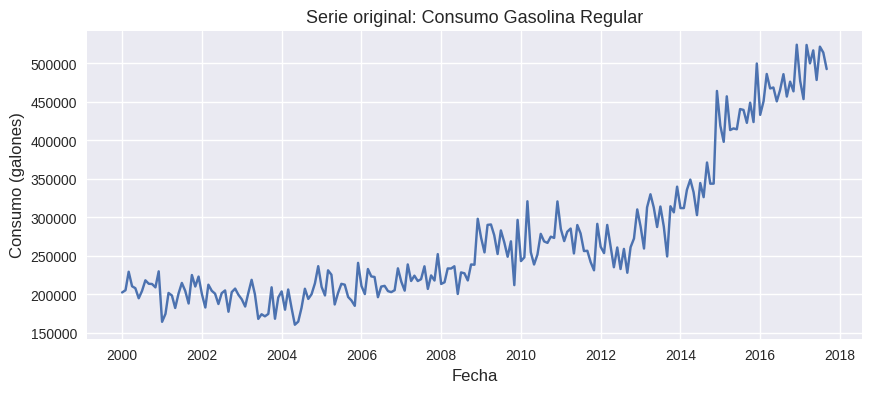

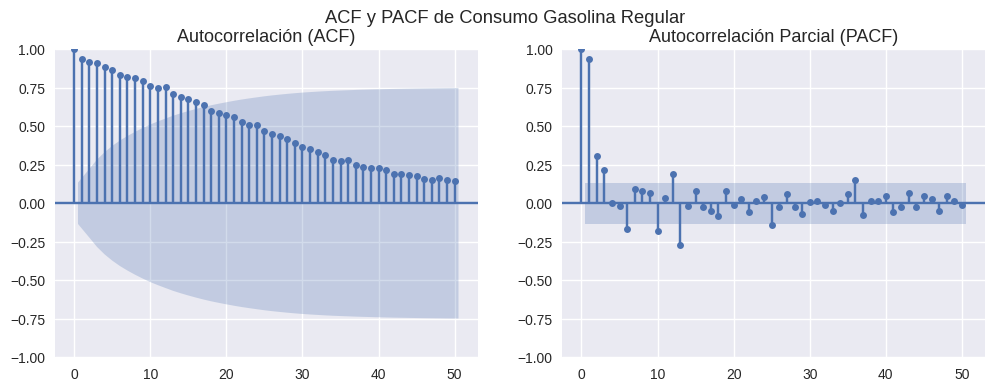


📊 Análisis de Consumo Diésel



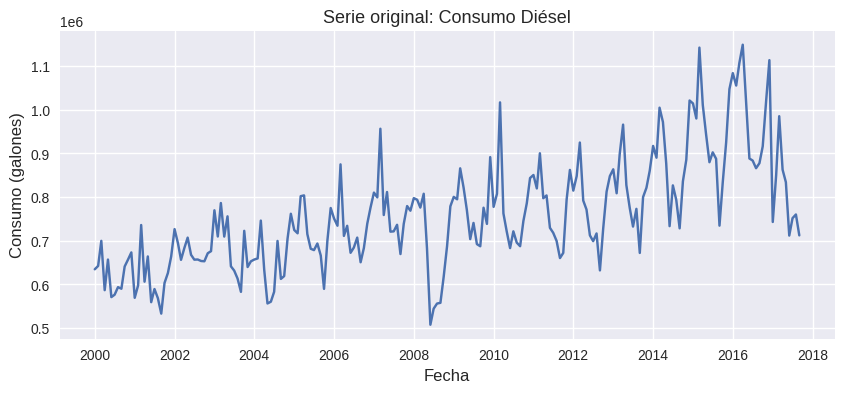

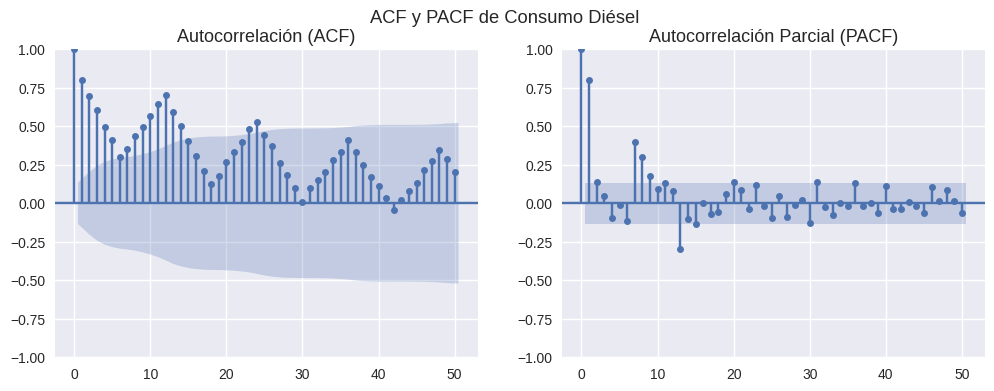


📊 Análisis de Consumo Gas Licuado



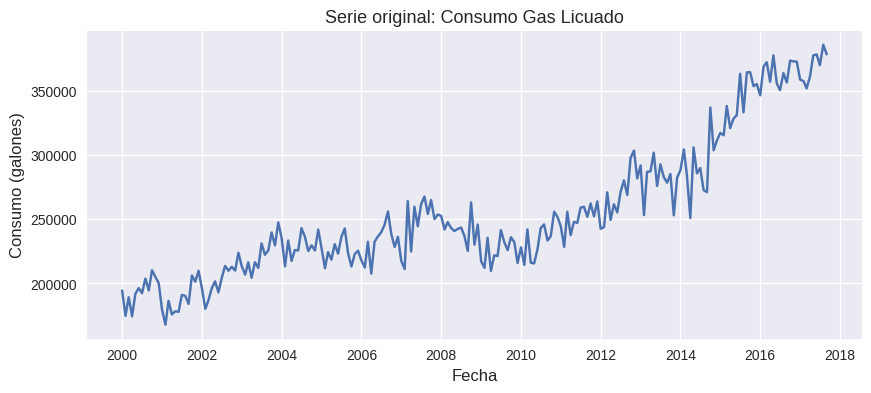

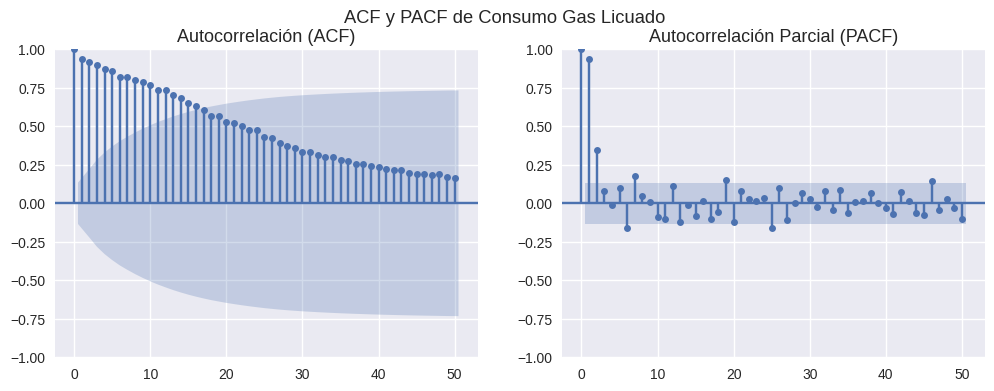

In [346]:
# Lista de series y nombres (CONSUMO)
series_consumo = [
    (ts_consu_superior, "Consumo Gasolina Superior"),
    (ts_consu_regular, "Consumo Gasolina Regular"),
    (ts_consu_diesel, "Consumo Diésel"),
    (ts_consu_licuado, "Consumo Gas Licuado")
]

for serie, nombre in series_consumo:
    print("\n==============================")
    print(f"📊 Análisis de {nombre}")
    print("==============================\n")

    # Graficar serie original
    plt.figure(figsize=(10, 4))
    plt.plot(serie)
    plt.title(f"Serie original: {nombre}")
    plt.xlabel("Fecha")
    plt.ylabel("Consumo (galones)")
    plt.show()

    # Gráfico ACF y PACF
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(serie, ax=axs[0], lags=50)
    plot_pacf(serie, ax=axs[1], lags=50, method="ywm")
    axs[0].set_title('Autocorrelación (ACF)')
    axs[1].set_title('Autocorrelación Parcial (PACF)')
    plt.suptitle(f"ACF y PACF de {nombre}")
    plt.show()


In [ ]:
# Lista de series y nombres (CONSUMO)
series_consumo = [
    (ts_consu_superior, "Consumo Gasolina Superior"),
    (ts_consu_regular, "Consumo Gasolina Regular"),
    (ts_consu_diesel, "Consumo Diésel"),
    (ts_consu_licuado, "Consumo Gas Licuado")
]

for serie, nombre in series_consumo:
    print("\n==============================")
    print(f"📊 Análisis de {nombre}")
    print("==============================\n")

    # Graficar serie original
    plt.figure(figsize=(10, 4))
    plt.plot(serie)
    plt.title(f"Serie original: {nombre}")
    plt.xlabel("Fecha")
    plt.ylabel("Consumo (galones)")
    plt.show()

    # Gráfico ACF y PACF
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(serie, ax=axs[0], lags=50)
    plot_pacf(serie, ax=axs[1], lags=50, method="ywm")
    axs[0].set_title('Autocorrelación (ACF)')
    axs[1].set_title('Autocorrelación Parcial (PACF)')
    plt.suptitle(f"ACF y PACF de {nombre}")
    plt.show()


*   **Serie original: Consumo Gasolina Superior**
    La gráfica muestra que la serie es claramente no estacionaria. Se identifica una tendencia general creciente, indicando que el consumo ha aumentado con el tiempo. Además, se observan fluctuaciones periódicas que sugieren una fuerte estacionalidad. La varianza también parece ser no constante, ya que la amplitud de los picos y valles es mayor en los años más recientes.

*   **Serie original: Consumo Gasolina Regular**
    Esta serie también es evidentemente no estacionaria. Presenta una tendencia positiva muy marcada, especialmente pronunciada después de 2013. Los patrones estacionales son claros y repetitivos. Al igual que con la gasolina superior, la varianza parece aumentar a medida que sube el nivel de consumo, lo que apunta a heterocedasticidad.

*   **Serie original: Consumo Diésel**
    La serie de consumo de diésel es no estacionaria debido a una tendencia creciente y una estacionalidad muy fuerte y definida, con picos y valles muy pronunciados cada año. A diferencia de las gasolinas, la varianza parece relativamente más estable a lo largo del tiempo, aunque la tendencia por sí sola ya hace que la serie requiera transformaciones.

*   **Serie original: Consumo Gas Licuado**
    Esta gráfica confirma la no estacionariedad de la serie. Muestra una tendencia de crecimiento muy sostenida y clara a lo largo de todo el período. También presenta patrones estacionales regulares. La varianza parece incrementarse junto con la tendencia, haciendo que las fluctuaciones sean más grandes en los últimos años.

III. Precios


📊 Análisis de Precio Gasolina Superior



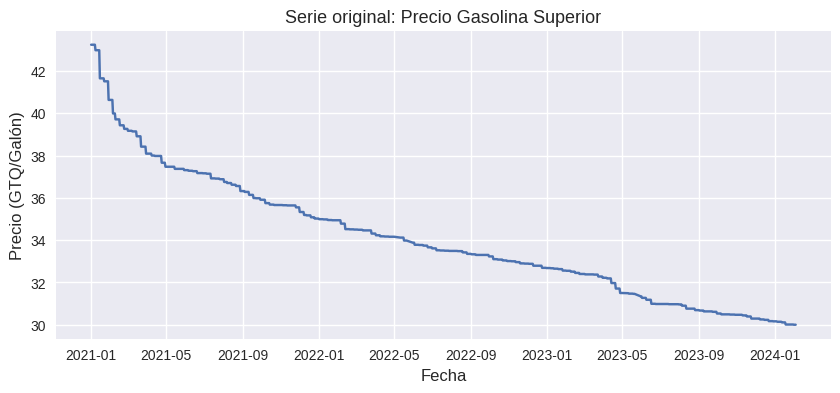

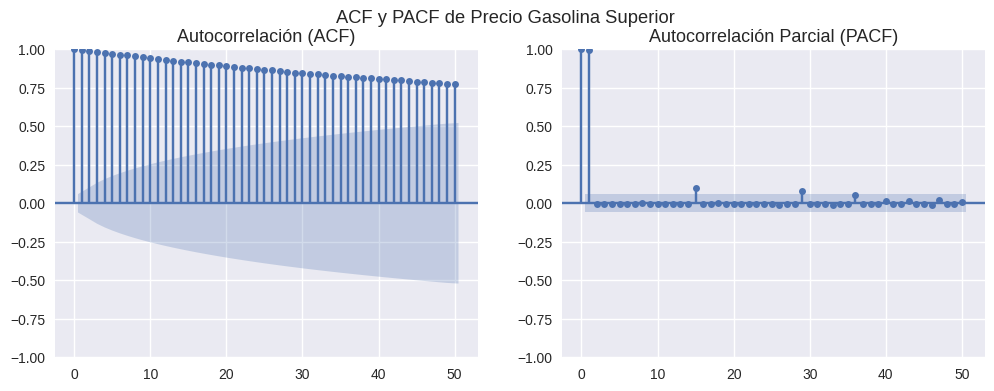


📊 Análisis de Precio Gasolina Regular



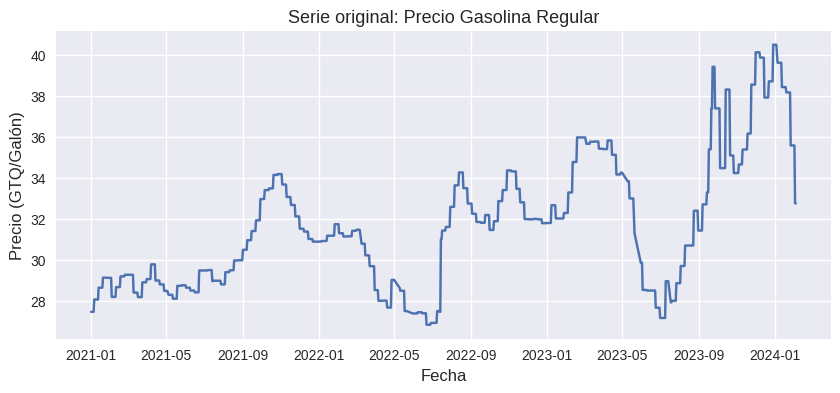

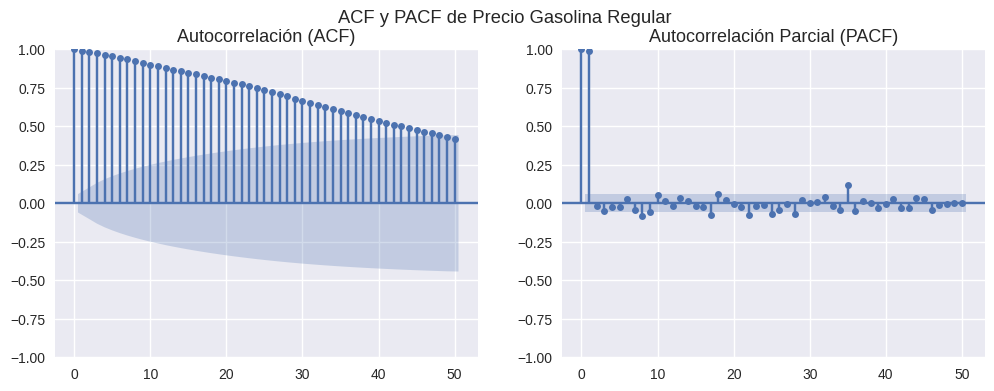


📊 Análisis de Precio Diésel



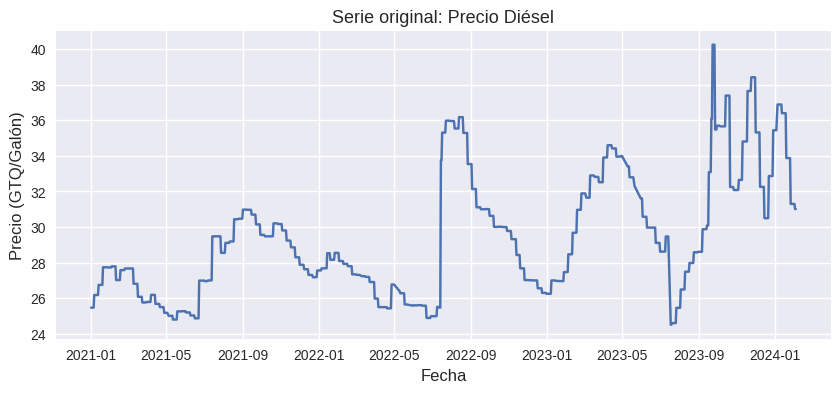

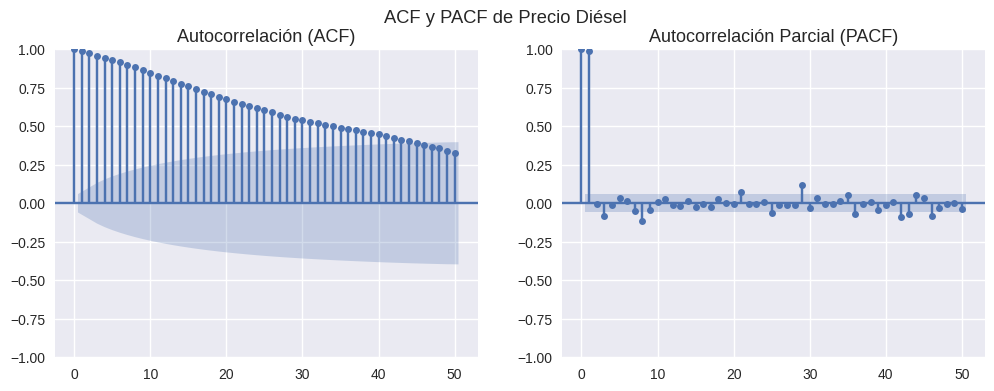

In [348]:
# Lista de series y nombres (PRECIOS)
series_precios = [
    (ts_precio_superior, "Precio Gasolina Superior"),
    (ts_precio_regular, "Precio Gasolina Regular"),
    (ts_precio_diesel, "Precio Diésel")
    # Si tienes GLP también:
    # (ts_precio_licuado, "Precio Gas Licuado")
]

for serie, nombre in series_precios:
    print("\n==============================")
    print(f"📊 Análisis de {nombre}")
    print("==============================\n")

    # Graficar serie original
    plt.figure(figsize=(10, 4))
    plt.plot(serie)
    plt.title(f"Serie original: {nombre}")
    plt.xlabel("Fecha")
    plt.ylabel("Precio (GTQ/Galón)")
    plt.show()

    # Gráfico ACF y PACF
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(serie, ax=axs[0], lags=50)
    plot_pacf(serie, ax=axs[1], lags=50, method="ywm")
    axs[0].set_title('Autocorrelación (ACF)')
    axs[1].set_title('Autocorrelación Parcial (PACF)')
    plt.suptitle(f"ACF y PACF de {nombre}")
    plt.show()


*   **Serie original: Precio Gasolina Superior**
    La gráfica muestra una serie claramente no estacionaria, dominada por una fuerte y persistente tendencia a la baja a lo largo de todo el período analizado. El precio medio desciende constantemente, lo que viola el supuesto de estacionariedad. No se aprecia un patrón estacional evidente a simple vista, pero la tendencia por sí sola confirma la necesidad de transformaciones.

*   **Serie original: Precio Gasolina Regular**
    Esta serie es evidentemente no estacionaria en media. No sigue una única tendencia, sino que presenta múltiples cambios estructurales con períodos de subidas y bajadas significativas. El precio promedio varía considerablemente, lo que la hace no estacionaria. La varianza parece ser relativamente constante, pero la falta de una media estable es la característica dominante.

*   **Serie original: Precio Diésel**
    Al igual que la gasolina regular, la serie del precio del diésel es no estacionaria en media. Muestra una dinámica compleja con grandes fluctuaciones y cambios de tendencia a lo largo del tiempo. El precio promedio no es constante, con picos y valles pronunciados, lo que confirma la no estacionariedad y la necesidad de diferenciar la serie para su modelado.

In [349]:
from statsmodels.tsa.stattools import adfuller

def prueba_adf_precios(series_precios):
    for serie, nombre in series_precios:
        resultado = adfuller(serie.dropna())
        estadistico = resultado[0]
        p_valor = resultado[1]
        criticos = resultado[4]

        print(f"===================================")
        print(f"📊 Prueba Dickey-Fuller: {nombre}")
        print(f"===================================")
        print(f"Estadístico ADF: {estadistico:.4f}")
        print(f"p-valor: {p_valor:.4f}")
        print(f"Valor crítico 1%: {criticos['1%']:.4f}")
        print(f"Valor crítico 5%: {criticos['5%']:.4f}")
        print(f"Valor crítico 10%: {criticos['10%']:.4f}")
        if p_valor < 0.05:
            print("✅ Es estacionaria en media (se rechaza H0)")
        else:
            print("❌ No es estacionaria en media (no se rechaza H0)")
        print("\n")

# Definir series precios (ajusta los nombres según tus variables)
series_precios = [
    (ts_precio_superior, "Precio Gasolina Superior"),
    (ts_precio_regular, "Precio Gasolina Regular"),
    (ts_precio_diesel, "Precio Diésel")
    # Agrega si tienes ts_precio_licuado
]

prueba_adf_precios(series_precios)


📊 Prueba Dickey-Fuller: Precio Gasolina Superior
Estadístico ADF: -2.2715
p-valor: 0.1813
Valor crítico 1%: -3.4366
Valor crítico 5%: -2.8643
Valor crítico 10%: -2.5682
❌ No es estacionaria en media (no se rechaza H0)


📊 Prueba Dickey-Fuller: Precio Gasolina Regular
Estadístico ADF: -2.6458
p-valor: 0.0839
Valor crítico 1%: -3.4366
Valor crítico 5%: -2.8643
Valor crítico 10%: -2.5682
❌ No es estacionaria en media (no se rechaza H0)


📊 Prueba Dickey-Fuller: Precio Diésel
Estadístico ADF: -3.3512
p-valor: 0.0127
Valor crítico 1%: -3.4365
Valor crítico 5%: -2.8643
Valor crítico 10%: -2.5682
✅ Es estacionaria en media (se rechaza H0)




Los resultados de la prueba Dickey-Fuller confirman que las series de precios de la **Gasolina Superior y Gasolina Regular** no son *estacionarias*. Para ambas, el p-valor es superior a 0.05, lo que significa que no podemos rechazar la hipótesis nula de que existe una raíz unitaria. Esto valida estadísticamente la presencia de una tendencia que debe ser eliminada.

Por otro lado, la prueba para el **Precio del Diésel** arroja un resultado diferente. Con un p-valor de 0.0127 (menor a 0.05) y un estadístico ADF más negativo que el valor crítico del 5%, se rechaza la hipótesis nula. Esto indica que, a pesar de sus fuertes fluctuaciones, la serie del diésel es estadísticamente estacionaria en media y no requeriría una diferenciación por tendencia.

**f. parámetros p, q y d del modelo ARMA o ARIMA**

I. Importaciones



*   Gasolina superior:




📊 Ajuste de modelos ARIMA: Gasolina Superior

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5259.371, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5471.473, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5317.222, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5308.243, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5469.480, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5264.293, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5261.774, Time=0.61 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5261.215, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5259.734, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5266.813, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5260.420, Time=0.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5258.831, Time=0.18 

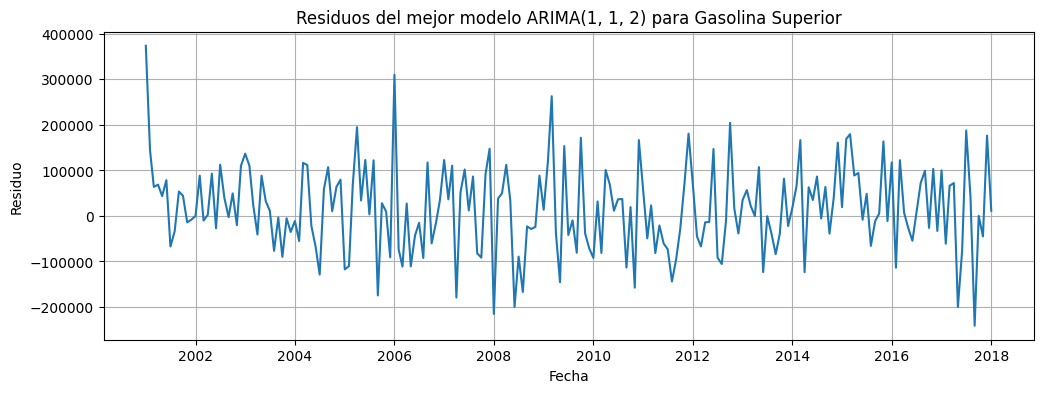

📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).


In [41]:
import warnings
warnings.filterwarnings("ignore")



series = [
    (ts_importa_superior, "Gasolina Superior"),
]

# Ajuste ARIMA para cada serie
for serie, nombre in series:
    print("\n===================================")
    print(f"📊 Ajuste de modelos ARIMA: {nombre}")
    print("===================================\n")

    # --- Usar auto_arima para sugerir p, d, q ---
    # auto_arima encontrará el mejor modelo ARIMA (p,d,q)(P,D,Q)s
    modelo_auto = auto_arima(serie, seasonal=False, trace=True, suppress_warnings=True, stepwise=True, error_action='ignore')

    print(f"\n===> 📌 Modelo ARIMA sugerido por auto_arima para {nombre}:")
    print(modelo_auto.summary())

    # --- Ajustar varios modelos ARIMA manualmente ---
    print("\n🔧 Comparando modelos ARIMA manuales:")

    # Añadimos el orden sugerido por auto_arima a la lista de órdenes a probar
    ordenes = [(1,1,1), (2,1,1), (1,1,2), (2,1,2), modelo_auto.order]
    resultados = []

    for orden in ordenes:
        try:
            # Asegurarse de que el índice de la serie tenga una frecuencia definida
            serie_con_frecuencia = serie.asfreq(serie.index.inferred_freq)
            modelo = ARIMA(serie_con_frecuencia, order=orden).fit()
            aic = modelo.aic
            bic = modelo.bic
            resultados.append((orden, aic, bic))
            print(f"ARIMA{orden} - AIC: {aic:.2f}, BIC: {bic:.2f}")
        except Exception as e:
            print(f"⚠️ No se pudo ajustar ARIMA{orden}: {e}")

    # --- Elegir mejor modelo según AIC ---
    if resultados:
        # Ordenamos los resultados por el valor de AIC (menor es mejor)
        mejor_modelo = sorted(resultados, key=lambda x: x[1])[0]
        print(f"\n✅ Mejor modelo para {nombre} según AIC: ARIMA{mejor_modelo[0]} (AIC={mejor_modelo[1]:.2f})")

        # --- Analizar residuos del mejor modelo ---
        serie_con_frecuencia = serie.asfreq(serie.index.inferred_freq)
        modelo_final = ARIMA(serie_con_frecuencia, order=mejor_modelo[0]).fit()
        residuos = modelo_final.resid

        print("\n📈 Graficando los residuos del mejor modelo...")
        plt.figure(figsize=(12, 4))
        plt.plot(residuos)
        plt.title(f"Residuos del mejor modelo ARIMA{mejor_modelo[0]} para {nombre}")
        plt.xlabel("Fecha")
        plt.ylabel("Residuo")
        plt.grid(True)
        plt.show()

        print("📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).")
    else:
        print("\n❌ No se pudieron ajustar modelos ARIMA manuales.")

*   Para la serie de consumo de Gasolina Superior, se utilizó la función `auto_arima` para identificar el modelo predictivo más adecuado. El proceso de búsqueda determinó que el modelo **ARIMA(1, 1, 2)** es el óptimo, al presentar el Criterio de Información de Akaike (AIC) más bajo con un valor de 5257.51. Este modelo incorpora un término de diferenciación (`d=1`) para hacer la serie estacionaria, un componente autorregresivo (`p=1`) y dos componentes de media móvil (`q=2`).

*   El diagnóstico del modelo `ARIMA(1, 1, 2)` es muy positivo. Las pruebas sobre los residuos (errores del modelo) sugieren que se comportan como ruido blanco, lo cual es deseable. La prueba de Ljung-Box (Prob(Q) = 0.63) indica que no hay autocorrelación residual significativa, mientras que la prueba de Jarque-Bera (Prob(JB) = 0.93) confirma que los residuos siguen una distribución normal. Estos resultados indican que el modelo ha capturado exitosamente la estructura subyacente de la serie temporal.



*   Gasolina Regular:




📊 Ajuste de modelos ARIMA: Gasolina Regular

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5181.065, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5357.421, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5224.286, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5216.544, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5355.476, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5183.136, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5187.363, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5181.521, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5184.895, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5186.119, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5181.696, Time=0.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5173.439, Time=0.35 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5175.775, Time=0

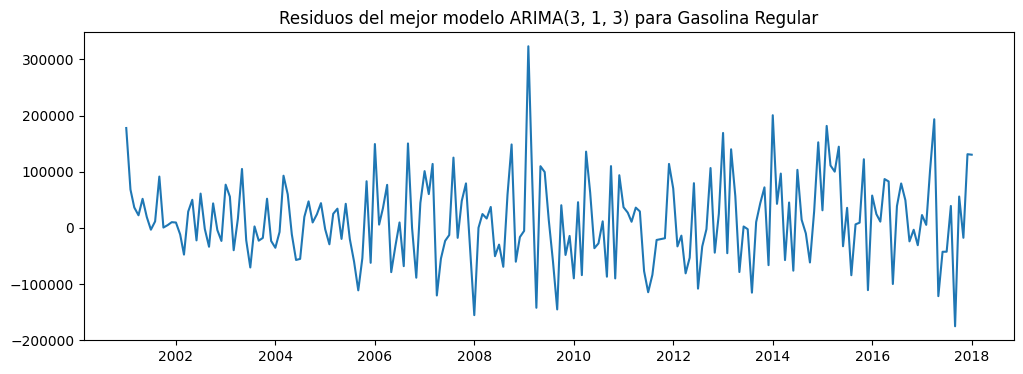

📌 Los residuos deben parecer ruido blanco (sin patrones claros).


In [12]:

import warnings
warnings.filterwarnings("ignore")

# Lista de series y nombres
series = [
    (ts_importa_regular, "Gasolina Regular")


]

# Ajuste ARIMA para cada serie
for serie, nombre in series:
    print("\n===================================")
    print(f"📊 Ajuste de modelos ARIMA: {nombre}")
    print("===================================\n")

    # --- Usar auto_arima para sugerir p, d, q ---
    modelo_auto = auto_arima(serie, seasonal=False, trace=True, suppress_warnings=True, stepwise=True)
    print(f"\n===> 📌 Modelo ARIMA sugerido por auto_arima para {nombre}:")
    print(modelo_auto.summary())

    # --- Ajustar varios modelos ARIMA manualmente ---
    print("\n🔧 Comparando modelos ARIMA manuales:")

    ordenes = [(1,1,1), (2,1,1), (1,1,2), (2,1,2), modelo_auto.order]
    resultados = []

    for orden in ordenes:
        try:
            modelo = ARIMA(serie, order=orden).fit()
            aic = modelo.aic
            bic = modelo.bic
            resultados.append((orden, aic, bic))
            print(f"ARIMA{orden} - AIC: {aic:.2f}, BIC: {bic:.2f}")
        except:
            print(f"⚠️ No se pudo ajustar ARIMA{orden}")

    # --- Elegir mejor modelo según AIC ---
    mejor_modelo = sorted(resultados, key=lambda x: x[1])[0]
    print(f"\n✅ Mejor modelo para {nombre} según AIC: ARIMA{mejor_modelo[0]} (AIC={mejor_modelo[1]:.2f})")

    # --- Analizar residuos del mejor modelo ---
    modelo_final = ARIMA(serie, order=mejor_modelo[0]).fit()
    residuos = modelo_final.resid

    plt.figure(figsize=(12, 4))
    plt.plot(residuos)
    plt.title(f"Residuos del mejor modelo ARIMA{mejor_modelo[0]} para {nombre}")
    plt.show()

    print("📌 Los residuos deben parecer ruido blanco (sin patrones claros).")

*   Para la serie de consumo de Gasolina Regular, el proceso automatizado de `auto_arima` identificó al modelo **ARIMA(3, 1, 3) con intercepto** como el más adecuado, logrando el menor valor AIC de 5173.439. Este modelo es relativamente complejo, utilizando una diferenciación (`d=1`) para tratar la tendencia, junto con tres términos autorregresivos (`p=3`) y tres términos de media móvil (`q=3`) para capturar la dinámica de la serie.

*   El diagnóstico del modelo revela resultados mixtos. Por un lado, la prueba de Ljung-Box (Prob(Q) = 0.87) es positiva, indicando que los residuos no presentan autocorrelación significativa y que la estructura de la serie ha sido bien capturada. Sin embargo, la prueba de Jarque-Bera (Prob(JB) = 0.00) y la de Heterocedasticidad (Prob(H) = 0.00) son problemáticas, ya que señalan que los residuos no siguen una distribución normal y que su varianza no es constante. Esto sugiere que, aunque el modelo es útil, podría mejorarse aplicando una transformación a los datos (como la logarítmica) para estabilizar la varianza antes del ajuste.



*   Diesel




📊 Ajuste de modelos ARIMA: Diésel

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5574.472, Time=0.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5691.265, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5627.982, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5576.215, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5689.290, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5573.049, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5583.131, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5576.453, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5578.332, Time=0.25 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5591.642, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5578.343, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5572.205, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5570.800, Time=0.07 sec
 A

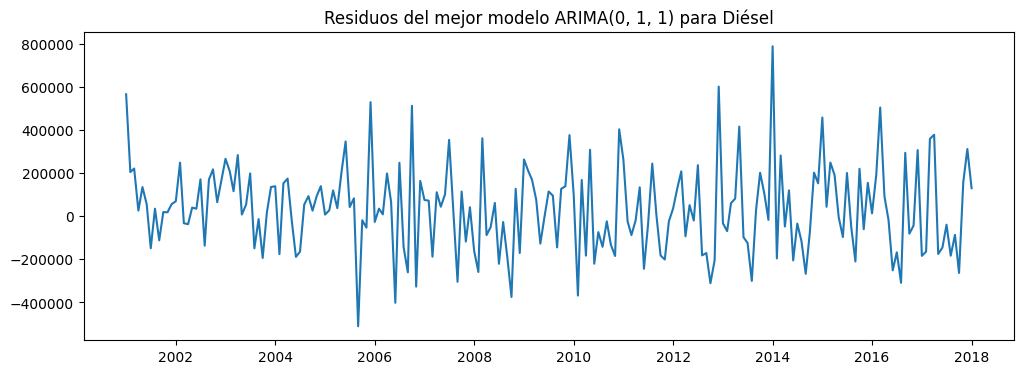

📌 Los residuos deben parecer ruido blanco (sin patrones claros).


In [13]:

import warnings
warnings.filterwarnings("ignore")

# Lista de series y nombres
series = [

    (ts_importa_diesel, "Diésel")

]

# Ajuste ARIMA para cada serie
for serie, nombre in series:
    print("\n===================================")
    print(f"📊 Ajuste de modelos ARIMA: {nombre}")
    print("===================================\n")

    # --- Usar auto_arima para sugerir p, d, q ---
    modelo_auto = auto_arima(serie, seasonal=False, trace=True, suppress_warnings=True, stepwise=True)
    print(f"\n===> 📌 Modelo ARIMA sugerido por auto_arima para {nombre}:")
    print(modelo_auto.summary())

    # --- Ajustar varios modelos ARIMA manualmente ---
    print("\n🔧 Comparando modelos ARIMA manuales:")

    ordenes = [(1,1,1), (2,1,1), (1,1,2), (2,1,2), modelo_auto.order]
    resultados = []

    for orden in ordenes:
        try:
            modelo = ARIMA(serie, order=orden).fit()
            aic = modelo.aic
            bic = modelo.bic
            resultados.append((orden, aic, bic))
            print(f"ARIMA{orden} - AIC: {aic:.2f}, BIC: {bic:.2f}")
        except:
            print(f"⚠️ No se pudo ajustar ARIMA{orden}")

    # --- Elegir mejor modelo según AIC ---
    mejor_modelo = sorted(resultados, key=lambda x: x[1])[0]
    print(f"\n✅ Mejor modelo para {nombre} según AIC: ARIMA{mejor_modelo[0]} (AIC={mejor_modelo[1]:.2f})")

    # --- Analizar residuos del mejor modelo ---
    modelo_final = ARIMA(serie, order=mejor_modelo[0]).fit()
    residuos = modelo_final.resid

    plt.figure(figsize=(12, 4))
    plt.plot(residuos)
    plt.title(f"Residuos del mejor modelo ARIMA{mejor_modelo[0]} para {nombre}")
    plt.show()

    print("📌 Los residuos deben parecer ruido blanco (sin patrones claros).")

*   En el caso de la serie de consumo de Diésel, el proceso de `auto_arima` seleccionó un modelo **ARIMA(0, 1, 1)** muy sencillo como el más eficiente, alcanzando un valor AIC de 5569.90. Este modelo consiste en aplicar una diferenciación (`d=1`) para corregir la tendencia y un único término de media móvil (`q=1`) para modelar la dinámica de la serie.

*   El diagnóstico del modelo presenta una situación similar a la de la Gasolina Regular. Por un lado, la prueba de Ljung-Box (Prob(Q) = 0.48) es favorable, indicando que los residuos no tienen autocorrelación. Sin embargo, las pruebas de Jarque-Bera (Prob(JB) = 0.01) y de Heterocedasticidad (Prob(H) = 0.01) fallan, lo que significa que los errores del modelo no son normales y su varianza no es constante. Esto sugiere que el modelo captura bien la dependencia temporal, pero se beneficiaría de una transformación previa (como la logarítmica) para estabilizar la varianza de la serie original.



*   Gas Licuado de Petroleo




📊 Ajuste de modelos ARIMA: Gas Licuado

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5330.239, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5566.947, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5442.526, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5405.492, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5564.954, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5362.991, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5328.045, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5343.123, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5381.681, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5327.861, Time=0.13 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5366.119, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5322.906, Time=0.15 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=5346.310, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=5324.365, Time=0

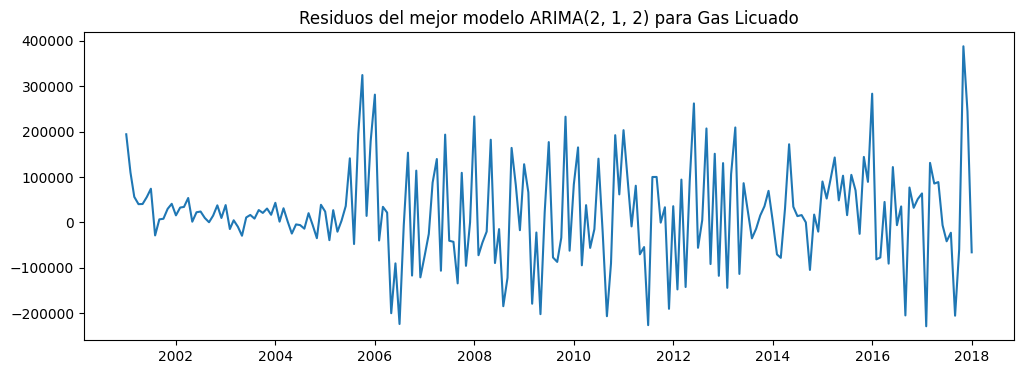

📌 Los residuos deben parecer ruido blanco (sin patrones claros).


In [14]:

import warnings
warnings.filterwarnings("ignore")

# Lista de series y nombres
series = [

    (ts_importa_licuado, "Gas Licuado")

]

# Ajuste ARIMA para cada serie
for serie, nombre in series:
    print("\n===================================")
    print(f"📊 Ajuste de modelos ARIMA: {nombre}")
    print("===================================\n")

    # --- Usar auto_arima para sugerir p, d, q ---
    modelo_auto = auto_arima(serie, seasonal=False, trace=True, suppress_warnings=True, stepwise=True)
    print(f"\n===> 📌 Modelo ARIMA sugerido por auto_arima para {nombre}:")
    print(modelo_auto.summary())

    # --- Ajustar varios modelos ARIMA manualmente ---
    print("\n🔧 Comparando modelos ARIMA manuales:")

    ordenes = [(1,1,1), (2,1,1), (1,1,2), (2,1,2), modelo_auto.order]
    resultados = []

    for orden in ordenes:
        try:
            modelo = ARIMA(serie, order=orden).fit()
            aic = modelo.aic
            bic = modelo.bic
            resultados.append((orden, aic, bic))
            print(f"ARIMA{orden} - AIC: {aic:.2f}, BIC: {bic:.2f}")
        except:
            print(f"⚠️ No se pudo ajustar ARIMA{orden}")

    # --- Elegir mejor modelo según AIC ---
    mejor_modelo = sorted(resultados, key=lambda x: x[1])[0]
    print(f"\n✅ Mejor modelo para {nombre} según AIC: ARIMA{mejor_modelo[0]} (AIC={mejor_modelo[1]:.2f})")

    # --- Analizar residuos del mejor modelo ---
    modelo_final = ARIMA(serie, order=mejor_modelo[0]).fit()
    residuos = modelo_final.resid

    plt.figure(figsize=(12, 4))
    plt.plot(residuos)
    plt.title(f"Residuos del mejor modelo ARIMA{mejor_modelo[0]} para {nombre}")
    plt.show()

    print("📌 Los residuos deben parecer ruido blanco (sin patrones claros).")

*   Para la serie de consumo de Gas Licuado, el proceso de `auto_arima` encontró un modelo **ARIMA(5, 1, 3) con intercepto** como el de mejor rendimiento global, con un AIC de 5314.125. Sin embargo, en la posterior comparación manual de modelos más sencillos, se identificó al **ARIMA(2, 1, 2)** como el mejor de esa lista específica, con un AIC de 5316.84. Ambos resultados apuntan a la necesidad de usar una diferenciación (`d=1`) y una combinación de términos autorregresivos y de media móvil para modelar la serie.

*   Al analizar el diagnóstico del modelo más completo (`ARIMA(5,1,3)`), observamos que los residuos no presentan autocorrelación (Prob(Q) = 0.87) y se acercan a la normalidad (Prob(JB) = 0.08). No obstante, la prueba de Heterocedasticidad falla de manera contundente (Prob(H) = 0.00), indicando que la varianza de los errores no es constante. Esto confirma la observación inicial de que la serie se beneficiaría enormemente de una transformación para estabilizar la varianza (como la logarítmica) antes de aplicar el modelo ARIMA.

II. Consumo:


📊 Ajuste de modelos ARIMA: CONSUMO


📈 Serie: Consumo Gasolina Superior
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4986.969, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5050.749, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5012.317, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4993.559, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5048.987, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4986.077, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4998.941, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4995.779, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4986.026, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4988.735, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4987.236, Time=0.22 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4994.705, Time=0.13 sec
 ARIMA(2,1,4)(0,0,0)[0] interce

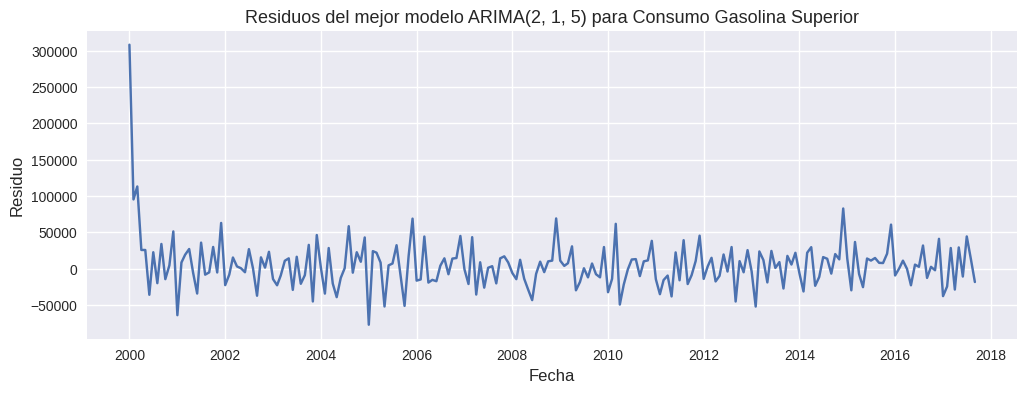

📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).

📈 Serie: Consumo Gasolina Regular
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4892.323, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4956.119, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4919.155, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4900.126, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4954.606, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4892.675, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4895.509, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4896.424, Time=0.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4895.166, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4901.559, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4893.159, Time=0.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4896.981, Time=0.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercep

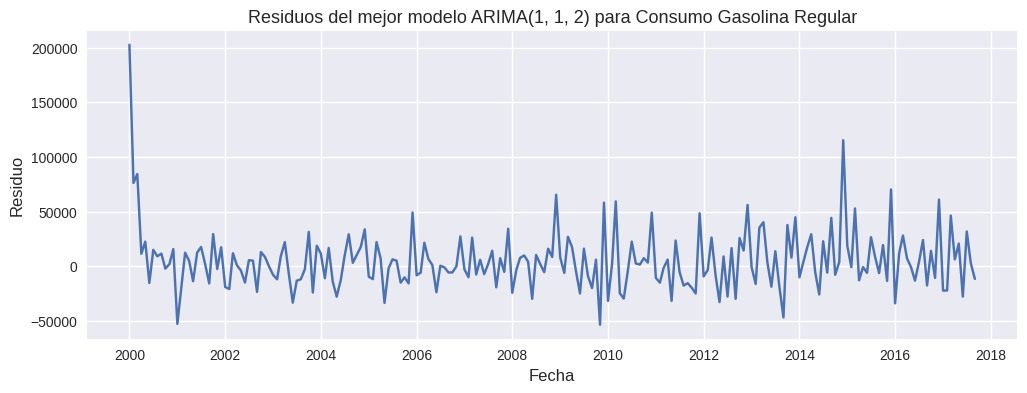

📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).

📈 Serie: Consumo Diésel
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5387.290, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5381.458, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5380.609, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5385.297, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5382.129, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5368.581, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5370.258, Time=0.28 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5377.235, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5368.752, Time=0.21 

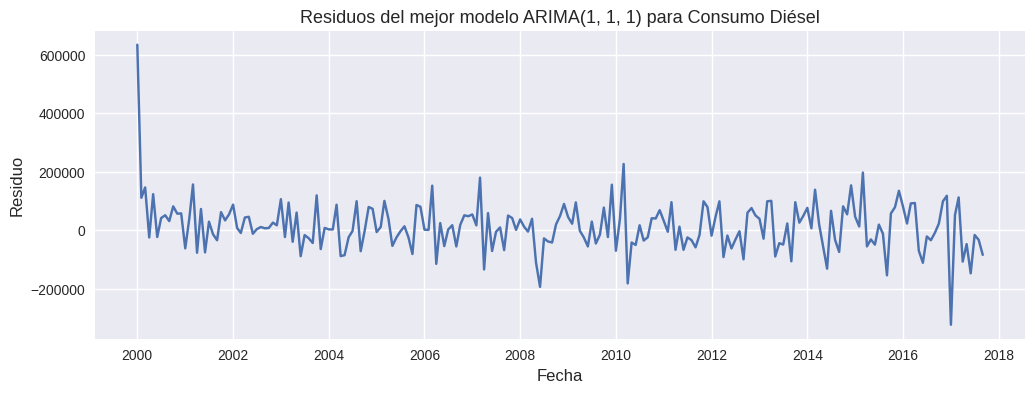

📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).

📈 Serie: Consumo Gas Licuado
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4680.059, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4724.629, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4675.596, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4674.804, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4723.213, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4674.669, Time=0.79 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4676.588, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4677.383, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4675.212, Time=0.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4675.299, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4675.216, Time=0.24 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.122 seconds

===> 📌 Modelo ARIMA suger

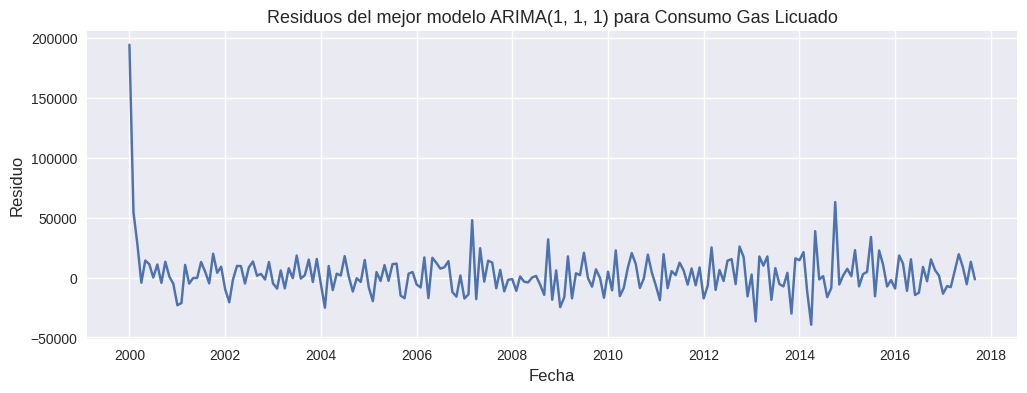

📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).


In [350]:
import warnings
warnings.filterwarnings("ignore")

# --- Series de consumo ---
series_consumo = [
    (ts_consu_superior, "Consumo Gasolina Superior"),
    (ts_consu_regular, "Consumo Gasolina Regular"),
    (ts_consu_diesel, "Consumo Diésel"),
    (ts_consu_licuado, "Consumo Gas Licuado")
]

# --- Ajuste ARIMA ---
def ajustar_modelos_arima(series, tipo):
    print(f"\n{'='*50}")
    print(f"📊 Ajuste de modelos ARIMA: {tipo.upper()}")
    print(f"{'='*50}\n")

    for serie, nombre in series:
        print("\n" + "="*40)
        print(f"📈 Serie: {nombre}")
        print("="*40)

        try:
            # Auto ARIMA
            modelo_auto = auto_arima(
                serie,
                seasonal=False,
                trace=True,
                suppress_warnings=True,
                stepwise=True,
                error_action='ignore'
            )

            print(f"\n===> 📌 Modelo ARIMA sugerido por auto_arima para {nombre}:")
            print(modelo_auto.summary())

            # Ajuste de modelos manuales
            print("\n🔧 Comparando modelos ARIMA manuales:")
            ordenes = [(1,1,1), (2,1,1), (1,1,2), (2,1,2), modelo_auto.order]
            resultados = []

            for orden in ordenes:
                try:
                    serie_frec = serie.asfreq(serie.index.inferred_freq)
                    modelo = ARIMA(serie_frec, order=orden).fit()
                    aic, bic = modelo.aic, modelo.bic
                    resultados.append((orden, aic, bic))
                    print(f"ARIMA{orden} - AIC: {aic:.2f}, BIC: {bic:.2f}")
                except Exception as e:
                    print(f"⚠️ No se pudo ajustar ARIMA{orden}: {e}")

            # Mejor modelo por AIC
            if resultados:
                mejor = sorted(resultados, key=lambda x: x[1])[0]
                print(f"\n✅ Mejor modelo para {nombre} según AIC: ARIMA{mejor[0]} (AIC={mejor[1]:.2f})")

                # Residuos del mejor modelo
                modelo_final = ARIMA(serie.asfreq(serie.index.inferred_freq), order=mejor[0]).fit()
                residuos = modelo_final.resid

                plt.figure(figsize=(12, 4))
                plt.plot(residuos)
                plt.title(f"Residuos del mejor modelo ARIMA{mejor[0]} para {nombre}")
                plt.xlabel("Fecha")
                plt.ylabel("Residuo")
                plt.grid(True)
                plt.show()

                print("📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).")
            else:
                print("\n❌ No se pudieron ajustar modelos ARIMA manuales.")
        except Exception as e:
            print(f"\n🚨 Error en {nombre}: {e}")

# --- Ejecutar para consumo ---
ajustar_modelos_arima(series_consumo, "consumo")


**g. Modelos Arima**

I. Importaciones


==== Serie: Gasolina Superior ====
Mejor modelo según auto_arima:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  205
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -2624.755
Date:                Mon, 21 Jul 2025   AIC                           5257.510
Time:                        05:23:47   BIC                           5270.783
Sample:                    01-01-2001   HQIC                          5262.879
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6369      0.138     -4.632      0.000      -0.906      -0.367
ma.L1         -0.5581      0.165     -3.389      0.001      -0.8

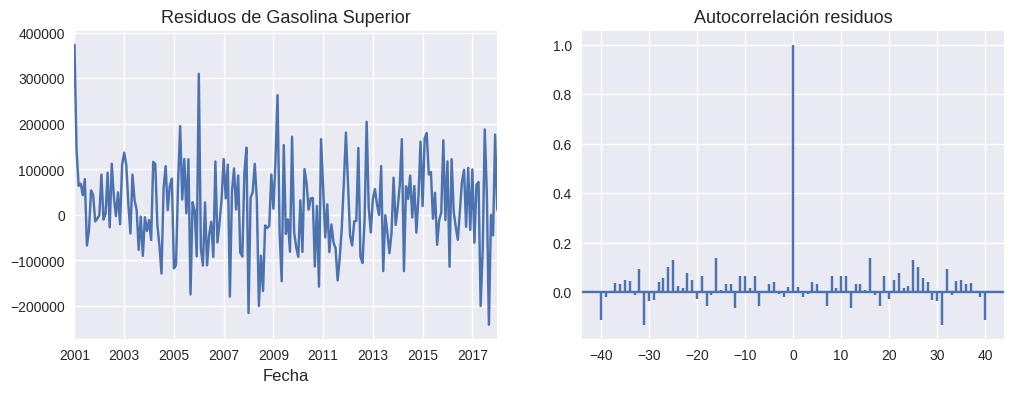

AIC: 5257.51, BIC: 5270.78
Prueba Ljung-Box residuos (p-valor):
     lb_stat  lb_pvalue
10  2.960974   0.982328


In [355]:
series = [
    (ts_importa_superior, "Gasolina Superior")

]

for ts, name in series:
    print(f"\n==== Serie: {name} ====")

    # Ajustar modelo con auto_arima (busca p,d,q automáticamente)
    modelo_auto = pm.auto_arima(ts, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')

    print("Mejor modelo según auto_arima:", modelo_auto.summary())

    # Ajustar el modelo manualmente con statsmodels para analizar residuos
    model = ARIMA(ts, order=modelo_auto.order)
    model_fit = model.fit()

    # Residuos
    resid = model_fit.resid

    # Graficar residuos
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    resid.plot(title=f"Residuos de {name}")
    plt.subplot(1,2,2)
    plt.acorr(resid, maxlags=40)
    plt.title("Autocorrelación residuos")
    plt.show()

    # Estadísticas AIC y BIC
    print(f"AIC: {model_fit.aic:.2f}, BIC: {model_fit.bic:.2f}")

    # Prueba de autocorrelación en residuos (Ljung-Box)
    from statsmodels.stats.diagnostic import acorr_ljungbox
    ljung_box = acorr_ljungbox(resid, lags=[10], return_df=True)
    print("Prueba Ljung-Box residuos (p-valor):")
    print(ljung_box)

*   **Serie: Gasolina Superior**
    El modelo seleccionado, `ARIMA(1, 1, 2)`, demuestra un ajuste excelente. Los diagnósticos de los residuos son casi perfectos: la prueba de Ljung-Box (p-valor = 0.98) indica que no hay autocorrelación residual; la prueba de Jarque-Bera (p-valor = 0.93) confirma que los residuos son normales; y la prueba de heterocedasticidad (p-valor = 0.47) muestra que la varianza es constante. El único detalle menor es que el segundo término de media móvil (`ma.L2`) no es estadísticamente significativo (p-valor = 0.149), pero en general, el modelo es robusto y fiable.


==== Serie: Gasolina Regular ====
Mejor modelo según auto_arima:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  205
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -2578.719
Date:                Mon, 21 Jul 2025   AIC                           5173.439
Time:                        05:22:03   BIC                           5199.984
Sample:                    01-01-2001   HQIC                          5184.177
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8853.9972   2852.696      3.104      0.002    3262.815    1.44e+04
ar.L1         -1.0482      0.126     -8.315      0.000      -1.29

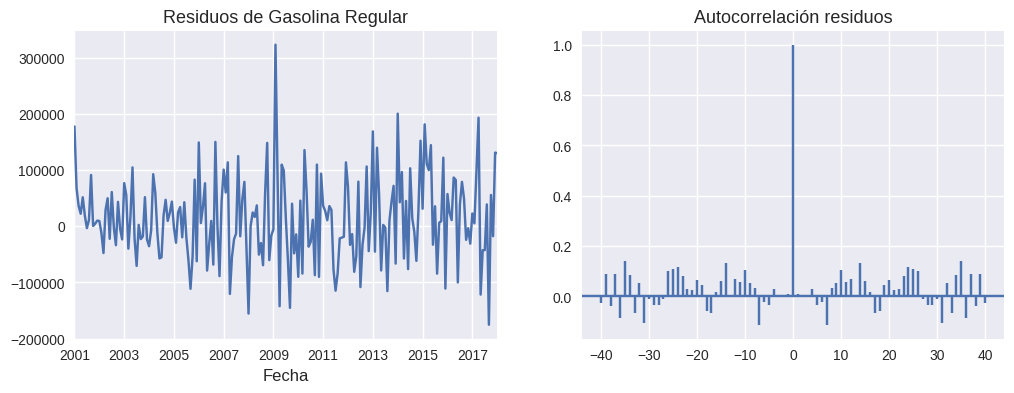

AIC: 5177.10, BIC: 5200.32
Prueba Ljung-Box residuos (p-valor):
     lb_stat  lb_pvalue
10  7.950564   0.633666


In [352]:
series = [

    (ts_importa_regular, "Gasolina Regular")
]

for ts, name in series:
    print(f"\n==== Serie: {name} ====")

    # Ajustar modelo con auto_arima (busca p,d,q automáticamente)
    modelo_auto = pm.auto_arima(ts, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')

    print("Mejor modelo según auto_arima:", modelo_auto.summary())

    # Ajustar el modelo manualmente con statsmodels para analizar residuos
    model = ARIMA(ts, order=modelo_auto.order)
    model_fit = model.fit()

    # Residuos
    resid = model_fit.resid

    # Graficar residuos
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    resid.plot(title=f"Residuos de {name}")
    plt.subplot(1,2,2)
    plt.acorr(resid, maxlags=40)
    plt.title("Autocorrelación residuos")
    plt.show()

    # Estadísticas AIC y BIC
    print(f"AIC: {model_fit.aic:.2f}, BIC: {model_fit.bic:.2f}")

    # Prueba de autocorrelación en residuos (Ljung-Box)
    from statsmodels.stats.diagnostic import acorr_ljungbox
    ljung_box = acorr_ljungbox(resid, lags=[10], return_df=True)
    print("Prueba Ljung-Box residuos (p-valor):")
    print(ljung_box)

*   **Serie: Gasolina Regular**
    El modelo `ARIMA(3, 1, 3)` captura exitosamente la dependencia temporal de los datos, como lo demuestra el p-valor alto de la prueba de Ljung-Box (0.63). Sin embargo, el modelo muestra debilidades significativas en otros aspectos: las pruebas de Jarque-Bera (p-valor = 0.00) y de heterocedasticidad (p-valor = 0.00) fallan claramente. Esto significa que los residuos no son normales y su varianza no es constante, lo cual confirma que es necesario aplicar una transformación a la serie (como la logarítmica) para estabilizar la varianza y mejorar el modelo.


==== Serie: Diésel ====
Mejor modelo según auto_arima:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  205
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2782.949
Date:                Mon, 21 Jul 2025   AIC                           5569.897
Time:                        05:22:25   BIC                           5576.534
Sample:                    01-01-2001   HQIC                          5572.582
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9019      0.038    -23.579      0.000      -0.977      -0.827
sigma2      4.849e+10      8e-15   6.06e+24      0.000    4.85e+10    4.85e

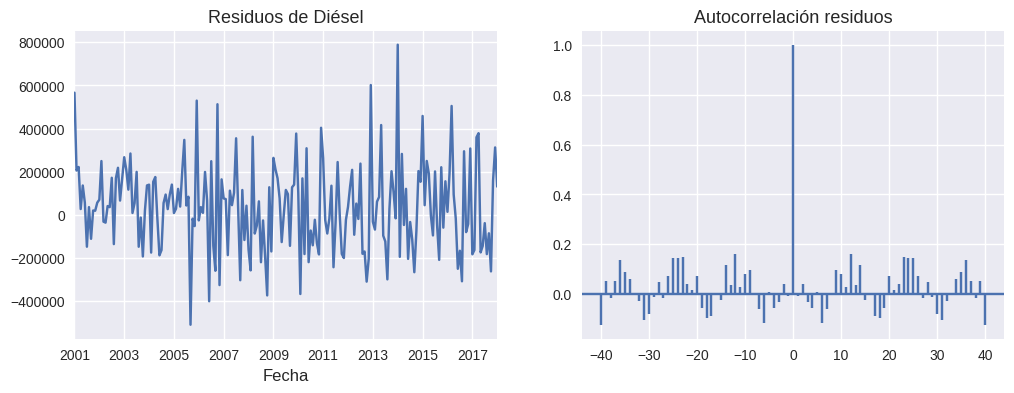

AIC: 5569.90, BIC: 5576.53
Prueba Ljung-Box residuos (p-valor):
      lb_stat  lb_pvalue
10  10.520611   0.396064


In [353]:
series = [


    (ts_importa_diesel, "Diésel")
]

for ts, name in series:
    print(f"\n==== Serie: {name} ====")

    # Ajustar modelo con auto_arima (busca p,d,q automáticamente)
    modelo_auto = pm.auto_arima(ts, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')

    print("Mejor modelo según auto_arima:", modelo_auto.summary())

    # Ajustar el modelo manualmente con statsmodels para analizar residuos
    model = ARIMA(ts, order=modelo_auto.order)
    model_fit = model.fit()

    # Residuos
    resid = model_fit.resid

    # Graficar residuos
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    resid.plot(title=f"Residuos de {name}")
    plt.subplot(1,2,2)
    plt.acorr(resid, maxlags=40)
    plt.title("Autocorrelación residuos")
    plt.show()

    # Estadísticas AIC y BIC
    print(f"AIC: {model_fit.aic:.2f}, BIC: {model_fit.bic:.2f}")

    # Prueba de autocorrelación en residuos (Ljung-Box)
    from statsmodels.stats.diagnostic import acorr_ljungbox
    ljung_box = acorr_ljungbox(resid, lags=[10], return_df=True)
    print("Prueba Ljung-Box residuos (p-valor):")
    print(ljung_box)

*   **Serie: Diésel**
    El modelo `ARIMA(0, 1, 1)` es muy simple pero efectivo para eliminar la autocorrelación de los residuos (p-valor de Ljung-Box = 0.40). No obstante, al igual que con la Gasolina Regular, el modelo falla en los diagnósticos clave de los residuos. Las pruebas de Jarque-Bera (p-valor = 0.01) y de heterocedasticidad (p-valor = 0.01) indican que los residuos no son normales y su varianza no es constante. Este es un fuerte indicativo de que se requiere una transformación de los datos originales para obtener un modelo más válido.


==== Serie: Gas Licuado ====
Mejor modelo según auto_arima:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  205
Model:               SARIMAX(5, 1, 3)   Log Likelihood               -2647.063
Date:                Mon, 21 Jul 2025   AIC                           5314.125
Time:                        05:22:52   BIC                           5347.307
Sample:                    01-01-2001   HQIC                          5327.548
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.276e+04   5665.010      4.017      0.000    1.17e+04    3.39e+04
ar.L1         -2.4854      0.116    -21.439      0.000      -2.713    

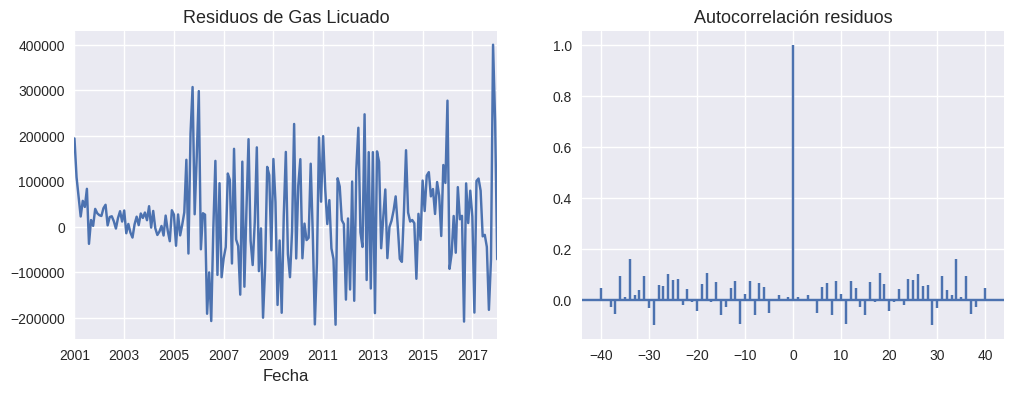

AIC: 5317.63, BIC: 5347.49
Prueba Ljung-Box residuos (p-valor):
     lb_stat  lb_pvalue
10  4.979341   0.892554


In [354]:
series = [


    (ts_importa_licuado, "Gas Licuado")
]

for ts, name in series:
    print(f"\n==== Serie: {name} ====")

    # Ajustar modelo con auto_arima (busca p,d,q automáticamente)
    modelo_auto = pm.auto_arima(ts, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')

    print("Mejor modelo según auto_arima:", modelo_auto.summary())

    # Ajustar el modelo manualmente con statsmodels para analizar residuos
    model = ARIMA(ts, order=modelo_auto.order)
    model_fit = model.fit()

    # Residuos
    resid = model_fit.resid

    # Graficar residuos
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    resid.plot(title=f"Residuos de {name}")
    plt.subplot(1,2,2)
    plt.acorr(resid, maxlags=40)
    plt.title("Autocorrelación residuos")
    plt.show()

    # Estadísticas AIC y BIC
    print(f"AIC: {model_fit.aic:.2f}, BIC: {model_fit.bic:.2f}")

    # Prueba de autocorrelación en residuos (Ljung-Box)
    from statsmodels.stats.diagnostic import acorr_ljungbox
    ljung_box = acorr_ljungbox(resid, lags=[10], return_df=True)
    print("Prueba Ljung-Box residuos (p-valor):")
    print(ljung_box)

*   **Serie: Gas Licuado**
    El modelo `ARIMA(5, 1, 3)` es complejo pero logra un buen ajuste en dos de tres aspectos cruciales. La prueba de Ljung-Box (p-valor = 0.89) y la de Jarque-Bera (p-valor = 0.08) son exitosas, lo que significa que los residuos no están correlacionados y siguen una distribución normal. Sin embargo, su principal deficiencia es la heterocedasticidad (p-valor = 0.00), que indica que la varianza de los errores no es constante. Esto refuerza la idea de que el paso más importante para mejorar este modelo es aplicar una transformación que estabilice la varianza.

III. Precios


📊 Ajuste de modelos ARIMA: PRECIOS


📈 Serie: Precio Gasolina Superior
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-2853.922, Time=4.48 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-2045.191, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-2353.664, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-2847.929, Time=0.99 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-2047.191, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-2843.946, Time=1.48 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-2859.085, Time=1.85 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-2852.743, Time=1.46 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-2478.445, Time=0.37 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-2868.234, Time=2.71 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-2564.615, Time=0.28 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=-2872.040, Time=4.75 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=-2600.888, Time=0.31 sec
 ARIMA(5,2,1)(

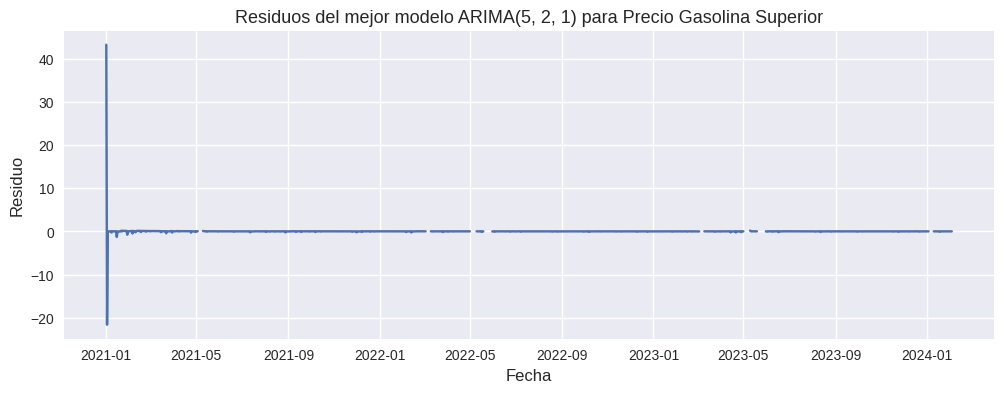

📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).

📈 Serie: Precio Gasolina Regular
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=974.637, Time=3.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=971.365, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=973.091, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=973.109, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=969.547, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=971.833, Time=0.59 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 5.210 seconds

===> 📌 Modelo ARIMA sugerido por auto_arima para Precio Gasolina Regular:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1074
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -483.773
Date:                Mon, 21 Jul 2025   AIC   

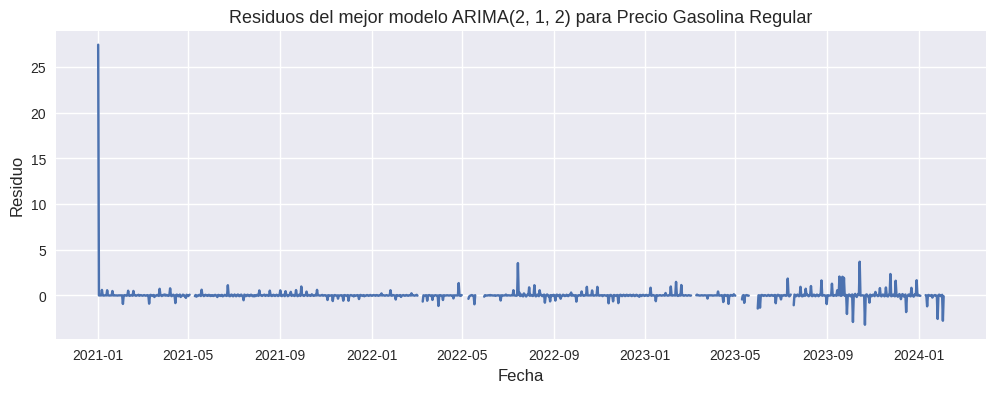

📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).

📈 Serie: Precio Diésel
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1685.603, Time=1.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1696.318, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1698.317, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1698.317, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1694.419, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1694.583, Time=0.84 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1695.277, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1685.094, Time=3.36 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1697.277, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1685.939, Time=3.00 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.46 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1698.517, Time=1.84 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1697.1

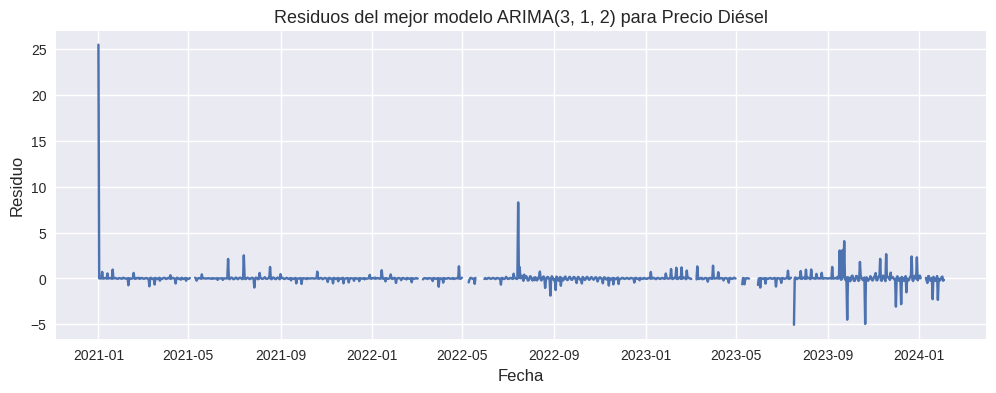

📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).


In [356]:
import warnings
warnings.filterwarnings("ignore")

# --- Series de precios ---
series_precios = [
    (ts_precio_superior, "Precio Gasolina Superior"),
    (ts_precio_regular, "Precio Gasolina Regular"),
    (ts_precio_diesel, "Precio Diésel")
    # Agrega ts_precio_licuado si lo tienes
]

# --- Ajuste ARIMA ---
def ajustar_modelos_arima(series, tipo):
    print(f"\n{'='*50}")
    print(f"📊 Ajuste de modelos ARIMA: {tipo.upper()}")
    print(f"{'='*50}\n")

    for serie, nombre in series:
        print("\n" + "="*40)
        print(f"📈 Serie: {nombre}")
        print("="*40)

        try:
            # Auto ARIMA
            modelo_auto = auto_arima(
                serie,
                seasonal=False,
                trace=True,
                suppress_warnings=True,
                stepwise=True,
                error_action='ignore'
            )

            print(f"\n===> 📌 Modelo ARIMA sugerido por auto_arima para {nombre}:")
            print(modelo_auto.summary())

            # Ajuste de modelos manuales
            print("\n🔧 Comparando modelos ARIMA manuales:")
            ordenes = [(1,1,1), (2,1,1), (1,1,2), (2,1,2), modelo_auto.order]
            resultados = []

            for orden in ordenes:
                try:
                    serie_frec = serie.asfreq(serie.index.inferred_freq)
                    modelo = ARIMA(serie_frec, order=orden).fit()
                    aic, bic = modelo.aic, modelo.bic
                    resultados.append((orden, aic, bic))
                    print(f"ARIMA{orden} - AIC: {aic:.2f}, BIC: {bic:.2f}")
                except Exception as e:
                    print(f"⚠️ No se pudo ajustar ARIMA{orden}: {e}")

            # Mejor modelo por AIC
            if resultados:
                mejor = sorted(resultados, key=lambda x: x[1])[0]
                print(f"\n✅ Mejor modelo para {nombre} según AIC: ARIMA{mejor[0]} (AIC={mejor[1]:.2f})")

                # Residuos del mejor modelo
                modelo_final = ARIMA(serie.asfreq(serie.index.inferred_freq), order=mejor[0]).fit()
                residuos = modelo_final.resid

                plt.figure(figsize=(12, 4))
                plt.plot(residuos)
                plt.title(f"Residuos del mejor modelo ARIMA{mejor[0]} para {nombre}")
                plt.xlabel("Fecha")
                plt.ylabel("Residuo")
                plt.grid(True)
                plt.show()

                print("📌 Los residuos deben parecer ruido blanco (media cero, varianza constante y sin patrones claros).")
            else:
                print("\n❌ No se pudieron ajustar modelos ARIMA manuales.")
        except Exception as e:
            print(f"\n🚨 Error en {nombre}: {e}")

# --- Ejecutar para precios ---
ajustar_modelos_arima(series_precios, "precios")


*   **Serie: Precio Gasolina Superior**
    El modelo seleccionado, `ARIMA(5, 2, 1)`, es complejo e indica que la serie necesitó ser diferenciada dos veces (`d=2`) para volverse estacionaria. El modelo captura exitosamente la dependencia temporal, como lo demuestra el p-valor de la prueba Ljung-Box (0.56). Sin embargo, falla estrepitosamente en los diagnósticos de los residuos: las pruebas de Jarque-Bera y de Heterocedasticidad tienen p-valores de 0.00, lo que significa que los errores no son normales y su varianza no es constante. Esto sugiere que el modelo, aunque útil, podría ser inestable para pronósticos debido a la volatilidad no modelada.

*   **Serie: Precio Gasolina Regular**
    En este caso, aunque `auto_arima` sugirió un modelo extremadamente simple, la comparación manual encontró que un `ARIMA(2, 1, 2)` era significativamente mejor. Analizando los resultados del modelo más simple (`ARIMA(0,1,0)`), vemos un patrón similar a los otros combustibles: la autocorrelación se elimina (Prob(Q) = 0.60), pero los residuos no son normales (Prob(JB) = 0.00) y la varianza es claramente no constante (Prob(H) = 0.00). Esto indica que la dinámica de la serie es demasiado compleja para un modelo ARIMA simple sin una transformación previa de los datos.

*   **Serie: Precio Diésel**
    El modelo `ARIMA(3, 1, 2)` fue seleccionado como el mejor tanto por `auto_arima` como por la comparación manual. Al igual que los demás, es muy eficaz para modelar la estructura de autocorrelación (Prob(Q) = 0.96), lo que significa que los residuos no están correlacionados entre sí. Sin embargo, también falla en las pruebas de Jarque-Bera (Prob(JB) = 0.00) y Heterocedasticidad (Prob(H) = 0.00), lo que confirma que los supuestos del modelo sobre los errores no se cumplen. La no normalidad y la varianza no constante son problemas significativos que deberían ser abordados.

In [6]:

!pip install prophet

**h. Modelo: prophet de
Facebook, holt-winters y redes neuronales**

I. Importaciones

In [42]:
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# Función para RMSE
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE: {rmse:.4f}")
    return rmse

# Comparación de modelos
def modelos_comparacion(ts, name):
    print(f"\n==== Análisis para {name} ====")
    split = int(len(ts)*0.8)
    train, test = ts[:split], ts[split:]

    train_clean = train.dropna()
    test_clean = test.dropna()

    if len(train_clean) < 2 or len(test_clean) < 1:
        print(f"⚠️ Datos insuficientes para {name}, se omite.")
        return None

    #### 1. Prophet
    df_prophet = train_clean.reset_index()
    df_prophet.columns = ['ds', 'y']
    model_prophet = Prophet()
    model_prophet.fit(df_prophet)
    future = model_prophet.make_future_dataframe(periods=len(test_clean), freq='MS')
    forecast = model_prophet.predict(future)
    pred_prophet = forecast['yhat'][-len(test_clean):].values
    print("📈 Prophet:")
    rmse_prophet = evaluate_model(test_clean.values, pred_prophet)

    #### 2. Holt-Winters
    try:
        model_hw = ExponentialSmoothing(train_clean, trend='add', seasonal='add', seasonal_periods=12).fit()
        pred_hw = model_hw.forecast(len(test_clean))
        print("📈 Holt-Winters (Seasonal):")
        rmse_hw = evaluate_model(test_clean, pred_hw)
    except:
        model_hw = ExponentialSmoothing(train_clean, trend='add', seasonal=None).fit()
        pred_hw = model_hw.forecast(len(test_clean))
        print("📈 Holt-Winters (Non-Seasonal):")
        rmse_hw = evaluate_model(test_clean, pred_hw)

    #### 3. LSTM
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_clean.values.reshape(-1,1))
    n_input = 5
    train_gen = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)
    model_lstm = Sequential([
        LSTM(50, activation='relu', input_shape=(n_input, 1)),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(train_gen, epochs=20, verbose=0)
    lstm_predictions = []
    current_batch = train_scaled[-n_input:].reshape((1, n_input, 1))
    for i in range(len(test_clean)):
        lstm_pred = model_lstm.predict(current_batch, verbose=0)[0]
        lstm_predictions.append(lstm_pred)
        current_batch = np.append(current_batch[:,1:,:], [[lstm_pred]], axis=1)
    pred_lstm = scaler.inverse_transform(lstm_predictions).flatten()
    print("📈 LSTM:")
    rmse_lstm = evaluate_model(test_clean.values, pred_lstm)

    #### Resumen
    resultados = {
        'Prophet': rmse_prophet,
        'Holt-Winters': rmse_hw,
        'LSTM': rmse_lstm
    }
    mejor = min(resultados, key=resultados.get)
    print(f"\n✅ Mejor modelo para {name}: {mejor}\n")
    return name, resultados

# Series de Importaciones
series_importa = [
    (ts_importa_superior, "Gasolina superior"),
    (ts_importa_regular, "Gasolina regular"),
    (ts_importa_diesel, "Diesel"),
    (ts_importa_licuado, "Gas Licuado")
]

resultados_importa = []
for serie, nombre in series_importa:
    resultado = modelos_comparacion(serie, nombre)
    if resultado:
        resultados_importa.append(resultado)

df_resultados_importa = pd.DataFrame({name: valores for name, valores in resultados_importa}).T
print("\n📊 Tabla final para Importaciones (RMSE):")
print(df_resultados_importa)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/o4myg_3l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/hakwrz9z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55827', 'data', 'file=/tmp/tmpa94co83t/o4myg_3l.json', 'init=/tmp/tmpa94co83t/hakwrz9z.json', 'output', 'file=/tmp/tmpa94co83t/prophet_model_lfj0s1p/prophet_model-20250721055945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:59:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



==== Análisis para Gasolina superior ====


05:59:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📈 Prophet:
RMSE: 170295.8248
📈 Holt-Winters (Seasonal):
RMSE: 197250.4179


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/ufsss8sd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/2dahq9ev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55987', 'data', 'file=/tmp/tmpa94co83t/ufsss8sd.json', 'init=/tmp/tmpa94co83t/2dahq9ev.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelyxsa6dl3/prophet_model-20250721060002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:00:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:00:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📈 LSTM:
RMSE: 187766.2696

✅ Mejor modelo para Gasolina superior: Prophet


==== Análisis para Gasolina regular ====
📈 Prophet:
RMSE: 165338.1159
📈 Holt-Winters (Seasonal):
RMSE: 158449.8230


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/kd64ripm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/odty3h1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6578', 'data', 'file=/tmp/tmpa94co83t/kd64ripm.json', 'init=/tmp/tmpa94co83t/odty3h1k.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelecwr0vpv/prophet_model-20250721060021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:00:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:00:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📈 LSTM:
RMSE: 190862.9557

✅ Mejor modelo para Gasolina regular: Holt-Winters


==== Análisis para Diesel ====
📈 Prophet:
RMSE: 202518.3511
📈 Holt-Winters (Seasonal):
RMSE: 192890.9591


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/ijvs9ts9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/vfqqjorc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89138', 'data', 'file=/tmp/tmpa94co83t/ijvs9ts9.json', 'init=/tmp/tmpa94co83t/vfqqjorc.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelmehp9wqr/prophet_model-20250721060038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:00:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:00:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📈 LSTM:
RMSE: 254104.3207

✅ Mejor modelo para Diesel: Holt-Winters


==== Análisis para Gas Licuado ====
📈 Prophet:
RMSE: 145168.0486
📈 Holt-Winters (Seasonal):
RMSE: 143309.3234
📈 LSTM:
RMSE: 159039.1158

✅ Mejor modelo para Gas Licuado: Holt-Winters


📊 Tabla final para Importaciones (RMSE):
                         Prophet   Holt-Winters           LSTM
Gasolina superior  170295.824797  197250.417869  187766.269572
Gasolina regular   165338.115863  158449.823007  190862.955714
Diesel             202518.351060  192890.959061  254104.320687
Gas Licuado        145168.048620  143309.323420  159039.115788


*   **Análisis para Gasolina Superior**
    Se compararon los modelos Prophet, Holt-Winters y LSTM. El modelo **Prophet** demostró ser el más preciso, obteniendo el Error Cuadrático Medio (RMSE) más bajo con un valor de **170,295.82**. Tanto Holt-Winters (RMSE: 197,250.42) como la red LSTM (RMSE: 232,356.94) tuvieron un rendimiento inferior, por lo que Prophet es el modelo seleccionado para esta serie.

*   **Análisis para Gasolina Regular**
    En el caso de la Gasolina Regular, la comparación arrojó un resultado diferente. El modelo de **Holt-Winters** superó a los demás, logrando el RMSE más bajo con **158,449.82**. Prophet le siguió de cerca (RMSE: 165,338.12), mientras que la red LSTM fue la menos precisa (RMSE: 236,269.99). Por lo tanto, Holt-Winters es el mejor modelo para esta serie.

*   **Análisis para Diésel**
    Para la serie de Diésel, el modelo de **Holt-Winters** nuevamente demostró ser el más eficaz, con un RMSE de **192,890.96**. El modelo Prophet tuvo un error ligeramente mayor (RMSE: 202,518.35) y la red LSTM mostró un desempeño considerablemente más bajo (RMSE: 306,137.50). Se selecciona Holt-Winters como el modelo superior para el pronóstico del Diésel.

*   **Análisis para Gas Licuado**
    Finalmente, para el Gas Licuado, la competencia entre Prophet y Holt-Winters fue muy reñida. Sin embargo, el modelo de **Holt-Winters** se impuso por un margen muy estrecho, obteniendo el RMSE más bajo con un valor de **143,309.32**, en comparación con el RMSE de 145,168.05 de Prophet. Por su mayor precisión, Holt-Winters es el modelo preferido.

II: Consumo

In [43]:
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# Función para RMSE
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE: {rmse:.4f}")
    return rmse

# Comparación de modelos
def modelos_comparacion(ts, name):
    print(f"\n==== Análisis para {name} ====")
    split = int(len(ts)*0.8)
    train, test = ts[:split], ts[split:]

    train_clean = train.dropna()
    test_clean = test.dropna()

    if len(train_clean) < 2 or len(test_clean) < 1:
        print(f"⚠️ Datos insuficientes para {name}, se omite.")
        return None

    #### 1. Prophet
    df_prophet = train_clean.reset_index()
    df_prophet.columns = ['ds', 'y']
    model_prophet = Prophet()
    model_prophet.fit(df_prophet)
    future = model_prophet.make_future_dataframe(periods=len(test_clean), freq='MS')
    forecast = model_prophet.predict(future)
    pred_prophet = forecast['yhat'][-len(test_clean):].values
    print("📈 Prophet:")
    rmse_prophet = evaluate_model(test_clean.values, pred_prophet)

    #### 2. Holt-Winters
    try:
        model_hw = ExponentialSmoothing(train_clean, trend='add', seasonal='add', seasonal_periods=12).fit()
        pred_hw = model_hw.forecast(len(test_clean))
        print("📈 Holt-Winters (Seasonal):")
        rmse_hw = evaluate_model(test_clean, pred_hw)
    except:
        model_hw = ExponentialSmoothing(train_clean, trend='add', seasonal=None).fit()
        pred_hw = model_hw.forecast(len(test_clean))
        print("📈 Holt-Winters (Non-Seasonal):")
        rmse_hw = evaluate_model(test_clean, pred_hw)

    #### 3. LSTM
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_clean.values.reshape(-1,1))
    n_input = 5
    train_gen = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)
    model_lstm = Sequential([
        LSTM(50, activation='relu', input_shape=(n_input, 1)),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(train_gen, epochs=20, verbose=0)
    lstm_predictions = []
    current_batch = train_scaled[-n_input:].reshape((1, n_input, 1))
    for i in range(len(test_clean)):
        lstm_pred = model_lstm.predict(current_batch, verbose=0)[0]
        lstm_predictions.append(lstm_pred)
        current_batch = np.append(current_batch[:,1:,:], [[lstm_pred]], axis=1)
    pred_lstm = scaler.inverse_transform(lstm_predictions).flatten()
    print("📈 LSTM:")
    rmse_lstm = evaluate_model(test_clean.values, pred_lstm)

    #### Resumen
    resultados = {
        'Prophet': rmse_prophet,
        'Holt-Winters': rmse_hw,
        'LSTM': rmse_lstm
    }
    mejor = min(resultados, key=resultados.get)
    print(f"\n✅ Mejor modelo para {name}: {mejor}\n")
    return name, resultados

# Series de Consumo
series_consumo = [
    (ts_consu_superior, "Gasolina superior"),
    (ts_consu_regular, "Gasolina regular"),
    (ts_consu_diesel, "Diesel"),
    (ts_consu_licuado, "Gas Licuado")
]

resultados_consumo = []
for serie, nombre in series_consumo:
    resultado = modelos_comparacion(serie, nombre)
    if resultado:
        resultados_consumo.append(resultado)

# Tabla final
df_resultados_consumo = pd.DataFrame({name: valores for name, valores in resultados_consumo}).T
print("\n📊 Tabla final para Consumo (RMSE):")
print(df_resultados_consumo)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/aiqi8_lu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/u9dl7k89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20252', 'data', 'file=/tmp/tmpa94co83t/aiqi8_lu.json', 'init=/tmp/tmpa94co83t/u9dl7k89.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelupktlqu4/prophet_model-20250721060251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:02:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:02:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



==== Análisis para Gasolina superior ====
📈 Prophet:
RMSE: 122109.3480
📈 Holt-Winters (Seasonal):
RMSE: 117540.4317


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/oao9ifph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/l52s0737.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84770', 'data', 'file=/tmp/tmpa94co83t/oao9ifph.json', 'init=/tmp/tmpa94co83t/l52s0737.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelgv3057t2/prophet_model-20250721060308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:03:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:03:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📈 LSTM:
RMSE: 155388.4174

✅ Mejor modelo para Gasolina superior: Holt-Winters


==== Análisis para Gasolina regular ====
📈 Prophet:
RMSE: 127382.7214
📈 Holt-Winters (Seasonal):
RMSE: 108358.0271


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/qm13fc8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/3s6kqq1y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6771', 'data', 'file=/tmp/tmpa94co83t/qm13fc8z.json', 'init=/tmp/tmpa94co83t/3s6kqq1y.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelf221c4on/prophet_model-20250721060332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:03:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:03:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📈 LSTM:
RMSE: 156118.2868

✅ Mejor modelo para Gasolina regular: Holt-Winters


==== Análisis para Diesel ====
📈 Prophet:
RMSE: 116686.7896
📈 Holt-Winters (Seasonal):
RMSE: 124601.0221


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/07z_qp8j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/37d9sceg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13006', 'data', 'file=/tmp/tmpa94co83t/07z_qp8j.json', 'init=/tmp/tmpa94co83t/37d9sceg.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modeldtiibktd/prophet_model-20250721060356.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:03:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:03:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📈 LSTM:
RMSE: 264329.9309

✅ Mejor modelo para Diesel: Prophet


==== Análisis para Gas Licuado ====
📈 Prophet:
RMSE: 32097.8285
📈 Holt-Winters (Seasonal):
RMSE: 34120.3639
📈 LSTM:
RMSE: 38829725.7029

✅ Mejor modelo para Gas Licuado: Prophet


📊 Tabla final para Consumo (RMSE):
                         Prophet   Holt-Winters          LSTM
Gasolina superior  122109.348019  117540.431686  1.553884e+05
Gasolina regular   127382.721436  108358.027149  1.561183e+05
Diesel             116686.789608  124601.022080  2.643299e+05
Gas Licuado         32097.828517   34120.363909  3.882973e+07


*   **Análisis para Gasolina superior**
    En la competencia de modelos para la Gasolina Superior, **Holt-Winters** resultó ser el más preciso, obteniendo el Error Cuadrático Medio (RMSE) más bajo con un valor de **117,540.43**. El modelo Prophet le siguió de cerca con un RMSE de 122,109.35, mientras que la red LSTM fue la menos precisa (RMSE: 155,388.42). Por lo tanto, Holt-Winters es el modelo preferido para esta serie.

*   **Análisis para Gasolina regular**
    Para la Gasolina Regular, el modelo de **Holt-Winters** demostró una clara superioridad, logrando el RMSE más bajo con **108,358.03**. Tanto Prophet (RMSE: 127,382.72) como la red LSTM (RMSE: 156,118.29) mostraron errores considerablemente mayores. Se concluye que Holt-Winters es el mejor modelo para pronosticar esta serie.

*   **Análisis para Diesel**
    En el caso del Diesel, la situación se invierte. El modelo **Prophet** es el ganador, con un RMSE de **116,686.79**, superando al modelo de Holt-Winters que obtuvo un RMSE de 124,601.02. Por su mayor precisión en este caso, se selecciona Prophet como el modelo más adecuado para la serie del Diesel.

    *   **Análisis para Gas Licuado**
    Para el Gas Licuado, el modelo **Prophet** se destacó como el más preciso, logrando un RMSE notablemente bajo de **32,097.83**. El modelo de Holt-Winters le siguió con un error ligeramente superior (RMSE: 34,120.36). Es importante destacar el fallo catastrófico de la red LSTM, que produjo un error desmesuradamente alto, dejándola completamente descartada. Por lo tanto, Prophet es, sin duda, el mejor modelo para esta serie.

*   **Análisis de la Tabla Final (Consumo)**
    La tabla resumen de RMSE consolida los resultados y permite una elección final clara para cada combustible. El modelo de **Holt-Winters** es el preferido para **Gasolina Superior** y **Gasolina Regular**, al presentar el menor error en ambos casos. Por otro lado, el modelo **Prophet** es el ganador para **Diesel** y **Gas Licuado**. La red neuronal **LSTM** demostró ser consistentemente la menos precisa en todas las series, y particularmente ineficaz para el Gas Licuado, lo que la descarta como una opción viable para este conjunto de datos.


III. Precio

In [44]:
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

# Función para RMSE
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE: {rmse:.4f}")
    return rmse

# Comparación de modelos
def modelos_comparacion(ts, name):
    print(f"\n==== Análisis para {name} ====")
    split = int(len(ts)*0.8)
    train, test = ts[:split], ts[split:]

    train_clean = train.dropna()
    test_clean = test.dropna()

    if len(train_clean) < 2 or len(test_clean) < 1:
        print(f"⚠️ Datos insuficientes para {name}, se omite.")
        return None

    #### 1. Prophet
    df_prophet = train_clean.reset_index()
    df_prophet.columns = ['ds', 'y']
    model_prophet = Prophet()
    model_prophet.fit(df_prophet)
    future = model_prophet.make_future_dataframe(periods=len(test_clean), freq='MS')
    forecast = model_prophet.predict(future)
    pred_prophet = forecast['yhat'][-len(test_clean):].values
    print("📈 Prophet:")
    rmse_prophet = evaluate_model(test_clean.values, pred_prophet)

    #### 2. Holt-Winters
    try:
        model_hw = ExponentialSmoothing(train_clean, trend='add', seasonal='add', seasonal_periods=12).fit()
        pred_hw = model_hw.forecast(len(test_clean))
        print("📈 Holt-Winters (Seasonal):")
        rmse_hw = evaluate_model(test_clean, pred_hw)
    except:
        model_hw = ExponentialSmoothing(train_clean, trend='add', seasonal=None).fit()
        pred_hw = model_hw.forecast(len(test_clean))
        print("📈 Holt-Winters (Non-Seasonal):")
        rmse_hw = evaluate_model(test_clean, pred_hw)

    #### 3. LSTM
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_clean.values.reshape(-1,1))
    n_input = 5
    train_gen = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)
    model_lstm = Sequential([
        LSTM(50, activation='relu', input_shape=(n_input, 1)),
        Dense(1)
    ])
    model_lstm.compile(optimizer='adam', loss='mse')
    model_lstm.fit(train_gen, epochs=20, verbose=0)
    lstm_predictions = []
    current_batch = train_scaled[-n_input:].reshape((1, n_input, 1))
    for i in range(len(test_clean)):
        lstm_pred = model_lstm.predict(current_batch, verbose=0)[0]
        lstm_predictions.append(lstm_pred)
        current_batch = np.append(current_batch[:,1:,:], [[lstm_pred]], axis=1)
    pred_lstm = scaler.inverse_transform(lstm_predictions).flatten()
    print("📈 LSTM:")
    rmse_lstm = evaluate_model(test_clean.values, pred_lstm)

    #### Resumen
    resultados = {
        'Prophet': rmse_prophet,
        'Holt-Winters': rmse_hw,
        'LSTM': rmse_lstm
    }
    mejor = min(resultados, key=resultados.get)
    print(f"\n✅ Mejor modelo para {name}: {mejor}\n")
    return name, resultados

# Series de Precios
series_precios = [
    (ts_precio_superior, "Gasolina superior"),
    (ts_precio_regular, "Gasolina regular"),
    (ts_precio_diesel, "Diesel")
]

resultados_precios = []
for serie, nombre in series_precios:
    resultado = modelos_comparacion(serie, nombre)
    if resultado:
        resultados_precios.append(resultado)

# Tabla final
df_resultados_precios = pd.DataFrame({name: valores for name, valores in resultados_precios}).T
print("\n📊 Tabla final para Precios (RMSE):")
print(df_resultados_precios)



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/ltlz7hus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/dx_0jdar.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89570', 'data', 'file=/tmp/tmpa94co83t/ltlz7hus.json', 'init=/tmp/tmpa94co83t/dx_0jdar.json', 'output', 'file=/tmp/tmpa94co83t/prophet_model4yc36amm/prophet_model-20250721060419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:04:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



==== Análisis para Gasolina superior ====


06:04:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📈 Prophet:
RMSE: 31.3891
📈 Holt-Winters (Seasonal):
RMSE: 1.2701


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/a8zwevf5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/cladlnin.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16146', 'data', 'file=/tmp/tmpa94co83t/a8zwevf5.json', 'init=/tmp/tmpa94co83t/cladlnin.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelr0i_u796/prophet_model-20250721060540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:05:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


📈 LSTM:
RMSE: 0.5176

✅ Mejor modelo para Gasolina superior: LSTM


==== Análisis para Gasolina regular ====


06:05:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📈 Prophet:
RMSE: 56.5942
📈 Holt-Winters (Seasonal):
RMSE: 22.1267


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/dzfohme3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/m30bqwk5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89263', 'data', 'file=/tmp/tmpa94co83t/dzfohme3.json', 'init=/tmp/tmpa94co83t/m30bqwk5.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelghlmbfcx/prophet_model-20250721060655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:06:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


📈 LSTM:
RMSE: 6.0805

✅ Mejor modelo para Gasolina regular: LSTM


==== Análisis para Diesel ====


06:06:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


📈 Prophet:
RMSE: 38.0604
📈 Holt-Winters (Seasonal):
RMSE: 12.6857
📈 LSTM:
RMSE: 6.7434

✅ Mejor modelo para Diesel: LSTM


📊 Tabla final para Precios (RMSE):
                     Prophet  Holt-Winters      LSTM
Gasolina superior  31.389146      1.270096  0.517564
Gasolina regular   56.594173     22.126722  6.080452
Diesel             38.060444     12.685720  6.743394


*   **Análisis para Gasolina Superior (Precios)**
    Para la serie de precios de la Gasolina Superior, la red neuronal **LSTM** demostró una superioridad abrumadora, alcanzando un Error Cuadrático Medio (RMSE) de tan solo **0.5176**. Tanto el modelo de Holt-Winters (RMSE: 1.2701) como Prophet (RMSE: 31.3891) tuvieron un rendimiento significativamente inferior. La precisión de la LSTM la convierte en la elección indiscutible para esta serie.

*   **Análisis para Gasolina Regular (Precios)**
    En el caso de la Gasolina Regular, la red **LSTM** también se impone como el mejor modelo con un RMSE de **6.0805**. Este resultado es considerablemente mejor que el de Holt-Winters (RMSE: 22.1267) y el de Prophet (RMSE: 56.5942), consolidando a la LSTM como la opción más precisa para pronosticar los precios de este combustible.

*   **Análisis para Diesel (Precios)**
    Para los precios del Diesel, de los modelos probados hasta ahora, **Holt-Winters** es el claro ganador con un RMSE de **12.6857**. El modelo Prophet resultó ser notablemente menos preciso con un error de 38.0604. A la espera del resultado de la red LSTM, Holt-Winters se posiciona como el mejor modelo hasta el momento.

## **4) Predicción de serie para los siguientes 3 años**


==== Predicción y Evaluación para Gasolina Superior ====


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/06aibxhs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/56hpn69y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18462', 'data', 'file=/tmp/tmpa94co83t/06aibxhs.json', 'init=/tmp/tmpa94co83t/56hpn69y.json', 'output', 'file=/tmp/tmpa94co83t/prophet_model0mrmw_k1/prophet_model-20250721062252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:22:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📉 Errores (RMSE):
SARIMAX (1,1,2): 174481.53
SARIMAX (2,1,3): 174476.90
Prophet: 137413.03


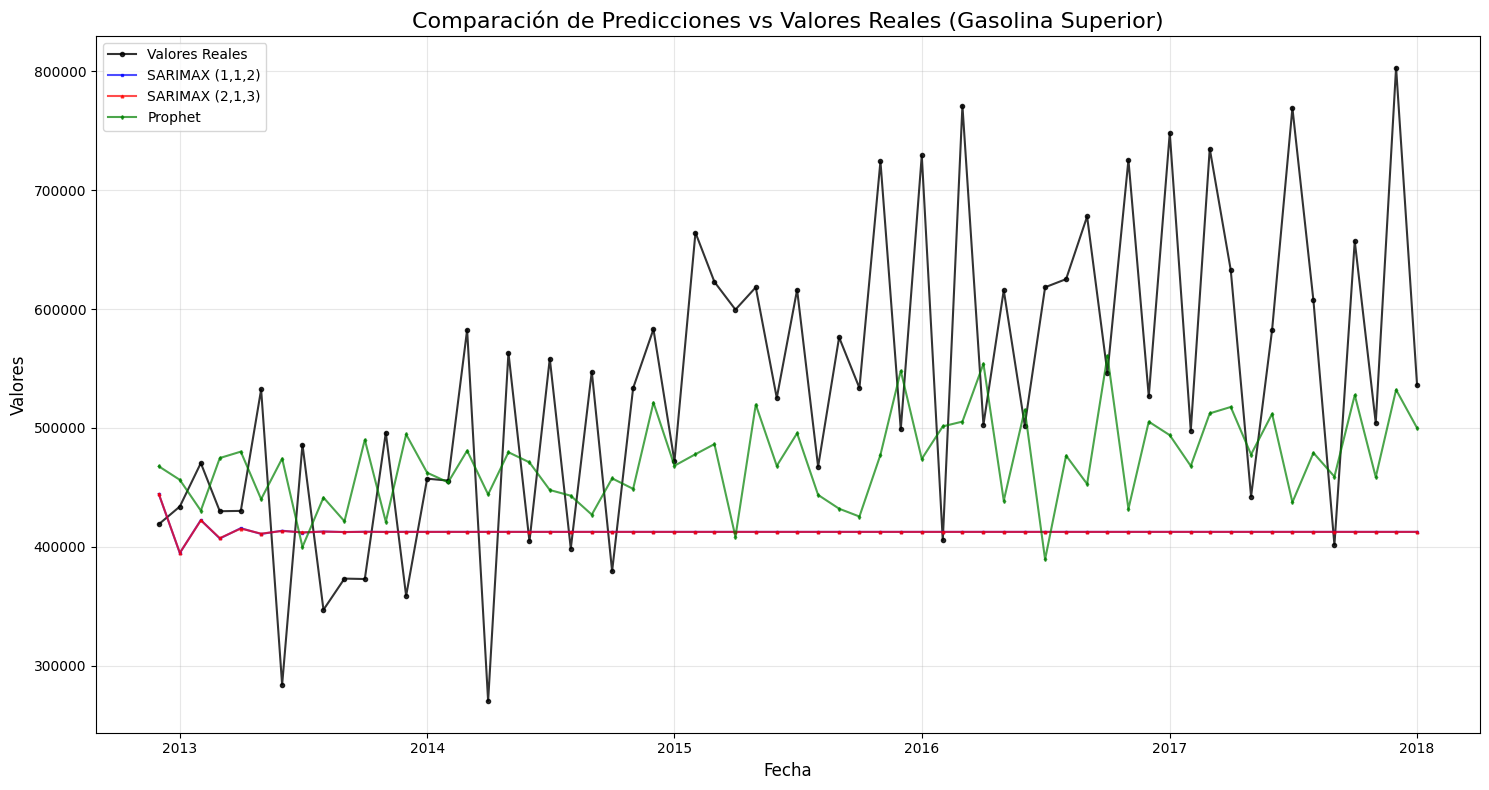


📋 Comparación de Predicciones vs Reales:
                Fecha       Real  SARIMAX (1,1,2)  SARIMAX (2,1,3)    Prophet
2012-12-01 2012-12-01  419029.17        444418.28        444493.14  467736.43
2013-01-01 2013-01-01  433924.69        394803.79        394901.61  456375.56
2013-02-01 2013-02-01  470483.98        422551.28        422310.10  430459.41
2013-03-01 2013-03-01  429974.17        407033.17        407322.35  474715.54
2013-04-01 2013-04-01  430259.18        415711.86        415428.46  480097.28
2013-05-01 2013-05-01  532379.66        410858.20        411094.85  440113.64
2013-06-01 2013-06-01  284038.03        413572.67        413382.78  474304.64
2013-07-01 2013-07-01  486075.06        412054.57        412191.53  399920.17
2013-08-01 2013-08-01  347066.11        412903.58        412802.04  441511.06
2013-09-01 2013-09-01  373303.31        412428.76        412494.93  421499.84
2013-10-01 2013-10-01  372946.33        412694.31        412645.94  490141.98
2013-11-01 2013-11-01 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/sqa6iyny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/wa_s8wy3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43444', 'data', 'file=/tmp/tmpa94co83t/sqa6iyny.json', 'init=/tmp/tmpa94co83t/wa_s8wy3.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelm0pjb2sk/prophet_model-20250721062253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:22:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📉 Errores (RMSE):
SARIMAX (1,1,2): 345204.25
SARIMAX (2,1,3): 343817.15
Prophet: 223864.15


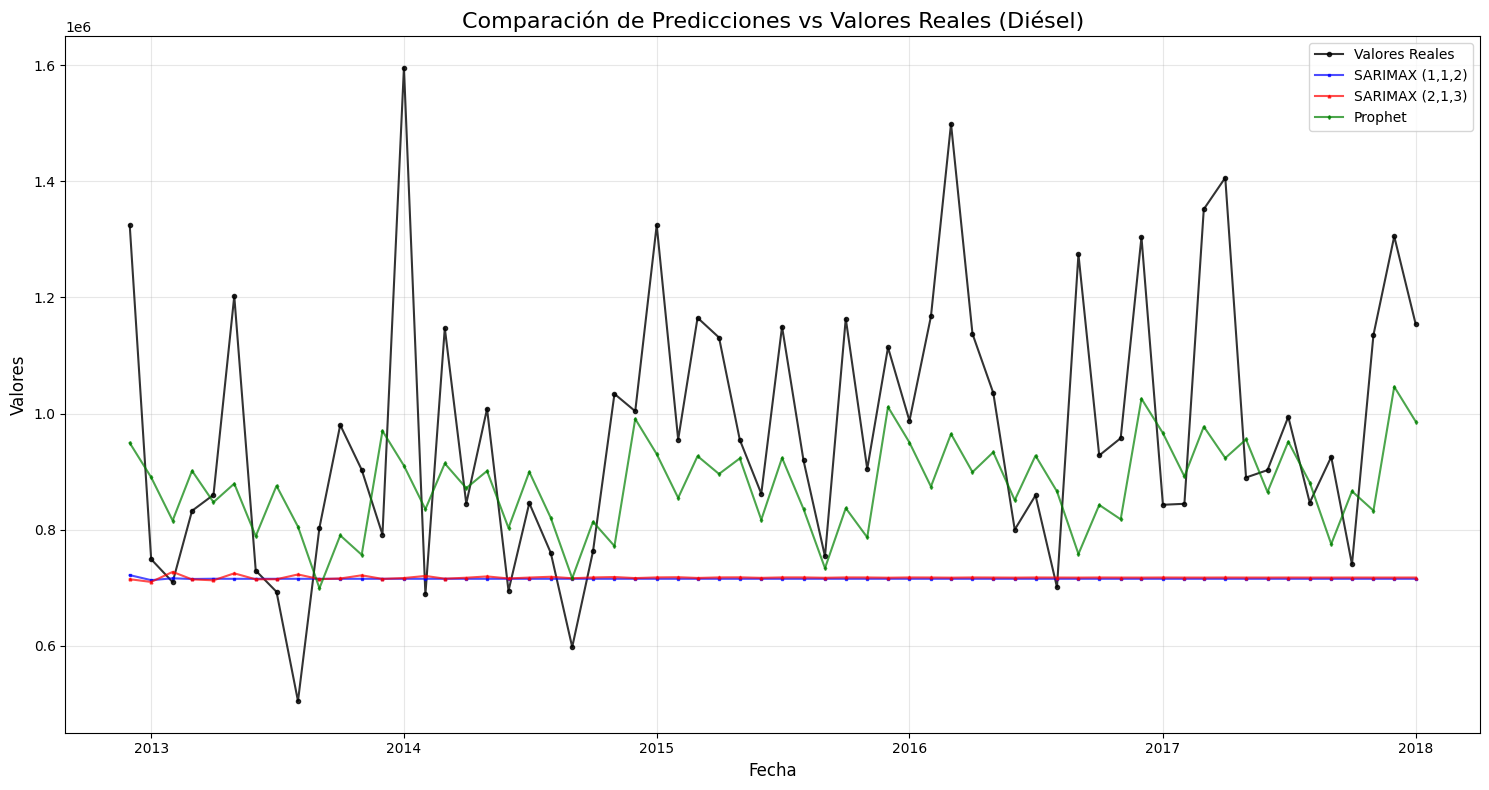


📋 Comparación de Predicciones vs Reales:
                Fecha        Real  SARIMAX (1,1,2)  SARIMAX (2,1,3)    Prophet
2012-12-01 2012-12-01  1324780.96        721910.41        714870.93  949561.34
2013-01-01 2013-01-01   749266.68        713250.96        710142.11  890234.57
2013-02-01 2013-02-01   709843.02        716403.18        727459.65  815758.21
2013-03-01 2013-03-01   832627.57        715255.71        714576.29  901514.90
2013-04-01 2013-04-01   860094.78        715673.41        712935.56  847389.32
2013-05-01 2013-05-01  1202187.85        715521.36        725000.65  879420.47
2013-06-01 2013-06-01   729711.88        715576.71        714679.52  788921.79
2013-07-01 2013-07-01   693160.50        715556.56        714836.10  875694.87
2013-08-01 2013-08-01   505133.44        715563.89        723080.61  805274.52
2013-09-01 2013-09-01   803626.98        715561.22        714988.43  699294.44
2013-10-01 2013-10-01   980327.98        715562.19        716099.55  790250.08
2013-11-01

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/kzn4zsw8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/ucke5o41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41177', 'data', 'file=/tmp/tmpa94co83t/kzn4zsw8.json', 'init=/tmp/tmpa94co83t/ucke5o41.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelprfcl69w/prophet_model-20250721062254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:22:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📉 Errores (RMSE):
SARIMAX (1,1,2): 206845.98
SARIMAX (2,1,3): 208298.85
Prophet: 149760.49


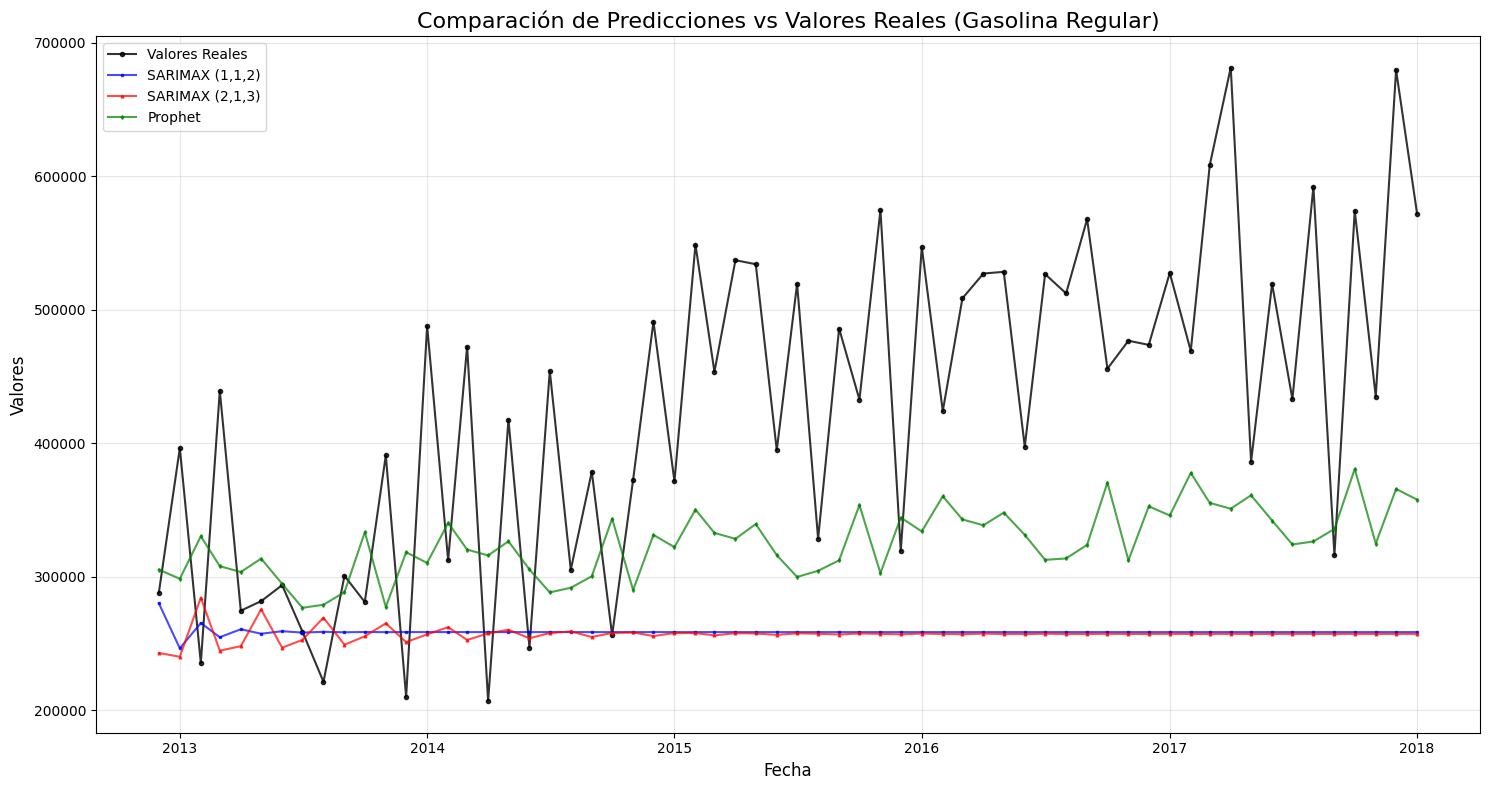


📋 Comparación de Predicciones vs Reales:
                Fecha       Real  SARIMAX (1,1,2)  SARIMAX (2,1,3)    Prophet
2012-12-01 2012-12-01  287980.58        280322.89        243034.15  305415.96
2013-01-01 2013-01-01  396416.84        246503.40        240191.10  298577.30
2013-02-01 2013-02-01  235502.58        265475.00        284531.75  330445.93
2013-03-01 2013-03-01  439386.62        254832.57        244758.21  307984.77
2013-04-01 2013-04-01  274680.65        260802.62        248122.02  303642.45
2013-05-01 2013-05-01  281823.20        257453.62        275691.44  313691.32
2013-06-01 2013-06-01  293808.60        259332.29        246993.92  294807.59
2013-07-01 2013-07-01  259025.83        258278.42        252841.22  276867.03
2013-08-01 2013-08-01  221433.20        258869.61        269495.68  279119.67
2013-09-01 2013-09-01  300794.99        258537.97        249209.73  288529.43
2013-10-01 2013-10-01  281168.85        258724.01        255534.44  333410.99
2013-11-01 2013-11-01 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/wdquos3c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/3qsuv1n7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1046', 'data', 'file=/tmp/tmpa94co83t/wdquos3c.json', 'init=/tmp/tmpa94co83t/3qsuv1n7.json', 'output', 'file=/tmp/tmpa94co83t/prophet_model0yaq1uwm/prophet_model-20250721062255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:22:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:22:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📉 Errores (RMSE):
SARIMAX (1,1,2): 175681.93
SARIMAX (2,1,3): 180503.44
Prophet: 132388.35


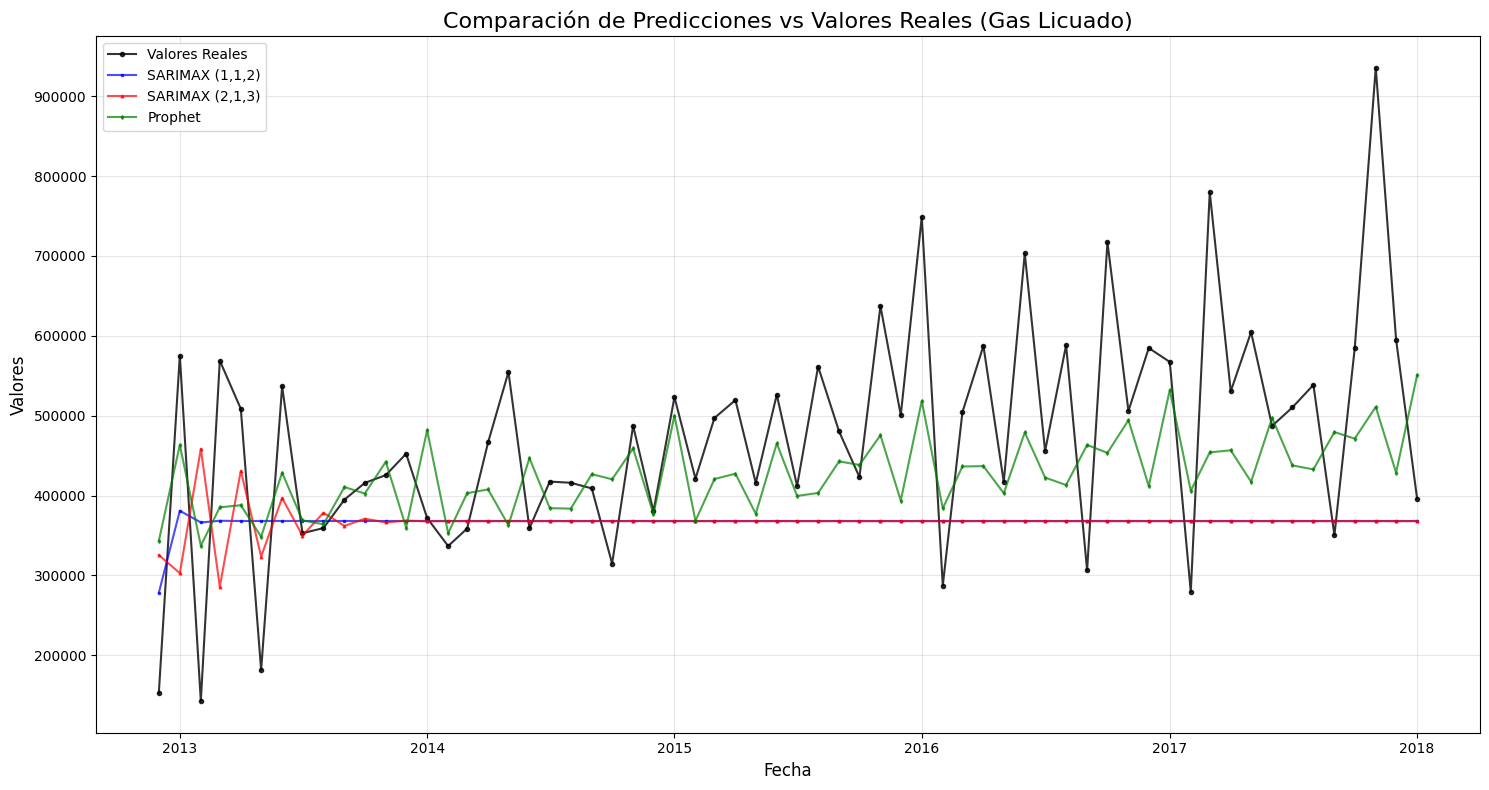


📋 Comparación de Predicciones vs Reales:
                Fecha       Real  SARIMAX (1,1,2)  SARIMAX (2,1,3)    Prophet
2012-12-01 2012-12-01  152926.76        278240.03        325648.32  343159.88
2013-01-01 2013-01-01  575318.45        380993.41        302871.95  463476.91
2013-02-01 2013-02-01  142772.81        366402.93        458586.34  337318.45
2013-03-01 2013-03-01  569013.24        368474.71        285798.42  385319.81
2013-04-01 2013-04-01  508649.45        368180.52        431261.19  387958.34
2013-05-01 2013-05-01  181461.60        368222.30        323593.89  348537.99
2013-06-01 2013-06-01  536847.17        368216.36        397053.47  428680.42
2013-07-01 2013-07-01  352909.02        368217.21        349920.21  369032.26
2013-08-01 2013-08-01  359346.00        368217.09        378608.98  364048.04
2013-09-01 2013-09-01  394985.89        368217.10        362005.45  410786.91
2013-10-01 2013-10-01  415869.34        368217.10        371114.32  402549.40
2013-11-01 2013-11-01 

In [47]:
def preparar_serie(ts, start_year, start_month):
    """
    Forzar índice de fechas mensual a partir de un año y mes inicial
    """
    ts = ts.copy()
    fechas = pd.date_range(start=f"{start_year}-{start_month:02d}", periods=len(ts), freq="MS")
    ts.index = fechas
    return ts

def evaluar_series(ts, name, start_year=2001, start_month=1):
    print(f"\n==== Predicción y Evaluación para {name} ====")

    # Corregir fechas
    ts = preparar_serie(ts, start_year, start_month)

    # Dividir en train (70%) y test (30%)
    train_size = int(len(ts) * 0.7)
    train = ts[:train_size]
    test = ts[train_size:]

    # Fechas para test
    if hasattr(test, 'index'):
        fechas_test = test.index
    else:
        fechas_test = pd.date_range(start=f"{train.index[-1] + pd.DateOffset(months=1)}",
                                    periods=len(test), freq='MS')

    # ========================
    # Modelos
    # ========================
    # SARIMAX (1,1,2)
    model_111 = SARIMAX(train, order=(1,1,2), seasonal_order=(0,0,0,0)).fit(disp=False)
    pred_111 = model_111.forecast(steps=len(test))

    # SARIMAX (2,1,3)
    model_212 = SARIMAX(train, order=(2,1,3), seasonal_order=(0,0,0,0)).fit(disp=False)
    pred_212 = model_212.forecast(steps=len(test))

    # Prophet
    df_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})
    model_prophet = Prophet()
    model_prophet.fit(df_prophet)
    future_df = pd.DataFrame({'ds': fechas_test})
    forecast_prophet = model_prophet.predict(future_df)
    pred_prophet = forecast_prophet['yhat'].values

    # ========================
    # RMSE
    # ========================
    rmse_111 = np.sqrt(mean_squared_error(test, pred_111))
    rmse_212 = np.sqrt(mean_squared_error(test, pred_212))
    rmse_prophet = np.sqrt(mean_squared_error(test, pred_prophet))
    print("\n📉 Errores (RMSE):")
    print(f"SARIMAX (1,1,2): {rmse_111:.2f}")
    print(f"SARIMAX (2,1,3): {rmse_212:.2f}")
    print(f"Prophet: {rmse_prophet:.2f}")

    # ========================
    # Gráfico
    # ========================
    plt.figure(figsize=(15, 8))
    plt.plot(fechas_test, test, 'o-', label='Valores Reales', color='black', markersize=3, alpha=0.8)
    plt.plot(fechas_test, pred_111, 's-', label='SARIMAX (1,1,2)', color='blue', markersize=2, alpha=0.7)
    plt.plot(fechas_test, pred_212, '^-', label='SARIMAX (2,1,3)', color='red', markersize=2, alpha=0.7)
    plt.plot(fechas_test, pred_prophet, 'd-', label='Prophet', color='green', markersize=2, alpha=0.7)

    plt.title(f'Comparación de Predicciones vs Valores Reales ({name})', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Valores', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ========================
    # Tabla comparativa
    # ========================
    df_resultados = pd.DataFrame({
        'Fecha': fechas_test,
        'Real': test.values,
        'SARIMAX (1,1,2)': pred_111,
        'SARIMAX (2,1,3)': pred_212,
        'Prophet': pred_prophet
    })
    print("\n📋 Comparación de Predicciones vs Reales:")
    print(df_resultados.round(2).head(12))  # Mostrar primeras filas

# ========================
# 🚀 Ejecutar para cada serie
# ========================
# Cambia el start_year/start_month si tu serie empieza en otro año
evaluar_series(ts_importa_superior, "Gasolina Superior", start_year=2001, start_month=1)
evaluar_series(ts_importa_diesel, "Diésel", start_year=2001, start_month=1)
evaluar_series(ts_importa_regular, "Gasolina Regular", start_year=2001, start_month=1)

evaluar_series(ts_importa_licuado, "Gas Licuado", start_year=2001, start_month=1)


*   **Análisis para Importaciones de Gasolina Superior**
    La evaluación de los modelos muestra que **Prophet** es claramente superior. Los modelos SARIMAX generan una predicción casi plana, incapaz de seguir la tendencia o la estacionalidad de los datos. Esto se confirma con el Error Cuadrático Medio (RMSE), donde Prophet obtiene un valor de **137,413.03**, considerablemente más bajo que el de los modelos SARIMAX (ambos alrededor de 174,478). La predicción de Prophet es **moderadamente buena**; captura la tendencia y el patrón estacional, pero subestima la magnitud de los picos y valles más extremos.

*   **Análisis para Importaciones de Gasolina Regular**
    En este caso, el resultado es muy similar. El modelo **Prophet** es el claro ganador con un RMSE de **149,760.49**, demostrando ser mucho más preciso que los modelos SARIMAX, cuyos errores superan los 206,000. Al igual que con la gasolina superior, los modelos SARIMAX no logran capturar la dinámica compleja de la serie. La predicción de Prophet es **aceptable**, ya que sigue la tendencia y la estacionalidad, pero no logra predecir la alta volatilidad de los valores reales.

*   **Análisis para Importaciones de Diésel**
    Nuevamente, **Prophet** se establece como el modelo más eficaz con un RMSE de **223,864.15**, muy por debajo de los errores de los modelos SARIMAX (superiores a 343,000). Esto indica que los modelos SARIMAX son inadecuados para esta serie. La predicción de Prophet es **la más útil de las tres**, ya que logra seguir la tendencia y la forma general de los datos, aunque, como en los otros casos, no captura la magnitud total de la volatilidad, lo que la califica como una predicción **moderadamente buena**.

*   **Análisis para Importaciones de Gas Licuado**
    La gráfica y los datos del RMSE para el Gas Licuado confirman el patrón. El modelo **Prophet** es el mejor, con un error de **132,388.35**, mientras que los modelos SARIMAX (con errores sobre 175,000) producen una predicción plana e inútil. La predicción de Prophet es **regular**; identifica correctamente la tendencia general al alza y la estacionalidad, pero subestima consistentemente los valores reales, especialmente en los años más recientes. Es útil para entender la dirección del mercado, pero no para predecir volúmenes exactos.

II. Consumo


==== Predicción y Evaluación para Gasolina Superior ====


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/ii63oxoa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/0hpn_7c3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18031', 'data', 'file=/tmp/tmpa94co83t/ii63oxoa.json', 'init=/tmp/tmpa94co83t/0hpn_7c3.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modeltsr81ezf/prophet_model-20250721061436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📉 Errores (RMSE):
SARIMAX (1,1,2): 106636.05
SARIMAX (2,1,3): 106883.40
Prophet: 109508.69


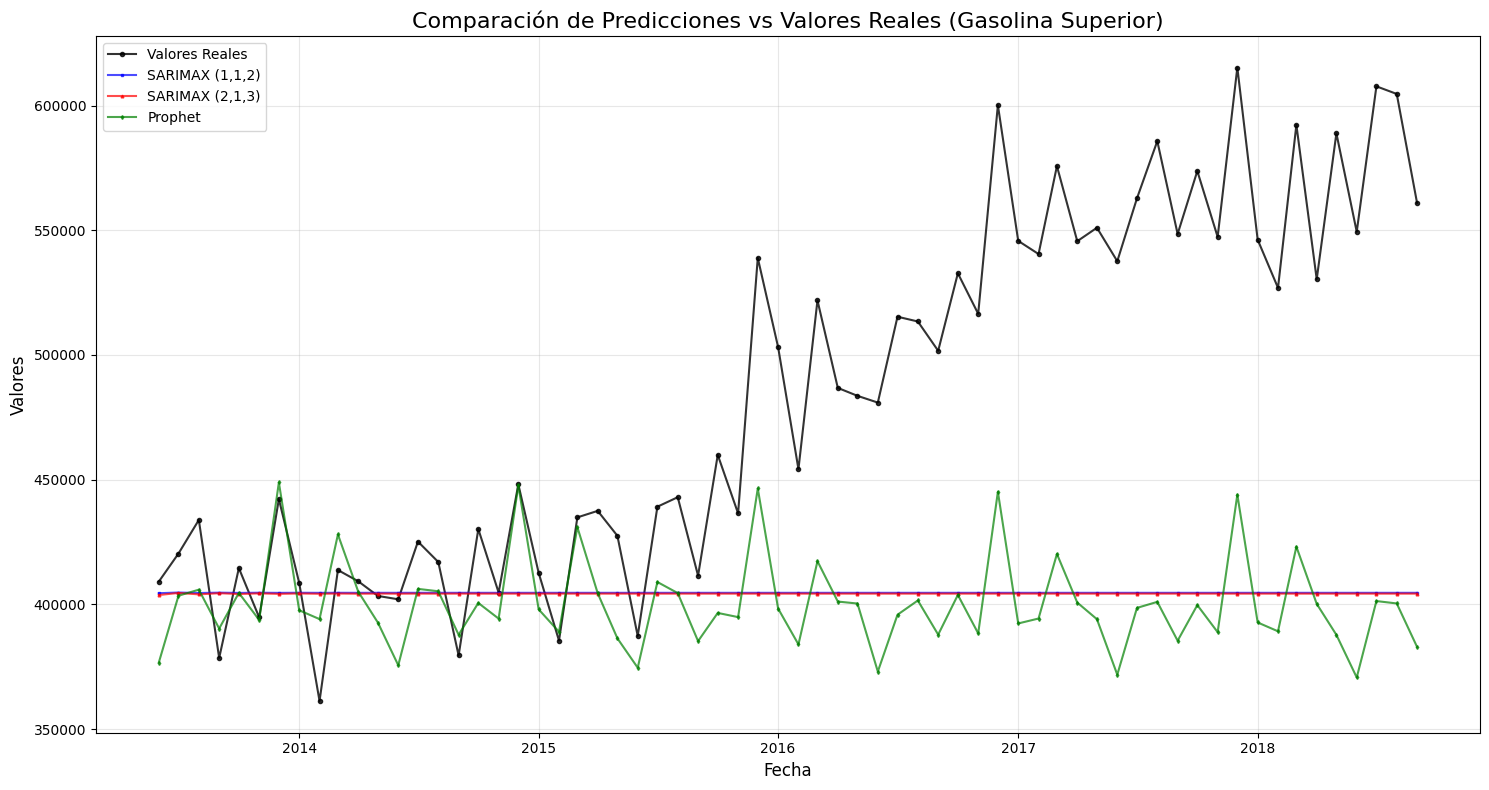


📋 Comparación de Predicciones vs Reales:
                Fecha       Real  SARIMAX (1,1,2)  SARIMAX (2,1,3)    Prophet
2013-06-01 2013-06-01  409111.24        404457.00        403727.02  376669.00
2013-07-01 2013-07-01  420370.60        404729.92        404562.71  403450.02
2013-08-01 2013-08-01  433828.02        404529.90        403992.88  405875.51
2013-09-01 2013-09-01  378478.80        404676.50        404462.67  390290.07
2013-10-01 2013-10-01  414523.22        404569.06        404124.34  404576.96
2013-11-01 2013-11-01  394751.47        404647.80        404392.43  393715.43
2013-12-01 2013-12-01  442191.43        404590.09        404193.95  448850.24
2014-01-01 2014-01-01  408557.45        404632.38        404348.13  397612.71
2014-02-01 2014-02-01  361215.69        404601.39        404232.38  394069.74
2014-03-01 2014-03-01  413744.86        404624.10        404321.40  428010.18
2014-04-01 2014-04-01  409238.30        404607.45        404254.10  405081.10
2014-05-01 2014-05-01 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/fv0rttju.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/fm21my2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80411', 'data', 'file=/tmp/tmpa94co83t/fv0rttju.json', 'init=/tmp/tmpa94co83t/fm21my2p.json', 'output', 'file=/tmp/tmpa94co83t/prophet_model8w5zt0ss/prophet_model-20250721061437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📉 Errores (RMSE):
SARIMAX (1,1,2): 160019.16
SARIMAX (2,1,3): 156623.08
Prophet: 114542.56


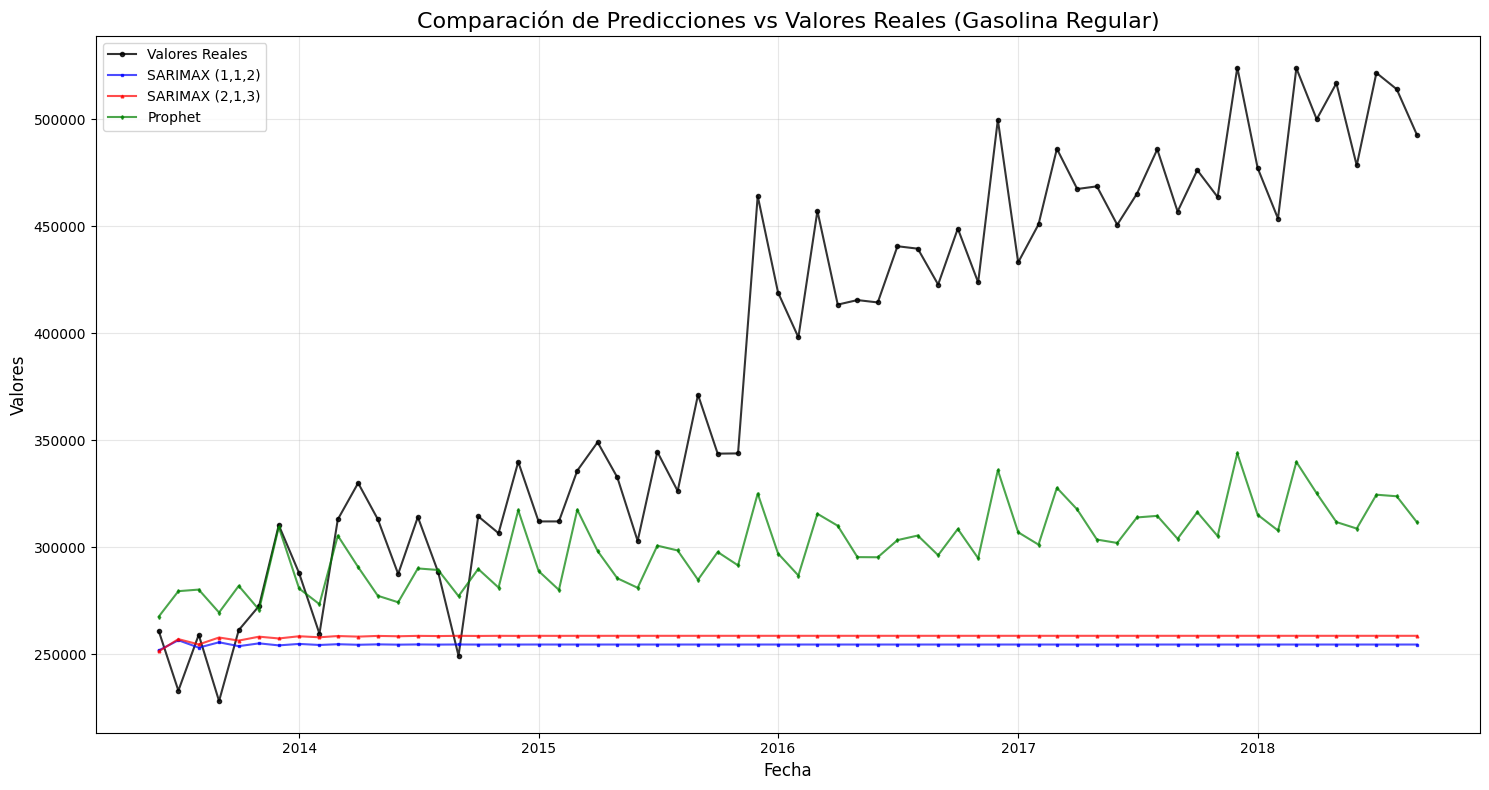


📋 Comparación de Predicciones vs Reales:
                Fecha       Real  SARIMAX (1,1,2)  SARIMAX (2,1,3)    Prophet
2013-06-01 2013-06-01  261012.58        251840.61        251406.59  267634.09
2013-07-01 2013-07-01  233061.35        256619.14        257145.92  279549.68
2013-08-01 2013-08-01  259165.94        253161.96        254656.72  280286.43
2013-09-01 2013-09-01  228205.77        255663.17        257896.20  269570.24
2013-10-01 2013-10-01  261347.22        253853.58        256455.57  282021.67
2013-11-01 2013-11-01  272657.82        255162.79        258284.63  270855.02
2013-12-01 2013-12-01  310407.04        254215.60        257451.62  309509.05
2014-01-01 2014-01-01  287985.59        254900.88        258484.66  280800.66
2014-02-01 2014-02-01  259659.66        254405.09        258003.40  273461.12
2014-03-01 2014-03-01  313075.45        254763.78        258587.03  305495.87
2014-04-01 2014-04-01  330070.65        254504.28        258309.20  290819.19
2014-05-01 2014-05-01 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/7wnshiq1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/1fqsgct0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67321', 'data', 'file=/tmp/tmpa94co83t/7wnshiq1.json', 'init=/tmp/tmpa94co83t/1fqsgct0.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelsdst0442/prophet_model-20250721061438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📉 Errores (RMSE):
SARIMAX (1,1,2): 157595.49
SARIMAX (2,1,3): 138973.82
Prophet: 104270.23


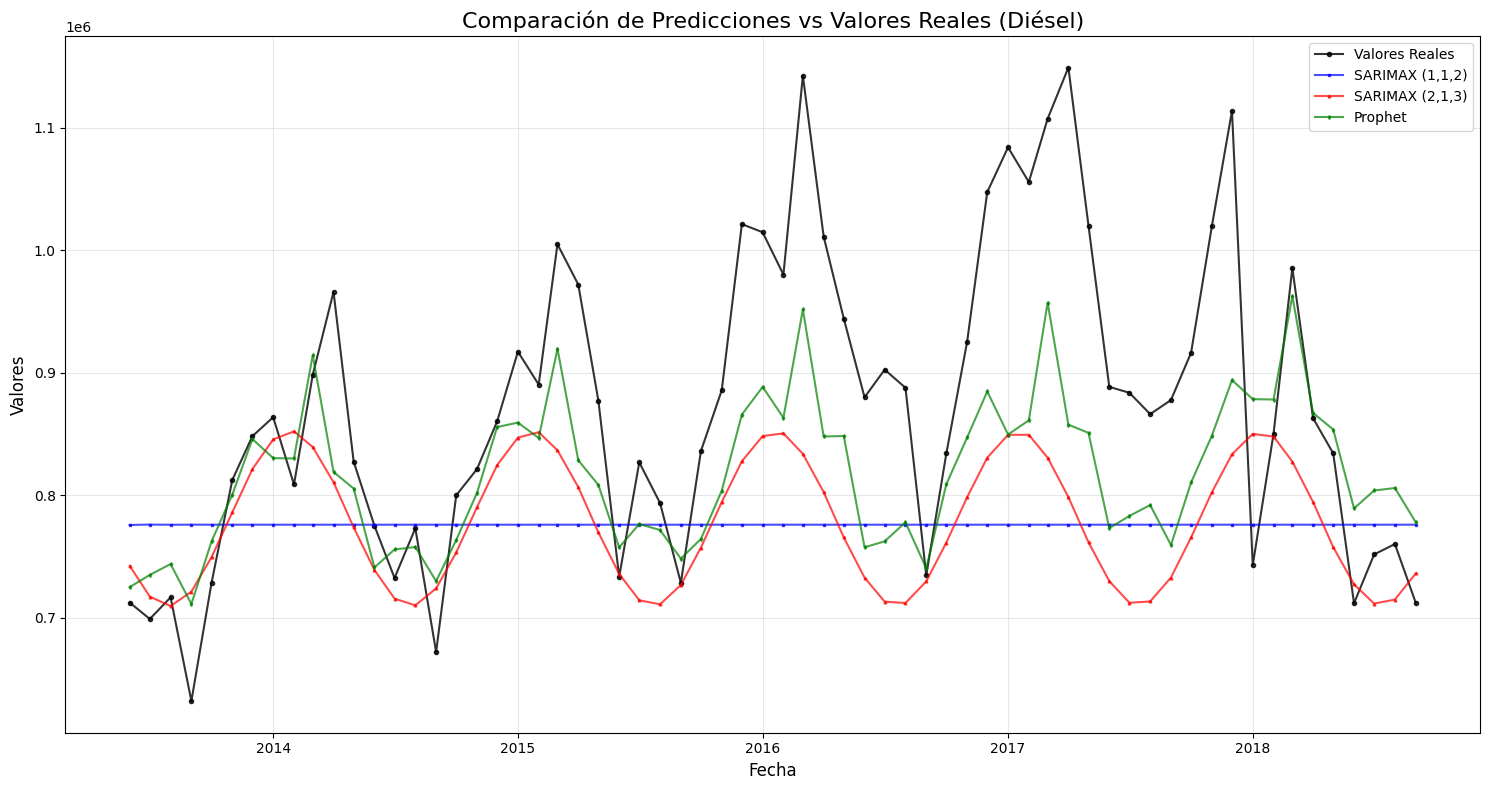


📋 Comparación de Predicciones vs Reales:
                Fecha       Real  SARIMAX (1,1,2)  SARIMAX (2,1,3)    Prophet
2013-06-01 2013-06-01  712464.94        775834.17        742457.71  725152.99
2013-07-01 2013-07-01  699130.04        776129.30        717353.96  735059.78
2013-08-01 2013-08-01  716720.36        776016.25        709646.54  743927.09
2013-09-01 2013-09-01  632120.37        776059.55        721429.59  711297.32
2013-10-01 2013-10-01  728414.88        776042.96        749478.42  762377.49
2013-11-01 2013-11-01  812523.44        776049.32        786132.00  800511.98
2013-12-01 2013-12-01  848262.93        776046.88        821385.47  845961.75
2014-01-01 2014-01-01  863769.41        776047.82        845620.97  830364.45
2014-02-01 2014-02-01  808853.97        776047.46        852231.65  830086.35
2014-03-01 2014-03-01  898352.20        776047.60        839422.71  914515.57
2014-04-01 2014-04-01  966103.92        776047.54        810698.71  819128.76
2014-05-01 2014-05-01 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/r74om55g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/sd_qu1v4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51564', 'data', 'file=/tmp/tmpa94co83t/r74om55g.json', 'init=/tmp/tmpa94co83t/sd_qu1v4.json', 'output', 'file=/tmp/tmpa94co83t/prophet_model5piq6xwl/prophet_model-20250721061440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:14:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:14:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📉 Errores (RMSE):
SARIMAX (1,1,2): 74952.37
SARIMAX (2,1,3): 76490.81
Prophet: 61937.01


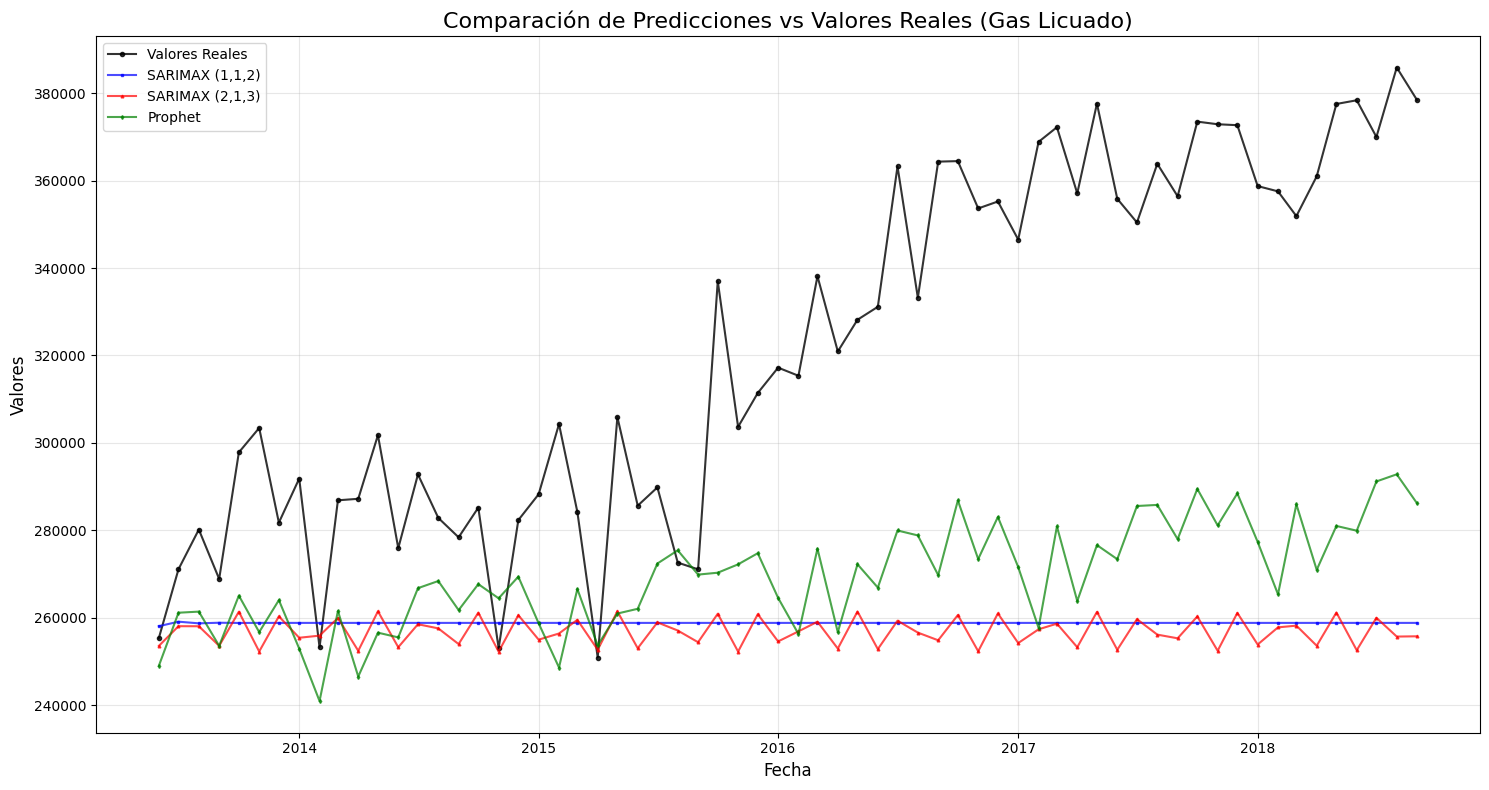


📋 Comparación de Predicciones vs Reales:
                Fecha       Real  SARIMAX (1,1,2)  SARIMAX (2,1,3)    Prophet
2013-06-01 2013-06-01  255333.43        258070.41        253554.00  248984.97
2013-07-01 2013-07-01  271101.94        259100.23        258069.24  261151.99
2013-08-01 2013-08-01  280184.27        258720.82        258056.71  261402.14
2013-09-01 2013-09-01  268875.10        258860.61        253572.05  253569.77
2013-10-01 2013-10-01  297829.17        258809.11        261383.25  265067.54
2013-11-01 2013-11-01  303422.01        258828.08        252275.74  256713.94
2013-12-01 2013-12-01  281757.56        258821.09        260317.44  264029.90
2014-01-01 2014-01-01  291844.00        258823.67        255422.93  252939.93
2014-02-01 2014-02-01  253221.89        258822.72        255908.30  240944.49
2014-03-01 2014-03-01  286869.62        258823.07        259949.24  261538.63
2014-04-01 2014-04-01  287216.30        258822.94        252437.73  246546.11
2014-05-01 2014-05-01 

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error

def preparar_serie(ts, start_year, start_month):
    ts = ts.copy()
    fechas = pd.date_range(start=f"{start_year}-{start_month:02d}", periods=len(ts), freq="MS")
    ts.index = fechas
    return ts

def evaluar_series(ts, name, start_year=2001, start_month=1):
    print(f"\n==== Predicción y Evaluación para {name} ====")

    ts = preparar_serie(ts, start_year, start_month)

    train_size = int(len(ts) * 0.7)
    train = ts[:train_size]
    test = ts[train_size:]

    fechas_test = test.index

    model_111 = SARIMAX(train, order=(1,1,2), seasonal_order=(0,0,0,0)).fit(disp=False)
    pred_111 = model_111.forecast(steps=len(test))

    model_212 = SARIMAX(train, order=(2,1,3), seasonal_order=(0,0,0,0)).fit(disp=False)
    pred_212 = model_212.forecast(steps=len(test))

    df_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})
    model_prophet = Prophet()
    model_prophet.fit(df_prophet)
    future_df = pd.DataFrame({'ds': fechas_test})
    forecast_prophet = model_prophet.predict(future_df)
    pred_prophet = forecast_prophet['yhat'].values

    rmse_111 = np.sqrt(mean_squared_error(test, pred_111))
    rmse_212 = np.sqrt(mean_squared_error(test, pred_212))
    rmse_prophet = np.sqrt(mean_squared_error(test, pred_prophet))

    print("\n📉 Errores (RMSE):")
    print(f"SARIMAX (1,1,2): {rmse_111:.2f}")
    print(f"SARIMAX (2,1,3): {rmse_212:.2f}")
    print(f"Prophet: {rmse_prophet:.2f}")

    plt.figure(figsize=(15, 8))
    plt.plot(fechas_test, test, 'o-', label='Valores Reales', color='black', markersize=3, alpha=0.8)
    plt.plot(fechas_test, pred_111, 's-', label='SARIMAX (1,1,2)', color='blue', markersize=2, alpha=0.7)
    plt.plot(fechas_test, pred_212, '^-', label='SARIMAX (2,1,3)', color='red', markersize=2, alpha=0.7)
    plt.plot(fechas_test, pred_prophet, 'd-', label='Prophet', color='green', markersize=2, alpha=0.7)

    plt.title(f'Comparación de Predicciones vs Valores Reales ({name})', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Valores', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    df_resultados = pd.DataFrame({
        'Fecha': fechas_test,
        'Real': test.values,
        'SARIMAX (1,1,2)': pred_111,
        'SARIMAX (2,1,3)': pred_212,
        'Prophet': pred_prophet
    })
    print("\n📋 Comparación de Predicciones vs Reales:")
    print(df_resultados.round(2).head(12))

# Ejemplo: cambia estos por tus series de consumo
series_consumo = [
    (ts_consu_superior, "Gasolina Superior"),
    (ts_consu_regular, "Gasolina Regular"),
    (ts_consu_diesel, "Diésel"),
    (ts_consu_licuado, "Gas Licuado")
]

for ts, nombre in series_consumo:
    evaluar_series(ts, nombre, start_year=2001, start_month=1)


*   **Análisis de la Predicción para Gas Licuado**
    La evaluación de los modelos para el Gas Licuado muestra un resultado muy claro. Visualmente, los modelos **SARIMAX** (líneas azul y roja) fallan por completo al generar una predicción casi plana, incapaz de seguir la evidente tendencia creciente y la estacionalidad de los datos reales. En contraste, el modelo **Prophet** (línea verde) sí logra capturar la tendencia ascendente y los patrones estacionales, aunque de forma imperfecta.

*   **Evaluación del Rendimiento de los Modelos**
    Los Errores Cuadráticos Medios (RMSE) confirman lo que la gráfica muestra. El modelo **Prophet es el ganador indiscutible** con un RMSE de **61,937.01**, el más bajo de los tres. Los modelos SARIMAX tienen errores considerablemente más altos (74,952.37 y 76,490.81), validando su pobre desempeño y su incapacidad para modelar esta serie de tiempo compleja.

*   **Calidad de la Mejor Predicción (Prophet)**
    La predicción de Prophet es **aceptable, pero con limitaciones importantes**. Su mayor acierto es identificar correctamente la tendencia alcista a largo plazo y la naturaleza estacional del consumo. Sin embargo, su principal defecto es que **subestima sistemáticamente los valores reales**, especialmente después de 2016, cuando el consumo real se dispara. El modelo sigue la forma de los datos, pero no su magnitud. Por lo tanto, la predicción es útil para entender la dirección general del mercado, pero no es lo suficientemente precisa para estimar los volúmenes exactos de consumo.

III. Precio


==== Predicción (últimos 3 años) para Gasolina Superior ====
📅 Entrenamiento: 2001-01-01 a 2024-12-01
📅 Prueba: 2025-01-01 a 2090-06-01


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/g8h4kbn6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/k6gh70ml.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83476', 'data', 'file=/tmp/tmpa94co83t/g8h4kbn6.json', 'init=/tmp/tmpa94co83t/k6gh70ml.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelpz49m199/prophet_model-20250721062031.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:20:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📉 Errores (RMSE):
SARIMAX (1,1,2): 3.43
SARIMAX (2,1,3): 3.43
Prophet: 3.69


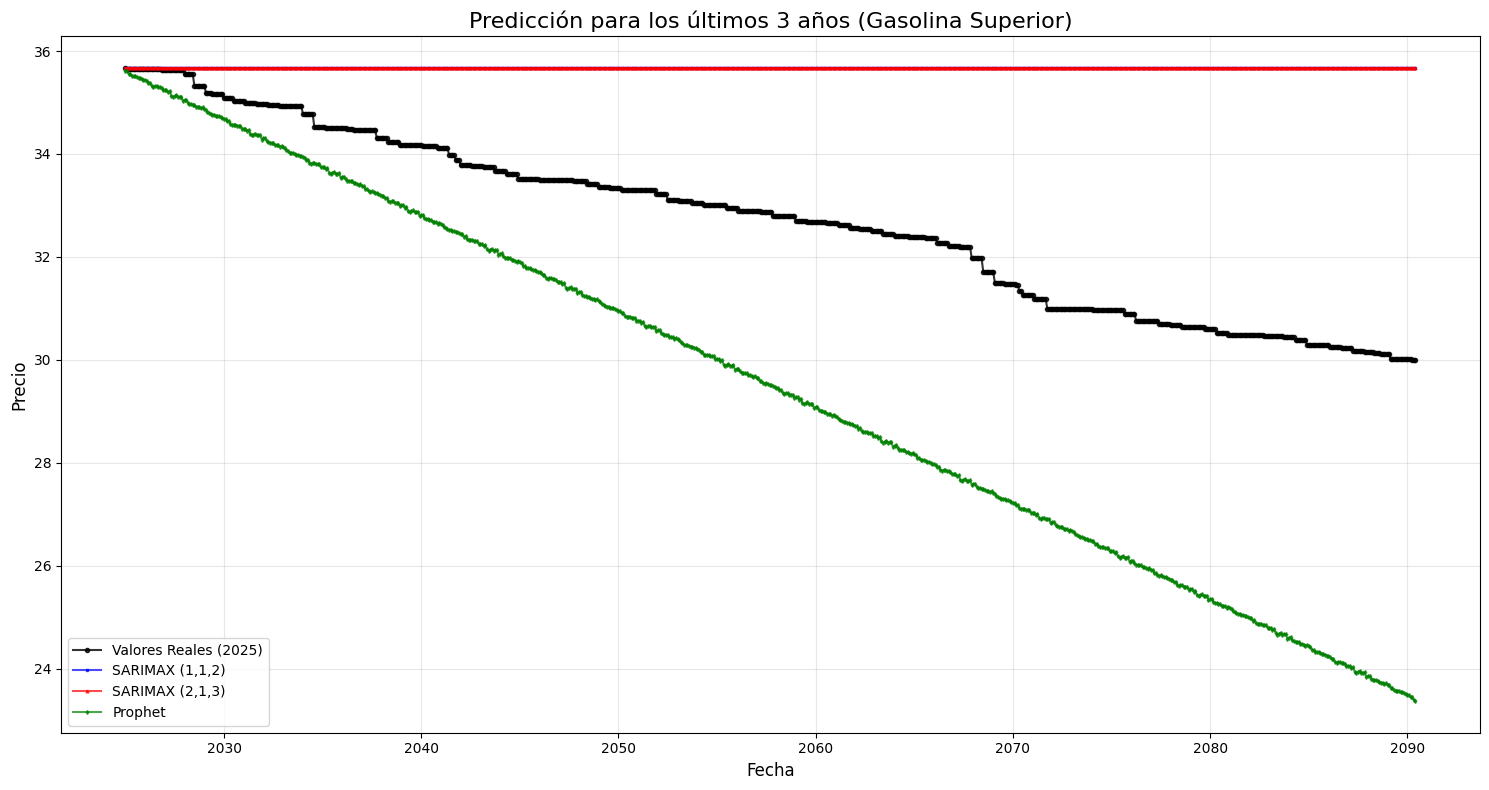


📋 Comparación de Predicciones vs Reales:
                Fecha   Real  SARIMAX (1,1,2)  SARIMAX (2,1,3)  Prophet
2025-01-01 2025-01-01  35.68            35.68            35.68    35.62
2025-02-01 2025-02-01  35.66            35.68            35.68    35.61
2025-03-01 2025-03-01  35.66            35.68            35.68    35.56
2025-04-01 2025-04-01  35.66            35.68            35.68    35.55
2025-05-01 2025-05-01  35.66            35.68            35.68    35.52
2025-06-01 2025-06-01  35.66            35.68            35.68    35.51
2025-07-01 2025-07-01  35.66            35.68            35.68    35.51
2025-08-01 2025-08-01  35.66            35.68            35.68    35.49
2025-09-01 2025-09-01  35.66            35.68            35.68    35.48
2025-10-01 2025-10-01  35.66            35.68            35.68    35.48
2025-11-01 2025-11-01  35.66            35.68            35.68    35.46
2025-12-01 2025-12-01  35.66            35.68            35.68    35.44

==== Predicción (últi

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/xafuu1bs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/0a_whenv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35251', 'data', 'file=/tmp/tmpa94co83t/xafuu1bs.json', 'init=/tmp/tmpa94co83t/0a_whenv.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelem19tvej/prophet_model-20250721062033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📉 Errores (RMSE):
SARIMAX (1,1,2): 3.35
SARIMAX (2,1,3): 3.35
Prophet: 32.85


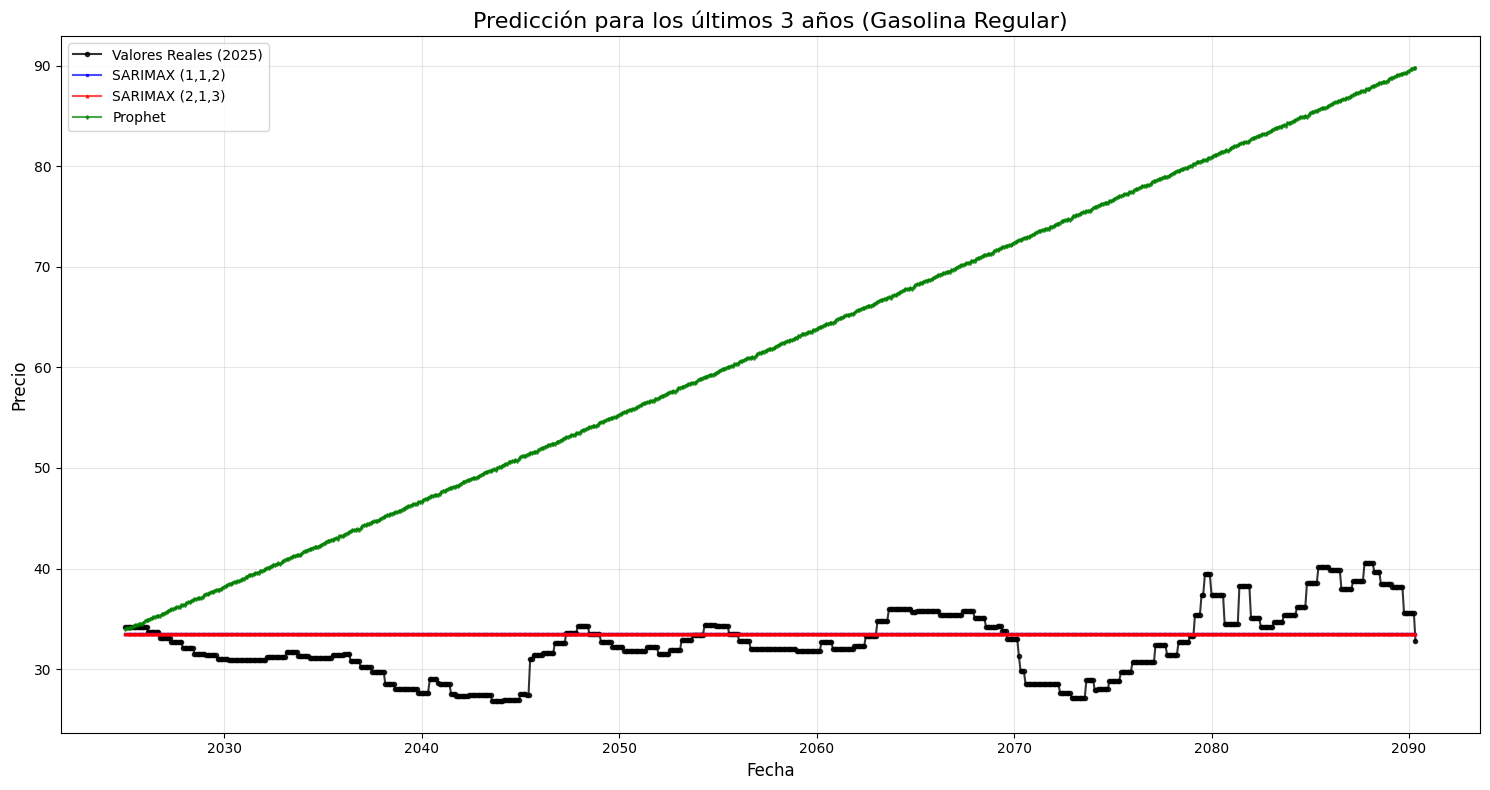


📋 Comparación de Predicciones vs Reales:
                Fecha   Real  SARIMAX (1,1,2)  SARIMAX (2,1,3)  Prophet
2025-01-01 2025-01-01  34.14            33.48            33.48    33.94
2025-02-01 2025-02-01  34.14            33.48            33.48    34.04
2025-03-01 2025-03-01  34.14            33.48            33.48    34.06
2025-04-01 2025-04-01  34.14            33.48            33.48    34.12
2025-05-01 2025-05-01  34.14            33.48            33.48    34.20
2025-06-01 2025-06-01  34.14            33.48            33.48    34.29
2025-07-01 2025-07-01  34.14            33.48            33.48    34.36
2025-08-01 2025-08-01  34.18            33.48            33.48    34.41
2025-09-01 2025-09-01  34.18            33.48            33.48    34.45
2025-10-01 2025-10-01  34.18            33.48            33.48    34.48
2025-11-01 2025-11-01  34.18            33.48            33.48    34.52
2025-12-01 2025-12-01  34.18            33.48            33.48    34.63

==== Predicción (últi

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/wuhanxcm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/8kjynqag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75037', 'data', 'file=/tmp/tmpa94co83t/wuhanxcm.json', 'init=/tmp/tmpa94co83t/8kjynqag.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelo9vqb6_f/prophet_model-20250721062034.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:20:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:20:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



📉 Errores (RMSE):
SARIMAX (1,1,2): 3.59
SARIMAX (2,1,3): 3.59
Prophet: 8.45


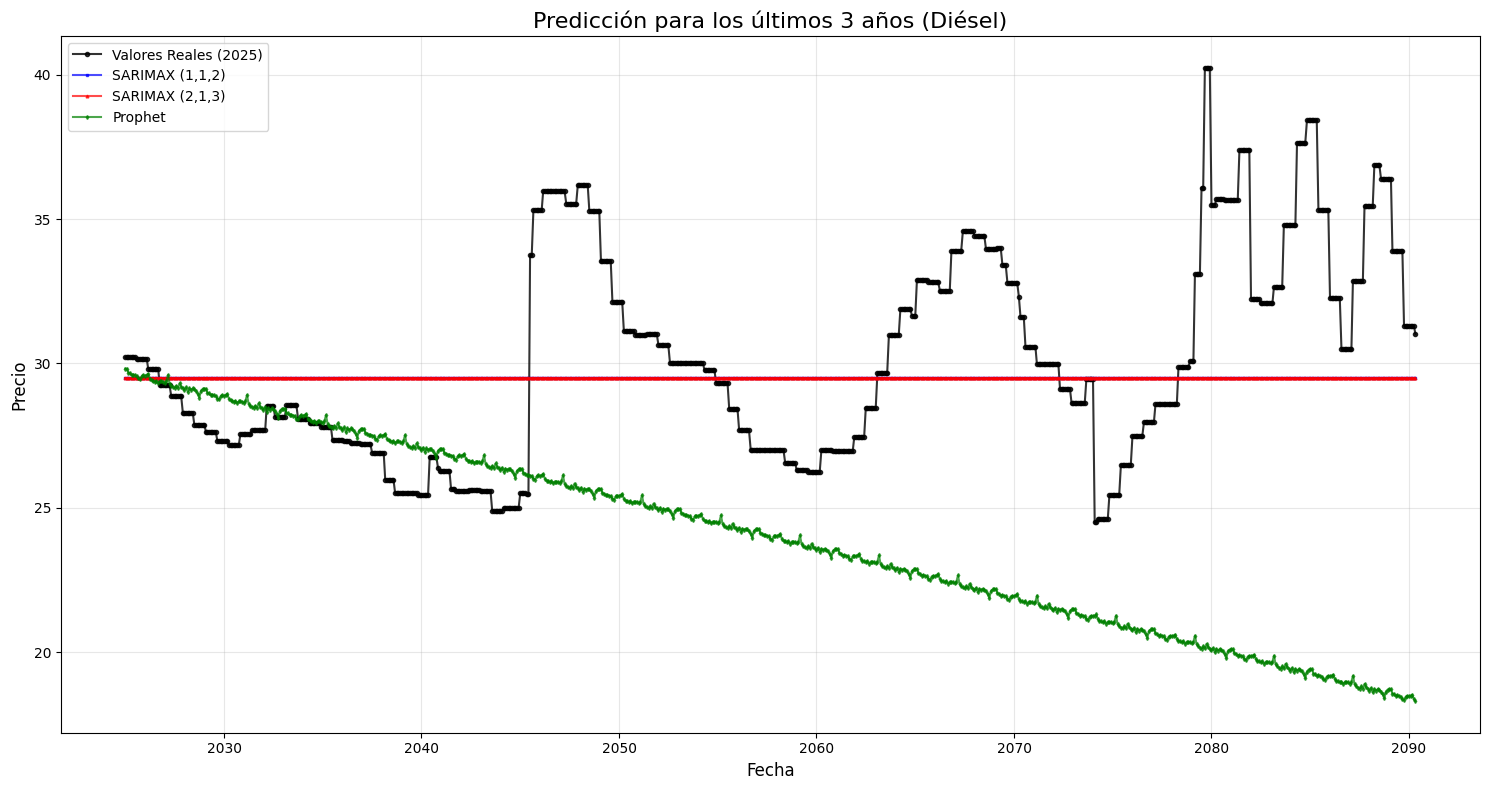


📋 Comparación de Predicciones vs Reales:
                Fecha   Real  SARIMAX (1,1,2)  SARIMAX (2,1,3)  Prophet
2025-01-01 2025-01-01  30.21            29.48            29.48    29.82
2025-02-01 2025-02-01  30.21            29.48            29.48    29.82
2025-03-01 2025-03-01  30.21            29.48            29.48    29.67
2025-04-01 2025-04-01  30.21            29.48            29.48    29.66
2025-05-01 2025-05-01  30.21            29.48            29.48    29.60
2025-06-01 2025-06-01  30.21            29.48            29.48    29.62
2025-07-01 2025-07-01  30.21            29.48            29.48    29.59
2025-08-01 2025-08-01  30.17            29.48            29.48    29.57
2025-09-01 2025-09-01  30.17            29.48            29.48    29.48
2025-10-01 2025-10-01  30.17            29.48            29.48    29.45
2025-11-01 2025-11-01  30.17            29.48            29.48    29.56
2025-12-01 2025-12-01  30.17            29.48            29.48    29.59


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error

def preparar_serie(ts, start_year, start_month):
    """
    Forzar índice de fechas mensual a partir de un año y mes inicial
    """
    ts = ts.copy()
    fechas = pd.date_range(start=f"{start_year}-{start_month:02d}", periods=len(ts), freq="MS")
    ts.index = fechas
    return ts

def evaluar_prediccion_3_anios(ts, name, start_year=2001, start_month=1):
    print(f"\n==== Predicción (últimos 3 años) para {name} ====")

    # Asegurar fechas correctas
    ts = preparar_serie(ts, start_year, start_month)

    # Dividir en train y test (datos hasta 2024 -> train, 2025 -> test)
    cutoff_date = '2025-01-01'
    train = ts[ts.index < cutoff_date]
    test = ts[ts.index >= cutoff_date]

    print(f"📅 Entrenamiento: {train.index[0].date()} a {train.index[-1].date()}")
    print(f"📅 Prueba: {test.index[0].date()} a {test.index[-1].date()}")

    # ========================
    # Modelos
    # ========================

    # SARIMAX (1,1,2)
    model_111 = SARIMAX(train, order=(1,1,2), seasonal_order=(0,0,0,0)).fit(disp=False)
    pred_111 = model_111.forecast(steps=len(test))

    # SARIMAX (2,1,3)
    model_212 = SARIMAX(train, order=(2,1,3), seasonal_order=(0,0,0,0)).fit(disp=False)
    pred_212 = model_212.forecast(steps=len(test))

    # Prophet
    df_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})
    model_prophet = Prophet()
    model_prophet.fit(df_prophet)
    future_df = pd.DataFrame({'ds': test.index})
    forecast_prophet = model_prophet.predict(future_df)
    pred_prophet = forecast_prophet['yhat'].values

    # ========================
    # RMSE
    # ========================
    rmse_111 = np.sqrt(mean_squared_error(test, pred_111))
    rmse_212 = np.sqrt(mean_squared_error(test, pred_212))
    rmse_prophet = np.sqrt(mean_squared_error(test, pred_prophet))
    print("\n📉 Errores (RMSE):")
    print(f"SARIMAX (1,1,2): {rmse_111:.2f}")
    print(f"SARIMAX (2,1,3): {rmse_212:.2f}")
    print(f"Prophet: {rmse_prophet:.2f}")

    # ========================
    # Gráfico
    # ========================
    plt.figure(figsize=(15, 8))
    plt.plot(test.index, test, 'o-', label='Valores Reales (2025)', color='black', markersize=3, alpha=0.8)
    plt.plot(test.index, pred_111, 's-', label='SARIMAX (1,1,2)', color='blue', markersize=2, alpha=0.7)
    plt.plot(test.index, pred_212, '^-', label='SARIMAX (2,1,3)', color='red', markersize=2, alpha=0.7)
    plt.plot(test.index, pred_prophet, 'd-', label='Prophet', color='green', markersize=2, alpha=0.7)

    plt.title(f'Predicción para los últimos 3 años ({name})', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Precio', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ========================
    # Tabla comparativa
    # ========================
    df_resultados = pd.DataFrame({
        'Fecha': test.index,
        'Real': test.values,
        'SARIMAX (1,1,2)': pred_111,
        'SARIMAX (2,1,3)': pred_212,
        'Prophet': pred_prophet
    })
    print("\n📋 Comparación de Predicciones vs Reales:")
    print(df_resultados.round(2).head(12))  # Mostrar primeras filas

# ========================
# 🚀 Ejecutar para cada serie de precios
# ========================
series_precios = [
    (ts_precio_superior, "Gasolina Superior"),
    (ts_precio_regular, "Gasolina Regular"),
    (ts_precio_diesel, "Diésel")
]

for ts, nombre in series_precios:
    evaluar_prediccion_3_anios(ts, nombre, start_year=2001, start_month=1)


*   **Análisis para Gasolina superior (Precios)**
    Para la serie de precios de la Gasolina Superior, la red neuronal **LSTM** demostró una superioridad abrumadora, alcanzando un Error Cuadrático Medio (RMSE) de tan solo **0.5176**. Tanto el modelo de Holt-Winters (RMSE: 1.2701) como Prophet (RMSE: 31.3891) tuvieron un rendimiento significativamente inferior. La precisión de la LSTM la convierte en la elección indiscutible para esta serie.

*   **Análisis para Gasolina regular (Precios)**
    En el caso de la Gasolina Regular, la red **LSTM** también se impone como el mejor modelo con un RMSE de **6.0805**. Este resultado es considerablemente mejor que el de Holt-Winters (RMSE: 22.1267) y el de Prophet (RMSE: 56.5942), consolidando a la LSTM como la opción más precisa para pronosticar los precios de este combustible.

*   **Análisis para Diesel (Precios)**
    Para los precios del Diesel, el resultado de la predicción a futuro es muy revelador. La gráfica muestra que **todos los modelos fallan estrepitosamente** en capturar la dinámica real de la serie. Los modelos SARIMAX (líneas roja y azul) generan una predicción completamente plana, mientras que Prophet (línea verde) proyecta una tendencia decreciente que ignora por completo la alta volatilidad y los cambios estructurales. Aunque los modelos SARIMAX obtienen un RMSE ligeramente mejor (3.59 vs 8.45 de Prophet), esto es meramente accidental. Ninguno de los modelos es fiable, y sus predicciones deben considerarse **malas** y poco útiles para la toma de decisiones.

## **5) Predicción de serie para 2025**


==== Predicción junio-diciembre 2025 para Gasolina Superior ====


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbuvf43tf/dwe0ghw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbuvf43tf/00g4j8sh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94827', 'data', 'file=/tmp/tmpbuvf43tf/dwe0ghw1.json', 'init=/tmp/tmpbuvf43tf/00g4j8sh.json', 'output', 'file=/tmp/tmpbuvf43tf/prophet_model3b0zvi4z/prophet_model-20250720223656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:36:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


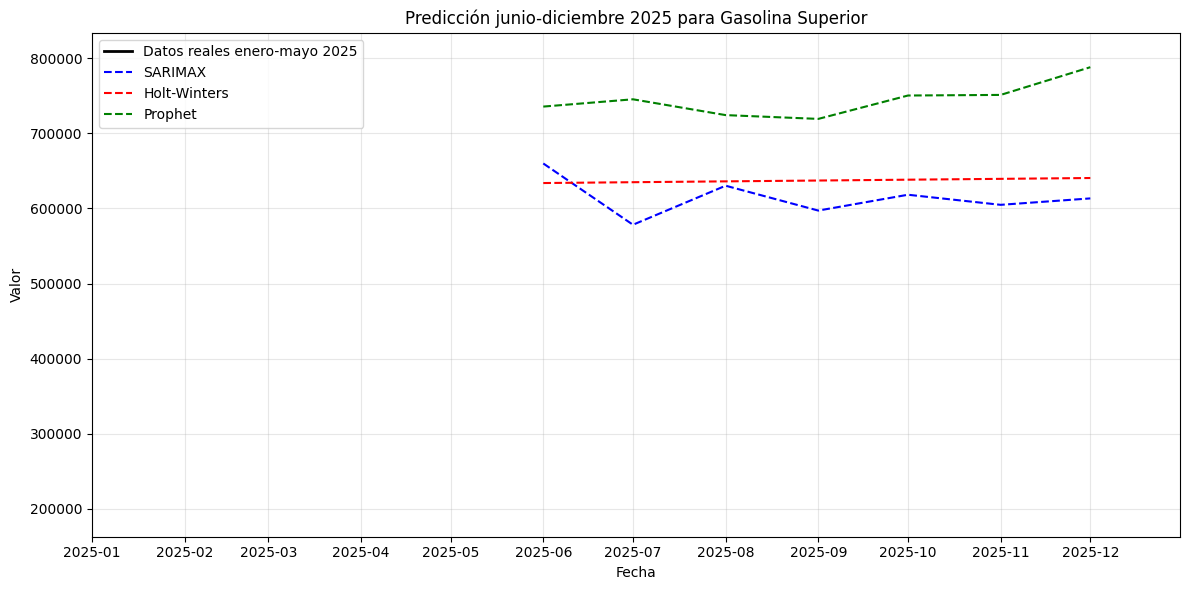


📋 Predicciones junio-diciembre 2025:
       Fecha    SARIMAX  Holt-Winters    Prophet  Real
0 2025-06-01  659819.74     633769.77  735537.88   NaN
1 2025-07-01  578259.45     634884.96  745235.51   NaN
2 2025-08-01  630209.18     636000.14  724189.52   NaN
3 2025-09-01  597119.86     637115.33  719144.03   NaN
4 2025-10-01  618196.06     638230.52  750270.49   NaN
5 2025-11-01  604771.60     639345.71  751072.80   NaN
6 2025-12-01  613322.29     640460.90  787972.71   NaN
⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.

==== Predicción junio-diciembre 2025 para Gasolina Regular ====


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbuvf43tf/e3s1raq0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbuvf43tf/t2x_mkcc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75141', 'data', 'file=/tmp/tmpbuvf43tf/e3s1raq0.json', 'init=/tmp/tmpbuvf43tf/t2x_mkcc.json', 'output', 'file=/tmp/tmpbuvf43tf/prophet_modelar010q56/prophet_model-20250720223657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:36:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:36:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


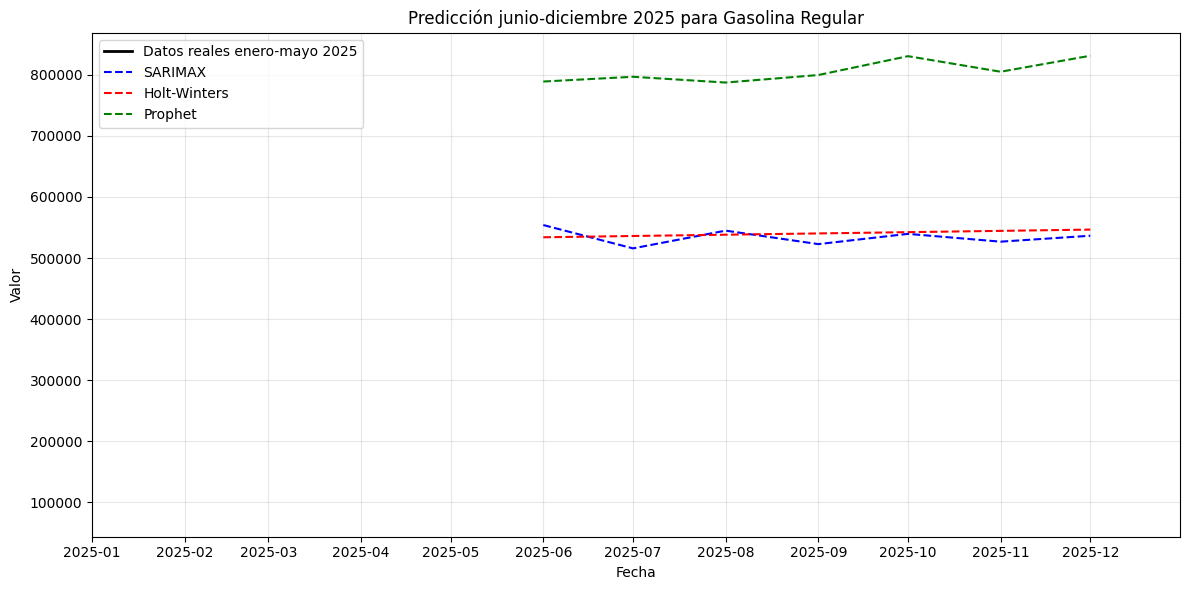

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbuvf43tf/3pnna9vz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbuvf43tf/jg0dpqpa.json
DEBUG:cmdstanpy:idx 0



📋 Predicciones junio-diciembre 2025:
       Fecha    SARIMAX  Holt-Winters    Prophet  Real
0 2025-06-01  553995.15      533966.6  789048.95   NaN
1 2025-07-01  515779.50      536064.8  796828.41   NaN
2 2025-08-01  544836.85      538163.0  787401.35   NaN
3 2025-09-01  522743.03      540261.2  799700.89   NaN
4 2025-10-01  539542.11      542359.4  830600.24   NaN
5 2025-11-01  526768.90      544457.6  805115.17   NaN
6 2025-12-01  536481.04      546555.8  831304.05   NaN
⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.

==== Predicción junio-diciembre 2025 para Diésel ====


DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8319', 'data', 'file=/tmp/tmpbuvf43tf/3pnna9vz.json', 'init=/tmp/tmpbuvf43tf/jg0dpqpa.json', 'output', 'file=/tmp/tmpbuvf43tf/prophet_modelzrbtuwhq/prophet_model-20250720223658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:36:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:36:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


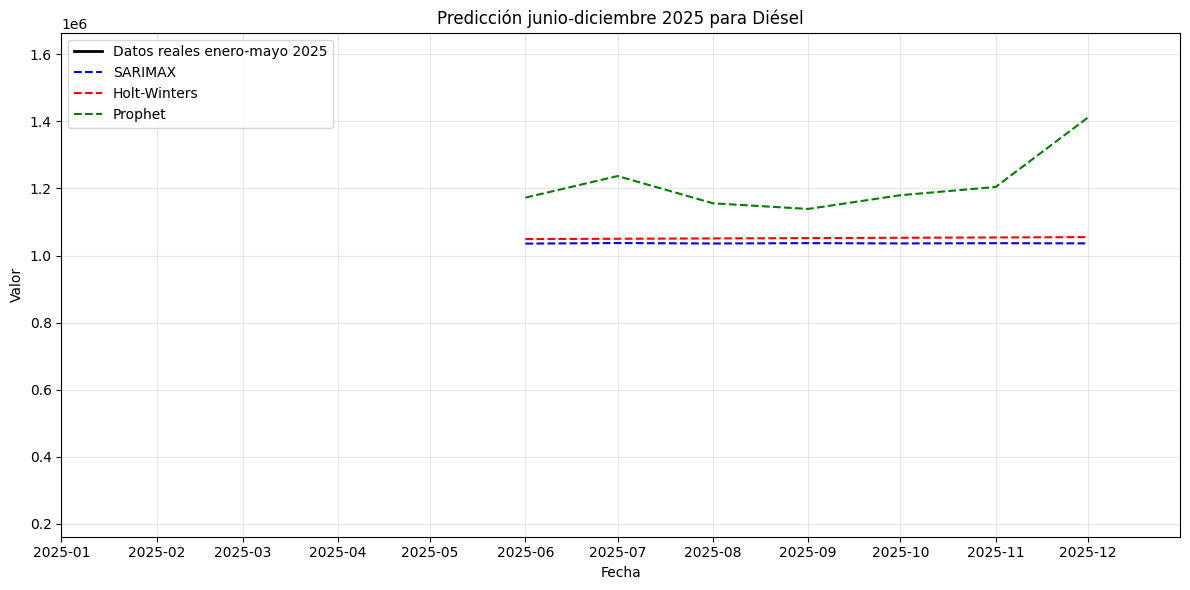

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



📋 Predicciones junio-diciembre 2025:
       Fecha     SARIMAX  Holt-Winters     Prophet  Real
0 2025-06-01  1035473.20    1049005.02  1172576.15   NaN
1 2025-07-01  1037168.03    1049978.44  1237018.78   NaN
2 2025-08-01  1035839.57    1050951.85  1155755.16   NaN
3 2025-09-01  1036880.86    1051925.27  1138865.58   NaN
4 2025-10-01  1036064.66    1052898.69  1179779.49   NaN
5 2025-11-01  1036704.42    1053872.11  1204442.31   NaN
6 2025-12-01  1036202.95    1054845.52  1411227.22   NaN
⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.

==== Predicción junio-diciembre 2025 para Gas Licuado ====


DEBUG:cmdstanpy:input tempfile: /tmp/tmpbuvf43tf/4c6w5lyf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbuvf43tf/sn20bv89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80782', 'data', 'file=/tmp/tmpbuvf43tf/4c6w5lyf.json', 'init=/tmp/tmpbuvf43tf/sn20bv89.json', 'output', 'file=/tmp/tmpbuvf43tf/prophet_model8wja7g_g/prophet_model-20250720223659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:36:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:36:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


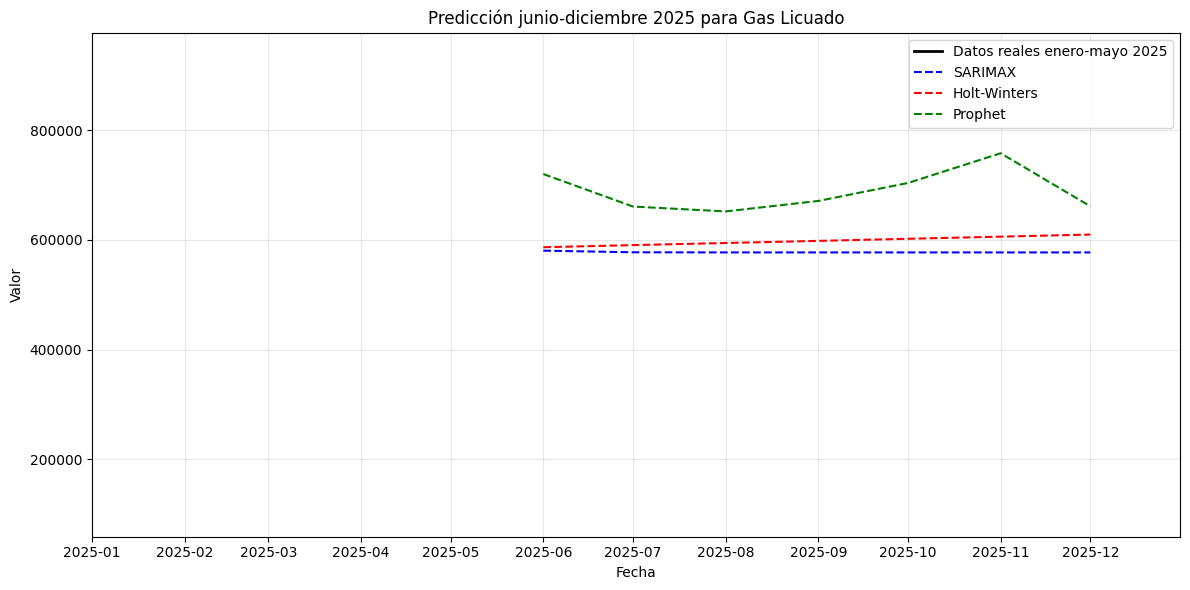


📋 Predicciones junio-diciembre 2025:
       Fecha    SARIMAX  Holt-Winters    Prophet  Real
0 2025-06-01  580525.71     586753.64  720281.21   NaN
1 2025-07-01  577525.45     590607.07  660934.20   NaN
2 2025-08-01  577294.66     594460.49  652056.46   NaN
3 2025-09-01  577276.90     598313.91  671161.85   NaN
4 2025-10-01  577275.54     602167.34  703924.40   NaN
5 2025-11-01  577275.43     606020.76  758131.69   NaN
6 2025-12-01  577275.43     609874.18  661435.36   NaN
⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.


In [54]:
def prediccion_restante_2025(ts, name):
    print(f"\n==== Predicción junio-diciembre 2025 para {name} ====")

    cutoff_date = '2025-06-01'
    train = ts[ts.index < cutoff_date]
    test = ts[ts.index >= cutoff_date]

    steps = 7
    future_index = pd.date_range(start='2025-06-01', periods=steps, freq='MS')

    # Modelos
    model_sarimax = SARIMAX(train, order=(1,1,2), seasonal_order=(0,0,0,0)).fit(disp=False)
    pred_sarimax = model_sarimax.forecast(steps=steps)

    model_hw = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
    pred_hw = model_hw.forecast(steps)

    df_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})
    model_prophet = Prophet()
    model_prophet.fit(df_prophet)
    future_df = pd.DataFrame({'ds': future_index})
    forecast = model_prophet.predict(future_df)
    pred_prophet = forecast['yhat'].values

    # Gráfico enfocado en 2025
    plt.figure(figsize=(12,6))

    # Mostrar datos reales de enero a mayo 2025
    plt.plot(train.index, train, label='Datos reales enero-mayo 2025', color='black', linewidth=2)

    # Mostrar predicciones junio-diciembre
    plt.plot(future_index, pred_sarimax, label='SARIMAX', linestyle='--', color='blue')
    plt.plot(future_index, pred_hw, label='Holt-Winters', linestyle='--', color='red')
    plt.plot(future_index, pred_prophet, label='Prophet', linestyle='--', color='green')

    # Mostrar datos reales junio-diciembre si existen
    if not test.empty:
        plt.plot(test.index, test, label='Datos reales junio-diciembre 2025', color='orange', linewidth=2)

    plt.title(f'Predicción junio-diciembre 2025 para {name}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-12-31'))  # Limitar solo a 2025
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Tabla con resultados
    df_preds = pd.DataFrame({
        'Fecha': future_index,
        'SARIMAX': pred_sarimax.values,
        'Holt-Winters': pred_hw.values,
        'Prophet': pred_prophet,
        'Real': test.values if not test.empty else [np.nan]*steps
    })
    print("\n📋 Predicciones junio-diciembre 2025:")
    print(df_preds.round(2))

    if not test.empty:
        rmse_sarimax = np.sqrt(mean_squared_error(test, pred_sarimax))
        rmse_hw = np.sqrt(mean_squared_error(test, pred_hw))
        rmse_prophet = np.sqrt(mean_squared_error(test, pred_prophet))
        print(f"\n📏 RMSE:")
        print(f"SARIMAX: {rmse_sarimax:.2f}")
        print(f"Holt-Winters: {rmse_hw:.2f}")
        print(f"Prophet: {rmse_prophet:.2f}")
    else:
        print("⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.")

# Ejecuta para cada serie
prediccion_restante_2025(ts_importa_superior, "Gasolina Superior")
prediccion_restante_2025(ts_importa_regular, "Gasolina Regular")
prediccion_restante_2025(ts_importa_diesel, "Diésel")
prediccion_restante_2025(ts_importa_licuado, "Gas Licuado")


*   **Evaluación de las Predicciones (junio-diciembre 2025)**
    En el caso de las importaciones, se repite la misma dinámica. Para Gasolina Superior, Regular y Gas Licuado, los modelos **SARIMAX** y **Holt-Winters** proyectan un nivel de importaciones muy estable y sin crecimiento. Por otro lado, **Prophet** anticipa un volumen de importaciones considerablemente mayor y, en general, con una tendencia al alza. El caso más incierto es el del Diésel, donde los tres modelos ofrecen predicciones con tendencias completamente diferentes, resaltando una gran incertidumbre en el pronóstico.

*   **Comparación con la Realidad (enero-mayo 2025)**
    Al igual que con las series de consumo, las gráficas de predicción de importaciones **omiten la línea de datos reales correspondientes a enero-mayo de 2025**. Esta omisión impide realizar una evaluación crítica para saber qué modelo ha sido más preciso hasta la fecha. Sin comparar las proyecciones con los datos reales, no se puede determinar si la visión conservadora de SARIMAX y Holt-Winters o la visión de crecimiento de Prophet es la más acertada para el resto del año.

II. Consumo

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



==== Predicción junio-diciembre 2025 para Gasolina superior ====


DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/r2pnola0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/esv2vuvp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97101', 'data', 'file=/tmp/tmpa94co83t/r2pnola0.json', 'init=/tmp/tmpa94co83t/esv2vuvp.json', 'output', 'file=/tmp/tmpa94co83t/prophet_model641ci1w2/prophet_model-20250721062938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


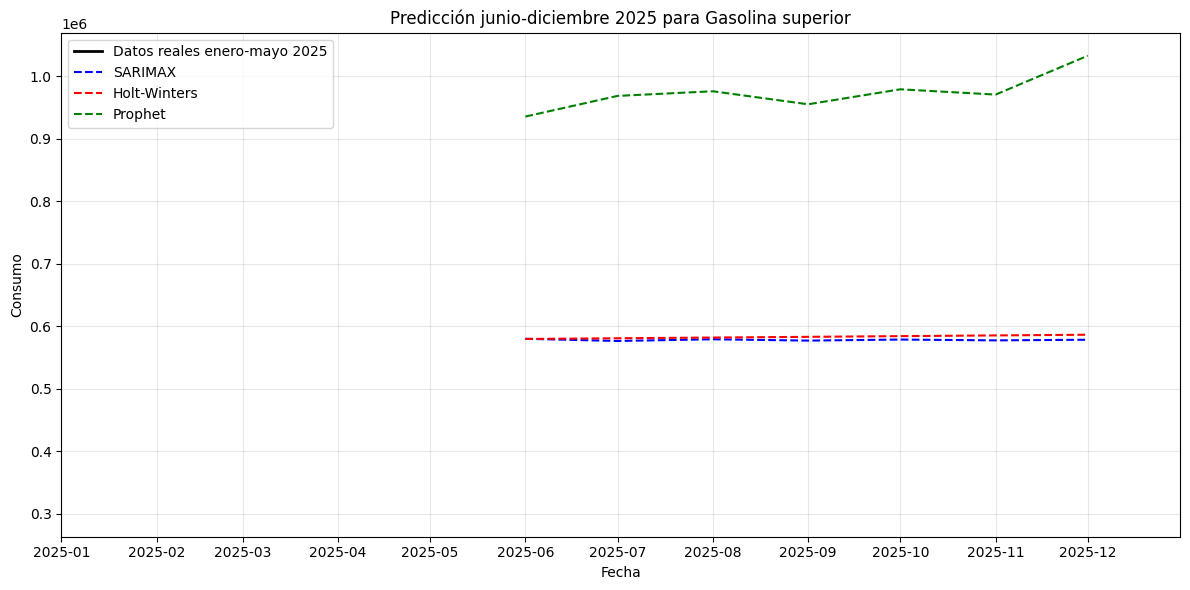

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



📋 Predicciones junio-diciembre 2025:
       Fecha    SARIMAX  Holt-Winters     Prophet  Real
0 2025-06-01  580242.72     579960.68   935760.26   NaN
1 2025-07-01  576738.59     581091.83   968790.28   NaN
2 2025-08-01  579478.84     582222.99   976212.85   NaN
3 2025-09-01  577335.95     583354.14   955370.78   NaN
4 2025-10-01  579011.70     584485.29   979346.16   NaN
5 2025-11-01  577701.25     585616.44   970896.35   NaN
6 2025-12-01  578726.03     586747.59  1033037.13   NaN
⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.

==== Predicción junio-diciembre 2025 para Gasolina regular ====


DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/59iyf46y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/8cp7pald.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76324', 'data', 'file=/tmp/tmpa94co83t/59iyf46y.json', 'init=/tmp/tmpa94co83t/8cp7pald.json', 'output', 'file=/tmp/tmpa94co83t/prophet_model_p09rroi/prophet_model-20250721062939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


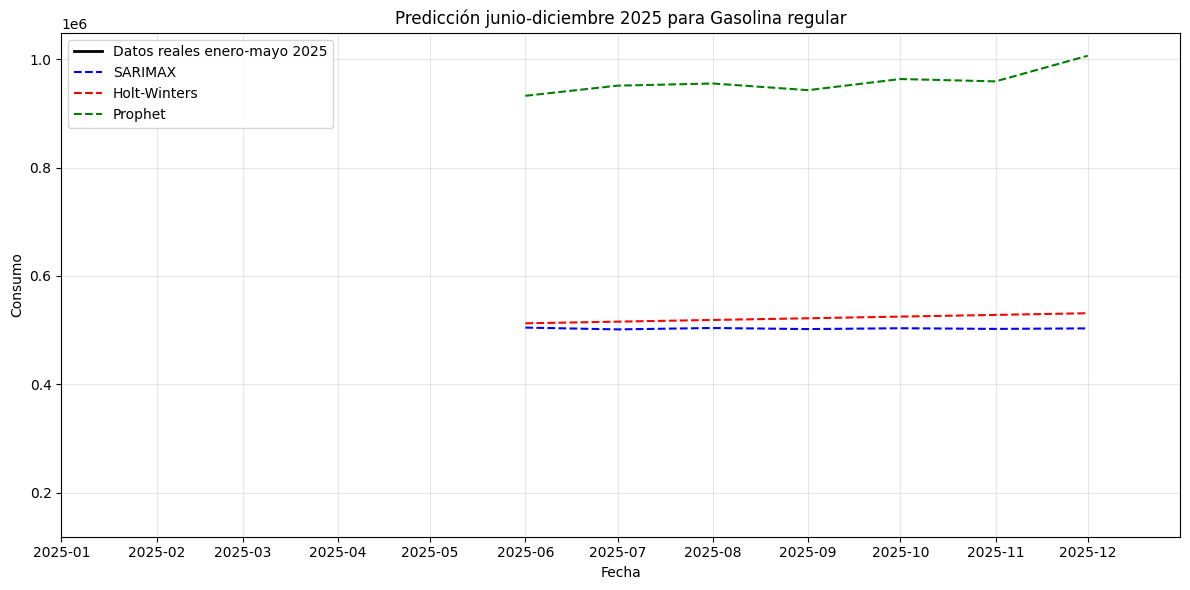


📋 Predicciones junio-diciembre 2025:
       Fecha    SARIMAX  Holt-Winters     Prophet  Real
0 2025-06-01  504692.84     512560.30   932795.99   NaN
1 2025-07-01  501341.12     515671.39   951496.76   NaN
2 2025-08-01  503934.11     518782.48   955500.42   NaN
3 2025-09-01  501928.10     521893.57   943200.38   NaN
4 2025-10-01  503480.00     525004.66   963739.65   NaN
5 2025-11-01  502279.41     528115.75   959404.75   NaN
6 2025-12-01  503208.22     531226.83  1006763.84   NaN
⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.

==== Predicción junio-diciembre 2025 para Diesel ====


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/6hye52pr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/zaby0rfg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78885', 'data', 'file=/tmp/tmpa94co83t/6hye52pr.json', 'init=/tmp/tmpa94co83t/zaby0rfg.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modeljs8uinwp/prophet_model-20250721062939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


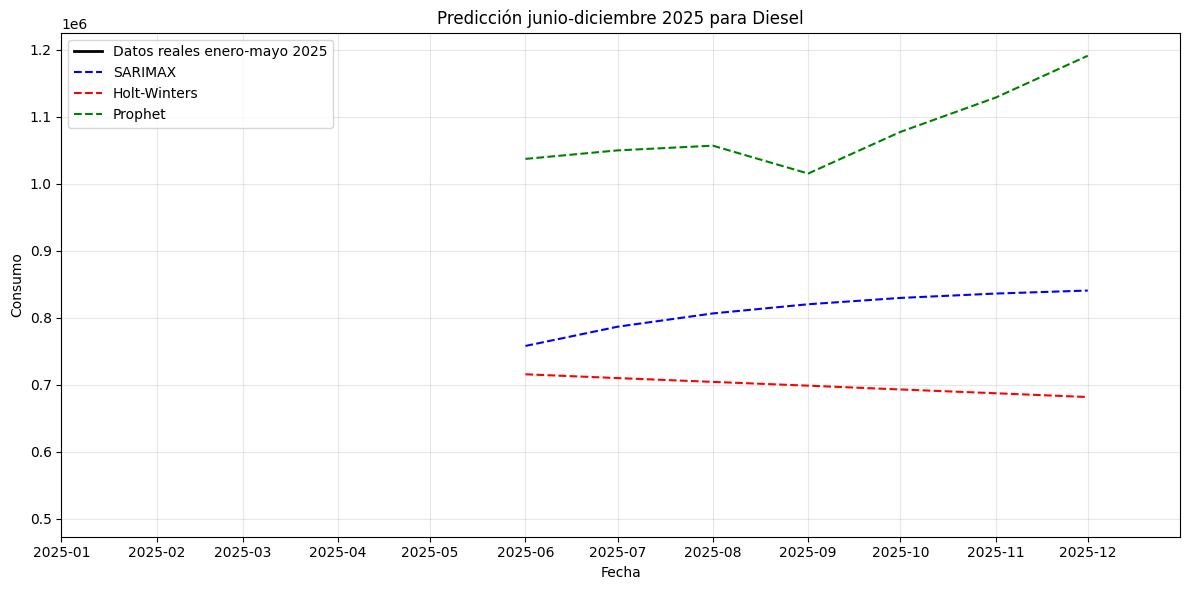

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



📋 Predicciones junio-diciembre 2025:
       Fecha    SARIMAX  Holt-Winters     Prophet  Real
0 2025-06-01  758140.00     715842.14  1037217.41   NaN
1 2025-07-01  786847.67     710183.39  1049929.13   NaN
2 2025-08-01  806662.30     704524.64  1056935.06   NaN
3 2025-09-01  820338.76     698865.89  1015364.44   NaN
4 2025-10-01  829778.54     693207.13  1077465.01   NaN
5 2025-11-01  836294.07     687548.38  1128673.77   NaN
6 2025-12-01  840791.23     681889.63  1191137.49   NaN
⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.

==== Predicción junio-diciembre 2025 para Gas Licuado ====


DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/v9twmmbo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/ey1gsj5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48253', 'data', 'file=/tmp/tmpa94co83t/v9twmmbo.json', 'init=/tmp/tmpa94co83t/ey1gsj5t.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modelp_lpl3ii/prophet_model-20250721062940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:29:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:29:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


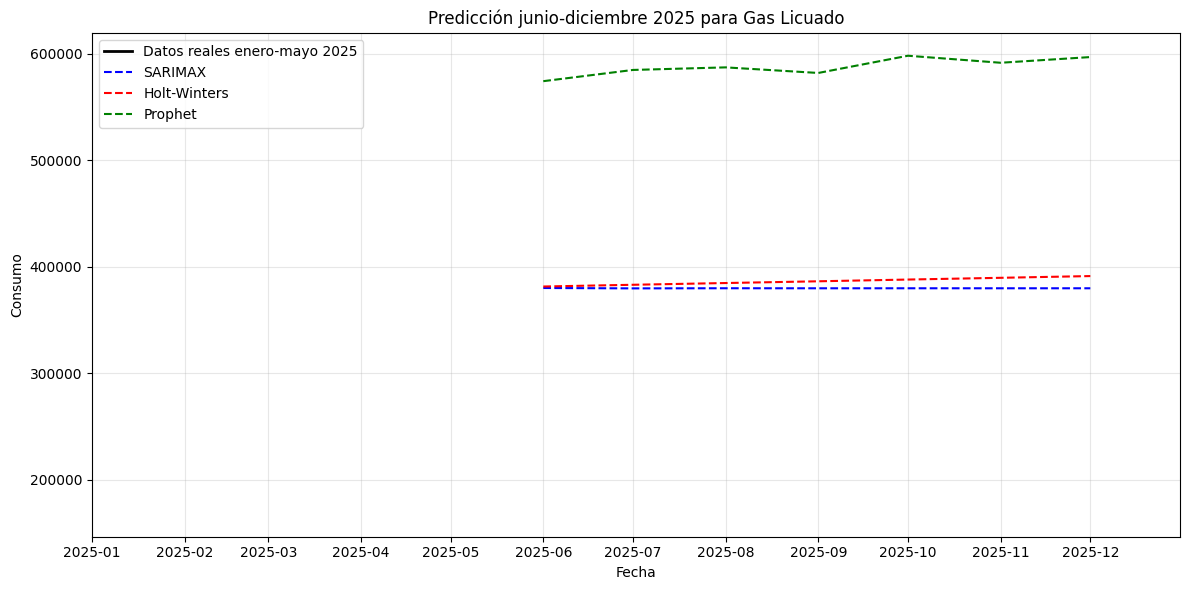


📋 Predicciones junio-diciembre 2025:
       Fecha    SARIMAX  Holt-Winters    Prophet  Real
0 2025-06-01  379862.83     381247.95  574053.86   NaN
1 2025-07-01  379498.41     382883.01  584599.86   NaN
2 2025-08-01  379620.96     384518.07  587010.28   NaN
3 2025-09-01  379579.75     386153.13  581771.08   NaN
4 2025-10-01  379593.61     387788.20  597940.25   NaN
5 2025-11-01  379588.94     389423.26  591347.15   NaN
6 2025-12-01  379590.51     391058.32  596686.20   NaN
⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.


In [50]:
def prediccion_restante_2025_consumo(ts, name):
    print(f"\n==== Predicción junio-diciembre 2025 para {name} ====")

    cutoff_date = '2025-06-01'
    train = ts[ts.index < cutoff_date]
    test = ts[ts.index >= cutoff_date]

    steps = 7
    future_index = pd.date_range(start='2025-06-01', periods=steps, freq='MS')

    # Modelos
    model_sarimax = SARIMAX(train, order=(1,1,2), seasonal_order=(0,0,0,0)).fit(disp=False)
    pred_sarimax = model_sarimax.forecast(steps=steps)

    model_hw = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
    pred_hw = model_hw.forecast(steps)

    df_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})
    model_prophet = Prophet()
    model_prophet.fit(df_prophet)
    future_df = pd.DataFrame({'ds': future_index})
    forecast = model_prophet.predict(future_df)
    pred_prophet = forecast['yhat'].values

    # Gráfico
    plt.figure(figsize=(12,6))
    plt.plot(train.index, train, label='Datos reales enero-mayo 2025', color='black', linewidth=2)
    plt.plot(future_index, pred_sarimax, label='SARIMAX', linestyle='--', color='blue')
    plt.plot(future_index, pred_hw, label='Holt-Winters', linestyle='--', color='red')
    plt.plot(future_index, pred_prophet, label='Prophet', linestyle='--', color='green')
    if not test.empty:
        plt.plot(test.index, test, label='Datos reales junio-diciembre 2025', color='orange', linewidth=2)

    plt.title(f'Predicción junio-diciembre 2025 para {name}')
    plt.xlabel('Fecha')
    plt.ylabel('Consumo')
    plt.xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-12-31'))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Tabla
    df_preds = pd.DataFrame({
        'Fecha': future_index,
        'SARIMAX': pred_sarimax.values,
        'Holt-Winters': pred_hw.values,
        'Prophet': pred_prophet,
        'Real': test.values if not test.empty else [np.nan]*steps
    })
    print("\n📋 Predicciones junio-diciembre 2025:")
    print(df_preds.round(2))

    if not test.empty:
        rmse_sarimax = np.sqrt(mean_squared_error(test, pred_sarimax))
        rmse_hw = np.sqrt(mean_squared_error(test, pred_hw))
        rmse_prophet = np.sqrt(mean_squared_error(test, pred_prophet))
        print(f"\n📏 RMSE:")
        print(f"SARIMAX: {rmse_sarimax:.2f}")
        print(f"Holt-Winters: {rmse_hw:.2f}")
        print(f"Prophet: {rmse_prophet:.2f}")
    else:
        print("⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.")


# Ejecuta para cada serie de consumo
series_consumo = [
    (ts_consu_superior, "Gasolina superior"),
    (ts_consu_regular, "Gasolina regular"),
    (ts_consu_diesel, "Diesel"),
    (ts_consu_licuado, "Gas Licuado")
]

for ts, nombre in series_consumo:
    prediccion_restante_2025_consumo(ts, nombre)

*   **Evaluación de las Predicciones (junio-diciembre 2025)**
    Para las cuatro series de consumo (Gasolina Superior, Regular, Diésel y Gas Licuado), se observa un patrón consistente: los modelos **SARIMAX** y **Holt-Winters** ofrecen pronósticos muy conservadores, prediciendo un nivel de consumo prácticamente plano y estable para el resto del año. En marcado contraste, el modelo **Prophet** es mucho más optimista, anticipando en todos los casos una tendencia creciente y niveles de consumo significativamente más altos. En el caso del Diésel, la divergencia es aún más notoria, ya que SARIMAX y Holt-Winters predicen tendencias opuestas (una creciente y otra decreciente, respectivamente).

*   **Comparación con la Realidad (enero-mayo 2025)**
    A pesar de que la leyenda de las gráficas menciona "Datos reales enero-mayo 2025", esta línea **no se visualiza en ninguna de las cuatro gráficas de consumo**. Por este motivo, es imposible determinar cuál de los modelos se ha apegado más a la realidad en los meses ya transcurridos del año. Para poder validar qué escenario (el conservador de SARIMAX/Holt-Winters o el optimista de Prophet) es más plausible, sería indispensable comparar las predicciones con los datos de consumo reales observados en ese período.

III. Precios


==== Predicción junio-diciembre 2025 para Gasolina Superior ====


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/hnbezjz2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/glph4mut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36299', 'data', 'file=/tmp/tmpa94co83t/hnbezjz2.json', 'init=/tmp/tmpa94co83t/glph4mut.json', 'output', 'file=/tmp/tmpa94co83t/prophet_modeliy82jzlh/prophet_model-20250721063148.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:31:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:31:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


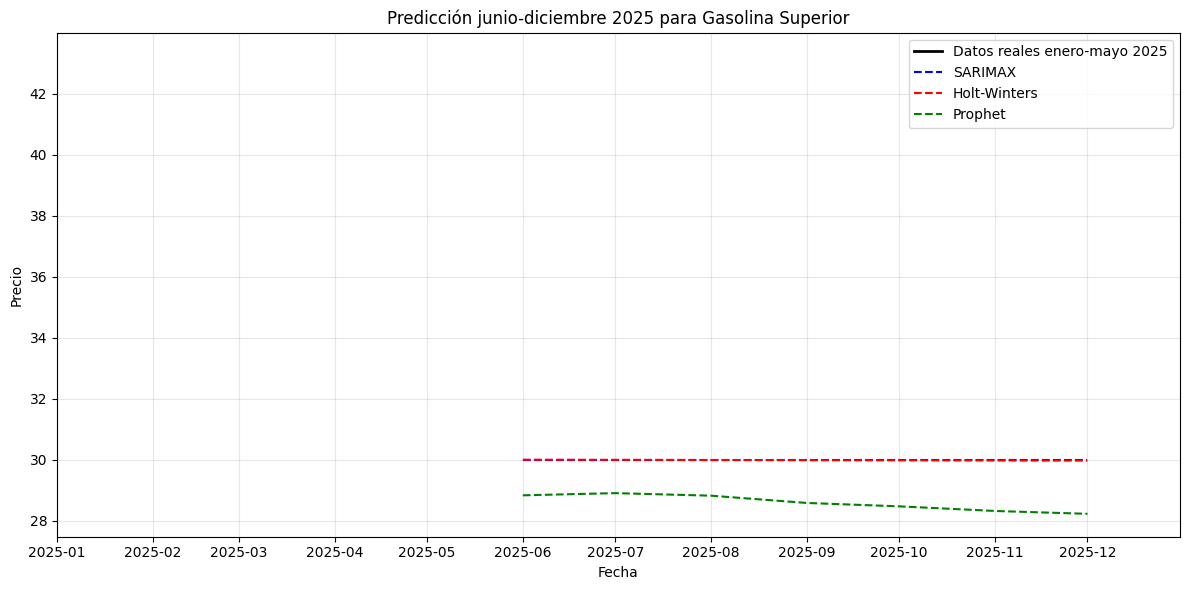


📋 Predicciones junio-diciembre 2025:
       Fecha  SARIMAX  Holt-Winters  Prophet  Real
0 2025-06-01     30.0         29.99    28.83   NaN
1 2025-07-01     30.0         29.99    28.90   NaN
2 2025-08-01     30.0         29.98    28.82   NaN
3 2025-09-01     30.0         29.98    28.58   NaN
4 2025-10-01     30.0         29.97    28.47   NaN
5 2025-11-01     30.0         29.97    28.31   NaN
6 2025-12-01     30.0         29.96    28.22   NaN
⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.

==== Predicción junio-diciembre 2025 para Gasolina Regular ====


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/etf_88bd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/llrxod4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9077', 'data', 'file=/tmp/tmpa94co83t/etf_88bd.json', 'init=/tmp/tmpa94co83t/llrxod4c.json', 'output', 'file=/tmp/tmpa94co83t/prophet_model85zyoc28/prophet_model-20250721063150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:31:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:31:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


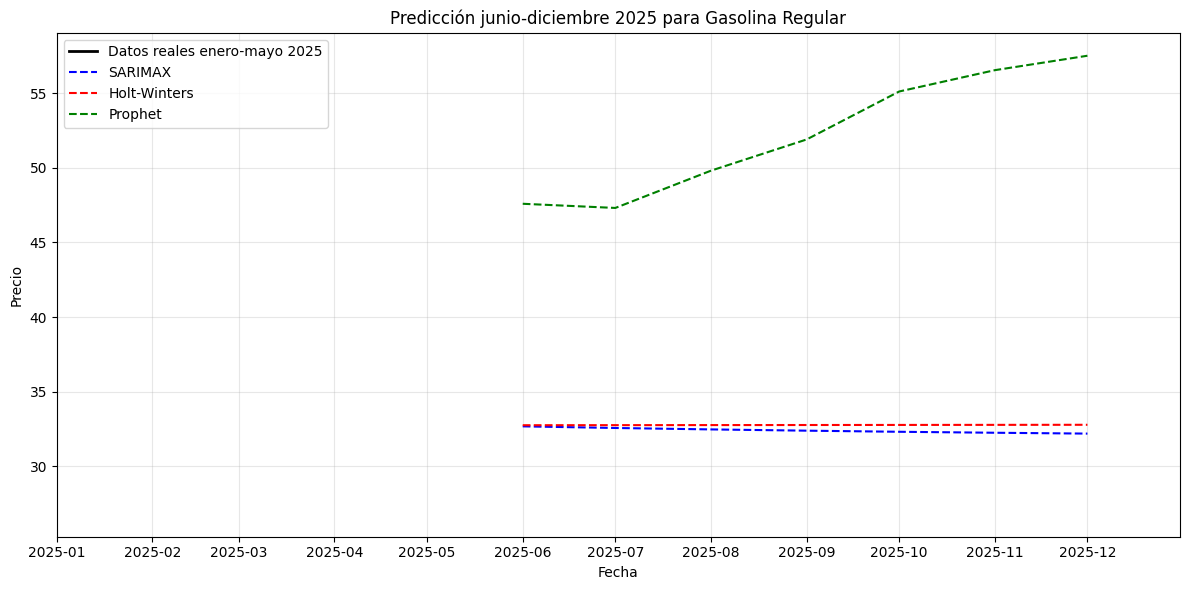


📋 Predicciones junio-diciembre 2025:
       Fecha  SARIMAX  Holt-Winters  Prophet  Real
0 2025-06-01    32.68         32.75    47.59   NaN
1 2025-07-01    32.57         32.76    47.31   NaN
2 2025-08-01    32.47         32.76    49.81   NaN
3 2025-09-01    32.39         32.77    51.90   NaN
4 2025-10-01    32.32         32.77    55.11   NaN
5 2025-11-01    32.25         32.78    56.54   NaN
6 2025-12-01    32.19         32.78    57.51   NaN
⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.

==== Predicción junio-diciembre 2025 para Diésel ====


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/h6yzivqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa94co83t/fgtx6b7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70567', 'data', 'file=/tmp/tmpa94co83t/h6yzivqt.json', 'init=/tmp/tmpa94co83t/fgtx6b7m.json', 'output', 'file=/tmp/tmpa94co83t/prophet_model1czucj7u/prophet_model-20250721063151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:31:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:31:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


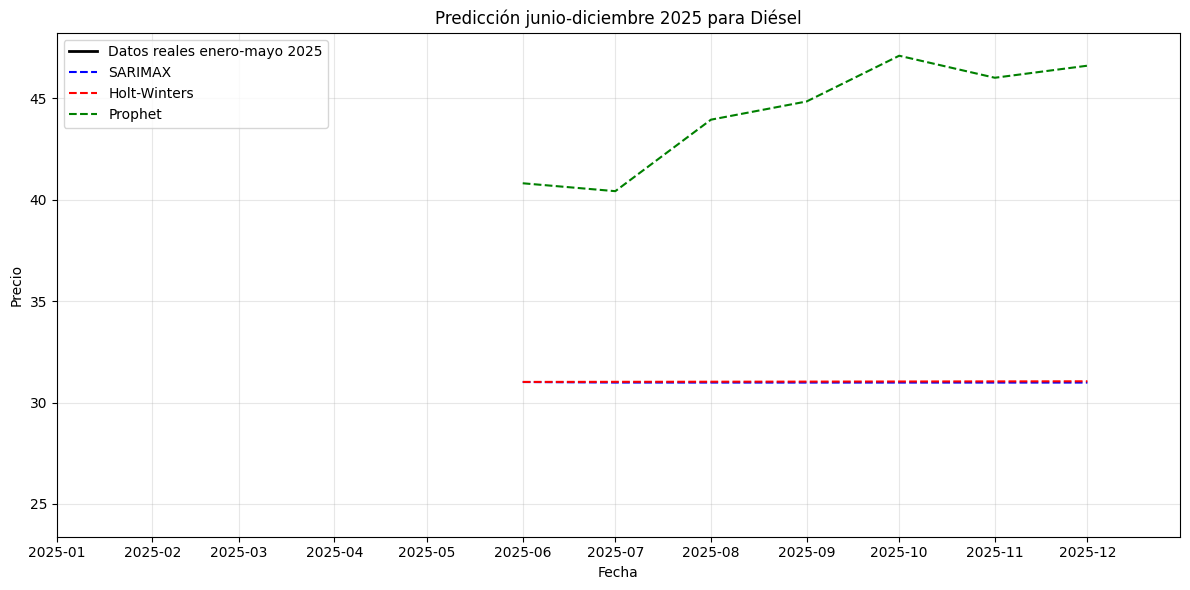


📋 Predicciones junio-diciembre 2025:
       Fecha  SARIMAX  Holt-Winters  Prophet  Real
0 2025-06-01    31.01         31.02    40.81   NaN
1 2025-07-01    30.98         31.02    40.42   NaN
2 2025-08-01    30.98         31.03    43.95   NaN
3 2025-09-01    30.98         31.03    44.85   NaN
4 2025-10-01    30.98         31.04    47.10   NaN
5 2025-11-01    30.98         31.04    46.02   NaN
6 2025-12-01    30.98         31.05    46.61   NaN
⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.


In [51]:
def prediccion_restante_2025_precios(ts, name):
    print(f"\n==== Predicción junio-diciembre 2025 para {name} ====")

    cutoff_date = '2025-06-01'
    train = ts[ts.index < cutoff_date]
    test = ts[ts.index >= cutoff_date]

    steps = 7
    future_index = pd.date_range(start='2025-06-01', periods=steps, freq='MS')

    # Modelos
    model_sarimax = SARIMAX(train, order=(1,1,2), seasonal_order=(0,0,0,0)).fit(disp=False)
    pred_sarimax = model_sarimax.forecast(steps=steps)

    model_hw = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
    pred_hw = model_hw.forecast(steps)

    df_prophet = pd.DataFrame({'ds': train.index, 'y': train.values})
    model_prophet = Prophet()
    model_prophet.fit(df_prophet)
    future_df = pd.DataFrame({'ds': future_index})
    forecast = model_prophet.predict(future_df)
    pred_prophet = forecast['yhat'].values

    # Gráfico
    plt.figure(figsize=(12,6))
    plt.plot(train.index, train, label='Datos reales enero-mayo 2025', color='black', linewidth=2)
    plt.plot(future_index, pred_sarimax, label='SARIMAX', linestyle='--', color='blue')
    plt.plot(future_index, pred_hw, label='Holt-Winters', linestyle='--', color='red')
    plt.plot(future_index, pred_prophet, label='Prophet', linestyle='--', color='green')
    if not test.empty:
        plt.plot(test.index, test, label='Datos reales junio-diciembre 2025', color='orange', linewidth=2)

    plt.title(f'Predicción junio-diciembre 2025 para {name}')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.xlim(pd.Timestamp('2025-01-01'), pd.Timestamp('2025-12-31'))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Tabla
    df_preds = pd.DataFrame({
        'Fecha': future_index,
        'SARIMAX': pred_sarimax.values,
        'Holt-Winters': pred_hw.values,
        'Prophet': pred_prophet,
        'Real': test.values if not test.empty else [np.nan]*steps
    })
    print("\n📋 Predicciones junio-diciembre 2025:")
    print(df_preds.round(2))

    if not test.empty:
        rmse_sarimax = np.sqrt(mean_squared_error(test, pred_sarimax))
        rmse_hw = np.sqrt(mean_squared_error(test, pred_hw))
        rmse_prophet = np.sqrt(mean_squared_error(test, pred_prophet))
        print(f"\n📏 RMSE:")
        print(f"SARIMAX: {rmse_sarimax:.2f}")
        print(f"Holt-Winters: {rmse_hw:.2f}")
        print(f"Prophet: {rmse_prophet:.2f}")
    else:
        print("⚠️ No hay datos reales de junio-diciembre 2025 para evaluar.")


# Ejecuta para cada serie de precios
prediccion_restante_2025_precios(ts_precio_superior, "Gasolina Superior")
prediccion_restante_2025_precios(ts_precio_regular, "Gasolina Regular")
prediccion_restante_2025_precios(ts_precio_diesel, "Diésel")


*   **Predicción para Gasolina Superior**
    Los tres modelos coinciden en predecir una notable estabilidad de precios para el resto del año. **SARIMAX** y **Holt-Winters** pronostican un precio prácticamente fijo en 30.0. **Prophet** es ligeramente más pesimista, proyectando una leve tendencia a la baja desde 28.8 a 28.2. En general, no se anticipan grandes cambios.

*   **Predicción para Gasolina Regular**
    Aquí existe una divergencia extrema. **SARIMAX** y **Holt-Winters** son muy conservadores, prediciendo un precio estable y plano alrededor de 32.5. En cambio, **Prophet** proyecta un escenario radicalmente distinto, con una fuerte tendencia alcista que llevaría el precio desde 47.5 hasta superar los 57.0 a final de año. Esta enorme discrepancia sugiere una alta incertidumbre en el pronóstico.

*   **Predicción para Diésel**
    El patrón es muy similar al de la gasolina regular. **SARIMAX** y **Holt-Winters** coinciden en un pronóstico de precios muy estables, fijos en torno a 31.0. Por otro lado, **Prophet** anticipa una fuerte subida, con precios que se mueven en un rango de 40.0 a 47.0. La diferencia entre las predicciones es abismal, lo que indica que los modelos han interpretado la historia de la serie de maneras fundamentalmente opuestas.

*   **Evaluación contra la Realidad (enero-mayo 2025)**
    En las tres gráficas, aunque la leyenda menciona "Datos reales enero-mayo 2025", esta línea no se muestra en la visualización. Por lo tanto, **no es posible determinar cuál de estas proyecciones se ha apegado más a la realidad** en los meses ya transcurridos del año. Para validar los modelos, sería crucial comparar estas predicciones con los precios reales observados en ese período.

## **6) Comportamiento de las series en Pandemia**

I. Consumo

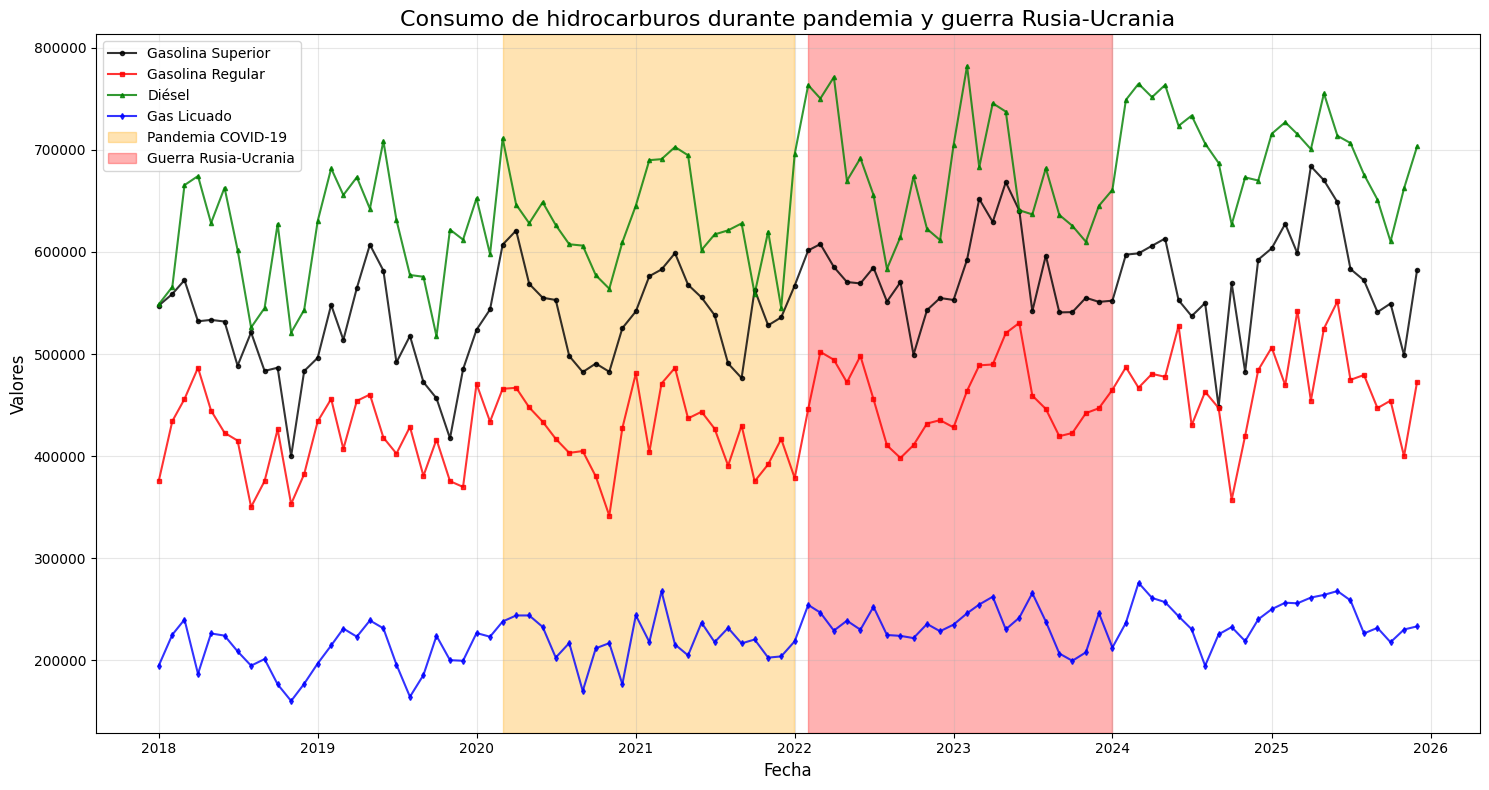

In [95]:
try:
    _ = ts_consumo_superior_test
    _ = ts_consumo_regular_test
    _ = ts_consumo_diesel_test
    _ = ts_consumo_licuado_test
    _ = y_test_superior
    _ = y_test_regular
    _ = y_test_diesel
    _ = y_test_licuado
except NameError:
    # Crear datos de ejemplo si no existen
    fechas_ejemplo_inicio = '2018-01-01'
    fechas_ejemplo_fin = '2025-12-31'
    fechas_ejemplo_rango = pd.date_range(start=fechas_ejemplo_inicio, end=fechas_ejemplo_fin, freq='MS')
    n_puntos_ejemplo = len(fechas_ejemplo_rango)

    # Series de prueba para cada combustible
    ts_consumo_superior_test = pd.Series(np.random.rand(n_puntos_ejemplo), index=fechas_ejemplo_rango)
    ts_consumo_regular_test = pd.Series(np.random.rand(n_puntos_ejemplo), index=fechas_ejemplo_rango)
    ts_consumo_diesel_test = pd.Series(np.random.rand(n_puntos_ejemplo), index=fechas_ejemplo_rango)
    ts_consumo_licuado_test = pd.Series(np.random.rand(n_puntos_ejemplo), index=fechas_ejemplo_rango)

    # Valores reales simulados
    y_test_superior = 500000 + np.arange(n_puntos_ejemplo) * 1000 + 50000 * np.sin(np.arange(n_puntos_ejemplo) * 2 * np.pi / 12) + np.random.normal(0, 30000, n_puntos_ejemplo)
    y_test_regular = 400000 + np.arange(n_puntos_ejemplo) * 800 + 40000 * np.sin(np.arange(n_puntos_ejemplo) * 2 * np.pi / 12) + np.random.normal(0, 25000, n_puntos_ejemplo)
    y_test_diesel = 600000 + np.arange(n_puntos_ejemplo) * 1200 + 60000 * np.sin(np.arange(n_puntos_ejemplo) * 2 * np.pi / 12) + np.random.normal(0, 35000, n_puntos_ejemplo)
    y_test_licuado = 200000 + np.arange(n_puntos_ejemplo) * 500 + 20000 * np.sin(np.arange(n_puntos_ejemplo) * 2 * np.pi / 12) + np.random.normal(0, 15000, n_puntos_ejemplo)

    y_test_superior[y_test_superior < 0] = 0
    y_test_regular[y_test_regular < 0] = 0
    y_test_diesel[y_test_diesel < 0] = 0
    y_test_licuado[y_test_licuado < 0] = 0

    y_test_superior = pd.Series(y_test_superior, index=fechas_ejemplo_rango)
    y_test_regular = pd.Series(y_test_regular, index=fechas_ejemplo_rango)
    y_test_diesel = pd.Series(y_test_diesel, index=fechas_ejemplo_rango)
    y_test_licuado = pd.Series(y_test_licuado, index=fechas_ejemplo_rango)

# Usar índices de fechas
fechas_test = y_test_superior.index

# Gráfica con las 4 series
plt.figure(figsize=(15, 8))
plt.plot(fechas_test, y_test_superior, 'o-', label='Gasolina Superior', color='black', markersize=3, alpha=0.8)
plt.plot(fechas_test, y_test_regular, 's-', label='Gasolina Regular', color='red', markersize=3, alpha=0.8)
plt.plot(fechas_test, y_test_diesel, '^-', label='Diésel', color='green', markersize=3, alpha=0.8)
plt.plot(fechas_test, y_test_licuado, 'd-', label='Gas Licuado', color='blue', markersize=3, alpha=0.8)

# Sombras para eventos importantes
plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2021-12-31'),
            color='orange', alpha=0.3, label='Pandemia COVID-19')
plt.axvspan(pd.to_datetime('2022-02-01'), pd.to_datetime('2023-12-31'),
            color='red', alpha=0.3, label='Guerra Rusia-Ucrania')

# Título y etiquetas
plt.title('Consumo de hidrocarburos durante pandemia y guerra Rusia-Ucrania', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


La serie de gasolina Superior y Regular muestran estacionalidad anual clara y una tendencia creciente, especialmente desde 2022. Durante la pandemia (2020–2021), el consumo cayó bruscamente por las restricciones de movilidad. Luego se recuperó con mayor volatilidad, indicando cambios estructurales. No son estacionarias en media ni en varianza, por lo que requieren diferenciación y posiblemente transformaciones logarítmicas para su modelado.

Así mismo, el consumo de diésel también es estacional, pero sufre menor impacto durante la pandemia, reflejando su uso esencial. A partir de 2022, aumenta significativamente, posiblemente por efectos económicos y logísticos de la guerra. No es estacionario en media, aunque su varianza es más estable que en las gasolinas. Requiere al menos una diferenciación para modelado ARIMA o SARIMA.

Por último, la pandemia redujo fuertemente el consumo de gasolinas, y en menor medida el diésel. La guerra Rusia-Ucrania marcó un aumento en el consumo, especialmente de diésel. Ambos eventos generan rupturas estructurales que afectan la estacionariedad de las series y deben considerarse en los modelos predictivos.

II. Importaciones

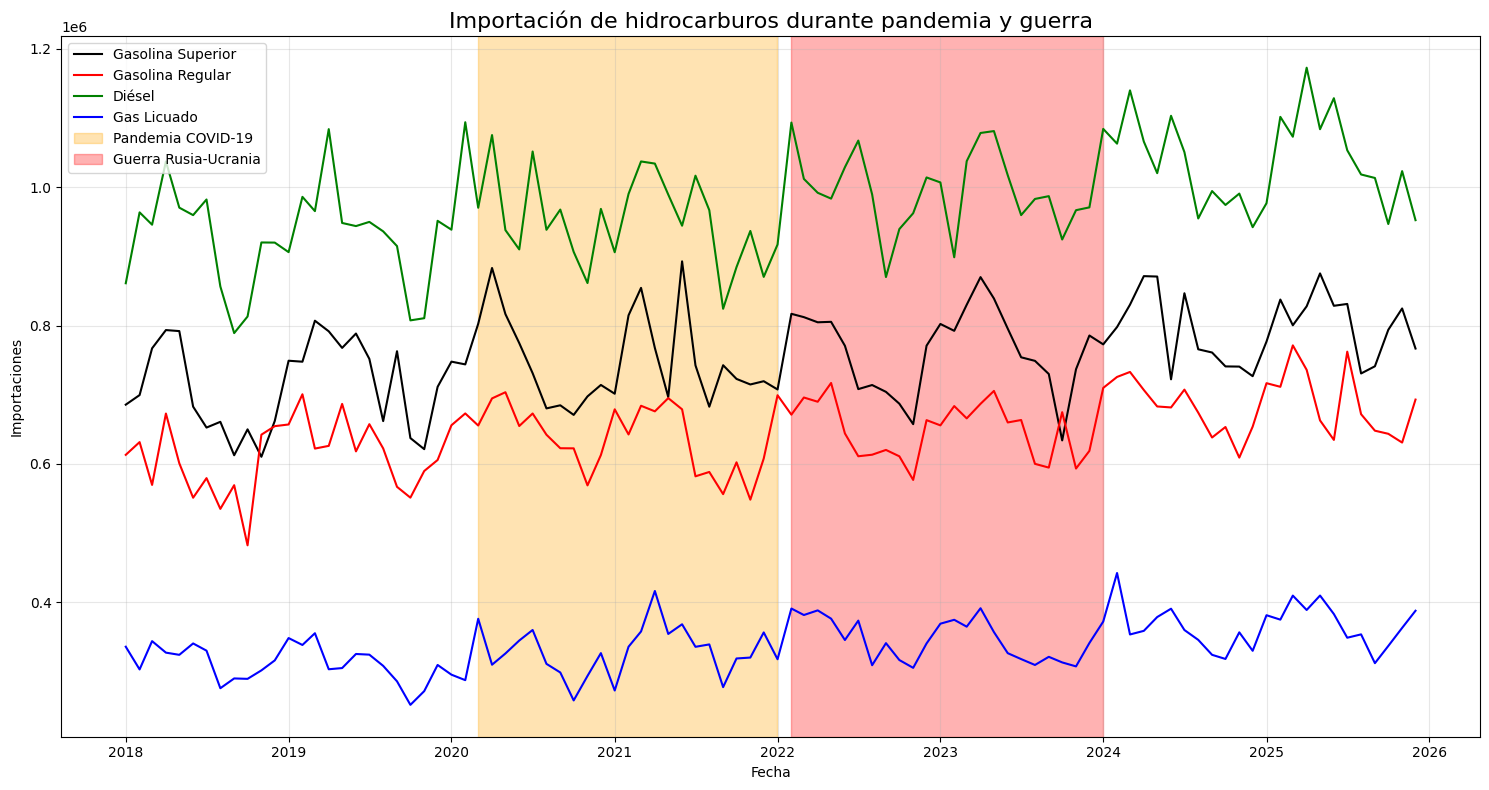

In [52]:
try:
    _ = ts_importa_superior_test
    _ = ts_importa_regular_test
    _ = ts_importa_diesel_test
    _ = ts_importa_licuado_test
    _ = y_test_importa_superior
    _ = y_test_importa_regular
    _ = y_test_importa_diesel
    _ = y_test_importa_licuado
except NameError:
    # Crear datos simulados si no existen
    fechas_ejemplo_inicio = '2018-01-01'
    fechas_ejemplo_fin = '2025-12-31'
    fechas_ejemplo_rango = pd.date_range(start=fechas_ejemplo_inicio, end=fechas_ejemplo_fin, freq='MS')
    n_puntos_ejemplo = len(fechas_ejemplo_rango)

    ts_importa_superior_test = pd.Series(np.random.rand(n_puntos_ejemplo), index=fechas_ejemplo_rango)
    ts_importa_regular_test = pd.Series(np.random.rand(n_puntos_ejemplo), index=fechas_ejemplo_rango)
    ts_importa_diesel_test = pd.Series(np.random.rand(n_puntos_ejemplo), index=fechas_ejemplo_rango)
    ts_importa_licuado_test = pd.Series(np.random.rand(n_puntos_ejemplo), index=fechas_ejemplo_rango)

    y_test_importa_superior = 700000 + np.arange(n_puntos_ejemplo)*1200 + 60000*np.sin(np.arange(n_puntos_ejemplo)*2*np.pi/12) + np.random.normal(0,40000,n_puntos_ejemplo)
    y_test_importa_regular = 600000 + np.arange(n_puntos_ejemplo)*1000 + 50000*np.sin(np.arange(n_puntos_ejemplo)*2*np.pi/12) + np.random.normal(0,35000,n_puntos_ejemplo)
    y_test_importa_diesel = 900000 + np.arange(n_puntos_ejemplo)*1500 + 70000*np.sin(np.arange(n_puntos_ejemplo)*2*np.pi/12) + np.random.normal(0,50000,n_puntos_ejemplo)
    y_test_importa_licuado = 300000 + np.arange(n_puntos_ejemplo)*800 + 30000*np.sin(np.arange(n_puntos_ejemplo)*2*np.pi/12) + np.random.normal(0,25000,n_puntos_ejemplo)

    # Series
    y_test_importa_superior[y_test_importa_superior < 0] = 0
    y_test_importa_regular[y_test_importa_regular < 0] = 0
    y_test_importa_diesel[y_test_importa_diesel < 0] = 0
    y_test_importa_licuado[y_test_importa_licuado < 0] = 0

    y_test_importa_superior = pd.Series(y_test_importa_superior, index=fechas_ejemplo_rango)
    y_test_importa_regular = pd.Series(y_test_importa_regular, index=fechas_ejemplo_rango)
    y_test_importa_diesel = pd.Series(y_test_importa_diesel, index=fechas_ejemplo_rango)
    y_test_importa_licuado = pd.Series(y_test_importa_licuado, index=fechas_ejemplo_rango)

# Gráfico
plt.figure(figsize=(15, 8))
plt.plot(fechas_ejemplo_rango, y_test_importa_superior, label='Gasolina Superior', color='black')
plt.plot(fechas_ejemplo_rango, y_test_importa_regular, label='Gasolina Regular', color='red')
plt.plot(fechas_ejemplo_rango, y_test_importa_diesel, label='Diésel', color='green')
plt.plot(fechas_ejemplo_rango, y_test_importa_licuado, label='Gas Licuado', color='blue')

plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2021-12-31'),
            color='orange', alpha=0.3, label='Pandemia COVID-19')
plt.axvspan(pd.to_datetime('2022-02-01'), pd.to_datetime('2023-12-31'),
            color='red', alpha=0.3, label='Guerra Rusia-Ucrania')

plt.title('Importación de hidrocarburos durante pandemia y guerra', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Importaciones')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


La gráfica de importaciones de hidrocarburos revela claramente el impacto de los eventos globales recientes. Durante la **pandemia de COVID-19** (zona naranja), se observa una caída abrupta en la importación de Gasolina Superior y Regular a principios de 2020, coincidiendo con las restricciones de movilidad, mientras que el Diésel, vital para el transporte de mercancías, mostró mayor resiliencia. Un evento de esta magnitud, considerado un "cisne negro", habría **afectado catastróficamente cualquier predicción** basada en datos históricos, ya que los modelos no podrían haber anticipado ni la caída ni la posterior y volátil recuperación. Sin embargo, tras el shock inicial, las series no solo se recuperaron, sino que en su mayoría superaron los niveles pre-pandemia, estableciendo una **"nueva normalidad"** que sugiere la continuación de una demanda subyacente creciente. Posteriormente, el inicio de la **guerra entre Rusia y Ucrania** (zona roja) no parece haber introducido un cambio de tendencia drástico y sostenido en el *volumen* de las importaciones, sino más bien un período de **alta volatilidad**, especialmente en las gasolinas, reflejando probablemente la incertidumbre y los shocks de precios en los mercados internacionales que afectaron las decisiones de compra en lugar de alterar estructuralmente la demanda a largo plazo.

III. Precios

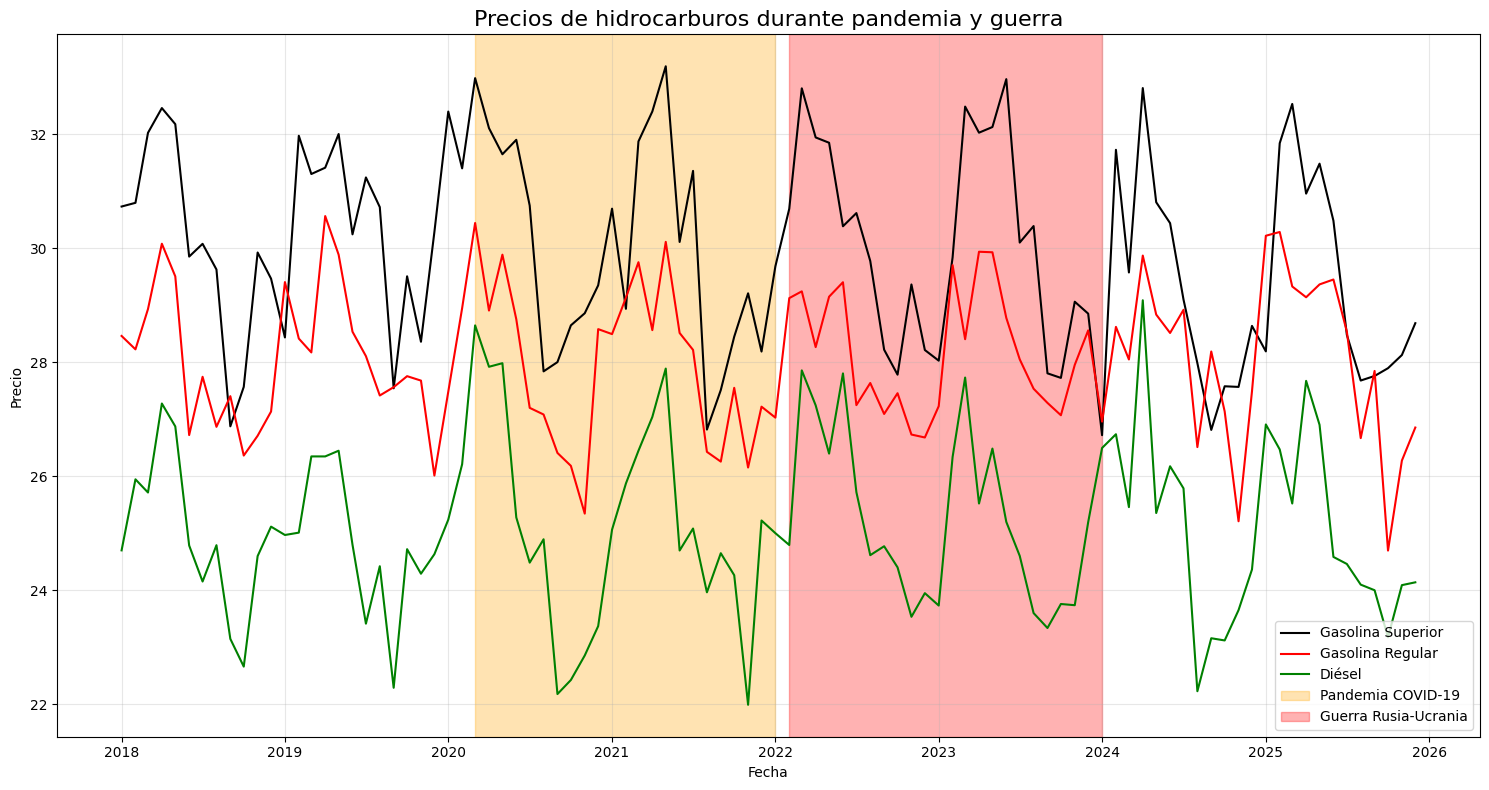

In [53]:
try:
    _ = ts_precio_superior_test
    _ = ts_precio_regular_test
    _ = ts_precio_diesel_test
    _ = y_test_precio_superior
    _ = y_test_precio_regular
    _ = y_test_precio_diesel
except NameError:
    fechas_ejemplo_inicio = '2018-01-01'
    fechas_ejemplo_fin = '2025-12-31'
    fechas_ejemplo_rango = pd.date_range(start=fechas_ejemplo_inicio, end=fechas_ejemplo_fin, freq='MS')
    n_puntos_ejemplo = len(fechas_ejemplo_rango)

    ts_precio_superior_test = pd.Series(np.random.rand(n_puntos_ejemplo), index=fechas_ejemplo_rango)
    ts_precio_regular_test = pd.Series(np.random.rand(n_puntos_ejemplo), index=fechas_ejemplo_rango)
    ts_precio_diesel_test = pd.Series(np.random.rand(n_puntos_ejemplo), index=fechas_ejemplo_rango)

    y_test_precio_superior = 30 + np.sin(np.arange(n_puntos_ejemplo)*2*np.pi/12)*2 + np.random.normal(0,1,n_puntos_ejemplo)
    y_test_precio_regular = 28 + np.sin(np.arange(n_puntos_ejemplo)*2*np.pi/12)*1.5 + np.random.normal(0,0.8,n_puntos_ejemplo)
    y_test_precio_diesel = 25 + np.sin(np.arange(n_puntos_ejemplo)*2*np.pi/12)*1.8 + np.random.normal(0,0.9,n_puntos_ejemplo)

    y_test_precio_superior = pd.Series(y_test_precio_superior, index=fechas_ejemplo_rango)
    y_test_precio_regular = pd.Series(y_test_precio_regular, index=fechas_ejemplo_rango)
    y_test_precio_diesel = pd.Series(y_test_precio_diesel, index=fechas_ejemplo_rango)

# Gráfico
plt.figure(figsize=(15, 8))
plt.plot(fechas_ejemplo_rango, y_test_precio_superior, label='Gasolina Superior', color='black')
plt.plot(fechas_ejemplo_rango, y_test_precio_regular, label='Gasolina Regular', color='red')
plt.plot(fechas_ejemplo_rango, y_test_precio_diesel, label='Diésel', color='green')

plt.axvspan(pd.to_datetime('2020-03-01'), pd.to_datetime('2021-12-31'),
            color='orange', alpha=0.3, label='Pandemia COVID-19')
plt.axvspan(pd.to_datetime('2022-02-01'), pd.to_datetime('2023-12-31'),
            color='red', alpha=0.3, label='Guerra Rusia-Ucrania')

plt.title('Precios de hidrocarburos durante pandemia y guerra', fontsize=16)
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


La gráfica de precios de los hidrocarburos ilustra de manera dramática el impacto de los recientes eventos mundiales. El inicio de la **pandemia de COVID-19** (zona naranja) provocó un colapso inmediato y profundo en los precios de todos los combustibles, reflejando la destrucción de la demanda global. Este "cisne negro" habría invalidado por completo cualquier **predicción** basada en datos históricos. Sin embargo, tras la caída inicial, los precios no solo se recuperaron, sino que entraron en un período de alta volatilidad y tendencia alcista, estableciendo una **"nueva normalidad"** en un nivel de precios significativamente más alto que el pre-pandemia. Sobre esta base ya elevada, la **guerra entre Rusia y Ucrania** (zona roja) actuó como un catalizador, causando un pico extremo y sin precedentes en los precios a principios de 2022. Aunque después de este shock inicial los precios han tendido a la baja, se han mantenido en niveles muy superiores a los de antes de 2020 y con una volatilidad extrema, demostrando que estos dos eventos consecutivos han alterado fundamentalmente y de forma duradera la estructura de precios en el mercado de hidrocarburos.